## Import libraries

In [15]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

import warnings
warnings.filterwarnings('once')

from prophet import Prophet

from scipy.stats import shapiro, ks_2samp
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from scipy.stats import boxcox, norm, ks_2samp
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Load data

In [2]:
df = pd.read_csv("../Datasets/class_products.csv", index_col=0)
df

ProductID Classification  DemandClass  QuantitySold   OrderDate
0             427              A  High demand            50  2003-07-11
1             427              A  High demand            50  2003-07-15
2             427              A  High demand            20  2003-07-14
3             427              A  High demand            25  2003-07-14
4             427              A  High demand            50  2003-07-18
...           ...            ...          ...           ...         ...
105265        387              C   Low demand             1  2005-01-24
105266        675              C   Low demand             1  2005-02-09
105267       4300              C   Low demand             1  2006-04-14
105268       2088              C   Low demand             0  2005-07-28
105269       2640              C   Low demand             0  2006-04-01

[105270 rows x 5 columns]

### Classify by demand

In [4]:
df['DemandClass'].unique()

array(['High demand', 'Low demand'], dtype=object)

In [5]:
df_high_demand = df[df['DemandClass'] == 'High demand']
df_low_demand = df[df['DemandClass'] == 'Low demand']

In [6]:
df_high_demand

ProductID Classification  DemandClass  QuantitySold   OrderDate
0             427              A  High demand            50  2003-07-11
1             427              A  High demand            50  2003-07-15
2             427              A  High demand            20  2003-07-14
3             427              A  High demand            25  2003-07-14
4             427              A  High demand            50  2003-07-18
...           ...            ...          ...           ...         ...
105204       4348              C  High demand            10  2006-04-06
105205       4216              C  High demand            10  2006-03-30
105206       4326              C  High demand            10  2006-03-30
105207       4215              C  High demand            10  2006-03-30
105208       4298              C  High demand            10  2006-03-30

[82051 rows x 5 columns]

In [7]:
df_low_demand

ProductID Classification DemandClass  QuantitySold   OrderDate
36321         771              A  Low demand             2  2003-07-15
36322         771              A  Low demand             5  2003-08-13
36323         771              A  Low demand             2  2003-08-14
36324         771              A  Low demand             5  2003-09-02
36325         771              A  Low demand             2  2003-09-10
...           ...            ...         ...           ...         ...
105265        387              C  Low demand             1  2005-01-24
105266        675              C  Low demand             1  2005-02-09
105267       4300              C  Low demand             1  2006-04-14
105268       2088              C  Low demand             0  2005-07-28
105269       2640              C  Low demand             0  2006-04-01

[23219 rows x 5 columns]

In [23]:
df_high_demand_A = df_high_demand[df_high_demand['Classification'] == 'A']
df_high_demand_B = df_high_demand[df_high_demand['Classification'] == 'B']
df_high_demand_C = df_high_demand[df_high_demand['Classification'] == 'C']

df_low_demand_A = df_low_demand[df_low_demand['Classification'] == 'A']
df_low_demand_B = df_low_demand[df_low_demand['Classification'] == 'B']
df_low_demand_C = df_low_demand[df_low_demand['Classification'] == 'C']

In [51]:
def selected_20_products(df):
    
    products_id = df['ProductID'].unique()
    print(len(products_id))
    selected_id = pd.Series(products_id).sample(frac=0.2, random_state=42)
    print(len(products_id)*0.2, len(selected_id))
    df_selected = df[df['ProductID'].isin(selected_id)]
    
    return df_selected
    

In [52]:
df_selected_high_demand_A = selected_20_products(df_high_demand_A)
df_selected_high_demand_A

438
87.60000000000001 88


ProductID Classification  DemandClass  QuantitySold   OrderDate
0            427              A  High demand            50  2003-07-11
1            427              A  High demand            50  2003-07-15
2            427              A  High demand            20  2003-07-14
3            427              A  High demand            25  2003-07-14
4            427              A  High demand            50  2003-07-18
...          ...            ...          ...           ...         ...
51016        637              A  High demand             5  2005-03-09
51017        637              A  High demand             3  2005-03-09
51018        637              A  High demand             1  2005-03-22
51019        637              A  High demand            16  2005-03-24
51020        637              A  High demand            10  2005-04-01

[10983 rows x 5 columns]

In [53]:
df_selected_high_demand_B = selected_20_products(df_high_demand_B)
df_selected_high_demand_C = selected_20_products(df_high_demand_C)
df_selected_low_demand_A = selected_20_products(df_low_demand_A)
df_selected_low_demand_B = selected_20_products(df_low_demand_B)
df_selected_low_demand_C = selected_20_products(df_low_demand_C)

928
185.60000000000002 186
827
165.4 165
11
2.2 2
497
99.4 99
1340
268.0 268


In [39]:
def outliers_median(df):
    
    q1 = df['QuantitySold'].quantile(0.25)
    q3 = df['QuantitySold'].quantile(0.75)
    
    iqr = q3 -q1
    
    lim_inf = q1 -1.5*iqr
    lim_sup = q3 + 1.5*iqr
    
    outliers = df[(df['QuantitySold'] < lim_inf) | (df['QuantitySold'] > lim_sup)]

    perc_out = (len(outliers) / len(df['QuantitySold'])) * 100

    print(f'Percentage outliers:  {perc_out}') 
    
    
    mean = df['QuantitySold'].mean()
    median = df['QuantitySold'].median()
    
    print(f"Mean : {mean}, Median: {median}")
    
    df['QuantitySold_no_out'] = np.where((df['QuantitySold'] < lim_inf) | (df['QuantitySold'] > lim_sup),
                              df['QuantitySold'].median(), df['QuantitySold'])
    
    plt.figure(figsize=(18,5))
    plt.plot(df['QuantitySold'], linestyle="-", label = 'Sales')
    plt.plot(df['QuantitySold_no_out'], linestyle="-", label = 'Sales no outliers' )
    plt.axhline(y=mean, color='r', linestyle="--", label=f"Mean: {mean:.2f}")
    plt.title('Sales forecasting')
    plt.legend()
    plt.grid()
    plt.show()
    
    # subsitute outliers: 
    
    df['QuantitySold'] = df['QuantitySold_no_out']
    df.drop(columns=['QuantitySold_no_out'], inplace=True)
    
    return df

In [117]:
def check_normality(df):
    residuos = df['QuantitySold']

    # Filtrar valores no finitos (NaN, inf)
    residuos_clean = residuos[np.isfinite(residuos)]

    if len(residuos_clean) < 3:  # Requerido para las pruebas de normalidad
        print("Los datos no son suficientes o contienen valores no finitos para la prueba de normalidad.")
        return df  # Retornar el dataframe sin modificaciones si no son adecuados

    # Test de Kolmogorov-Smirnov
    mean_residuos = residuos_clean.mean()
    std_residuos = residuos_clean.std()
    ks_stat, p_ks = ks_2samp(residuos_clean, np.random.normal(loc=mean_residuos, scale=std_residuos, size=len(residuos_clean)))
    
    # Test de Shapiro-Wilk (para n < 5000)
    shapiro_stat, p_shapiro = shapiro(residuos_clean) if len(residuos_clean) < 5000 else (None, None)

    print(f"p-value Kolmogorov-Smirnov: {p_ks}")
    print(f"p-value Shapiro-Wilk: {p_shapiro}")

    # Si p-valor < 0.05 en ambos test, la serie no es normal -> aplicar Box-Cox
    if p_ks < 0.05 or (p_shapiro is not None and p_shapiro < 0.05):
        print("La serie NO es normal. Aplicando Box-Cox...")

        # Asegurarse de que los datos sean positivos
        if (residuos_clean <= 0).any():
            min_value = residuos_clean.min()
            print(f"Valor mínimo antes de ajuste: {min_value}")
            residuos_clean = residuos_clean - min_value + 1e-6  # Asegura que todos los valores sean positivos
            print(f"Valor mínimo después de ajuste: {residuos_clean.min()}")
        
        # Aplicar Box-Cox
        df['QuantitySold'] = residuos_clean.copy()
        df['QuantitySold'], lambda_bc = boxcox(df['QuantitySold'])
        print(f"Lambda de Box-Cox: {lambda_bc}")
    else:
        print("La serie es normal. No es necesario aplicar Box-Cox.")
    
    # Verificar la normalidad después de la transformación Box-Cox
    ks_stat, p_ks = ks_2samp(df['QuantitySold'], np.random.normal(loc=mean_residuos, scale=std_residuos, size=len(df['QuantitySold'])))
    shapiro_stat, p_shapiro = shapiro(df['QuantitySold']) if len(df['QuantitySold']) < 5000 else (None, None)

    print(f"p-value Kolmogorov-Smirnov después de Box-Cox: {p_ks}")
    print(f"p-value Shapiro-Wilk después de Box-Cox: {p_shapiro}")

    return df

In [41]:
def divide_train_test(df, test_size = 0.1):
    
    train = 1 - test_size
    train_size = round(len(df) * train)
    
    train_data = df[:train_size]
    test_data = df[train_size:]
    
    return train_data, test_data

In [127]:

def calculate_errors(real, pred):
    # Eliminar valores NaN en los datos de entrada
    valid_indices = ~np.isnan(real) & ~np.isnan(pred)
    real_clean = real[valid_indices]
    pred_clean = pred[valid_indices]
    
    # Si después de eliminar los NaN hay datos válidos
    if len(real_clean) > 0 and len(pred_clean) > 0:
        mae = mean_absolute_error(real_clean, pred_clean)
        mse = mean_squared_error(real_clean, pred_clean)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((real_clean - pred_clean) / real_clean)) * 100
    else:
        # Si no hay datos válidos, devolver NaN
        mae = mse = rmse = mape = np.nan
    
    return mae, mse, rmse, mape

In [129]:
def moving_average(train, test, span=10):
    
    train = train.copy()
    test = test.copy()
    train['EMA'] = train['QuantitySold'].ewm(span=span, adjust=False).mean()
    
    last_ema = train['EMA'].iloc[-1]
    test['EMA'] = last_ema
    
    return train, test

In [44]:
def arima (train, test, order=(1,2,1)):
    
    model = ARIMA(train['QuantitySold'], order = order)
    fit = model.fit()
    test['ARIMA_Pred'] = fit.forecast(steps = len(test))
    return train, test

In [45]:
def apply_sarimax( train, test, order = (2,1,2), seasonal_order=(1,1,1,12)):
    
    model = SARIMAX(train['QuantitySold'], order=order, seasonal_order=seasonal_order)
    fit = model.fit()
    
    test['SARIMAX_pred'] = fit.forecast(steps=len(test))
    
    return train, test

In [125]:
def apply_prophet(train, test, periods = 10):
    
    train = train.reset_index()
    test = test.reset_index()
    train = train.rename(columns={'OrderDate': 'ds', 'QuantitySold': 'y'})
    train['ds'] = pd.to_datetime(train['ds'])
    
    train = train.dropna(subset=['y'])
    
    # Verificar si después de eliminar nulos, el dataframe tiene suficientes datos
    if len(train) < 2:
        print("No hay suficientes datos no nulos en el dataframe para aplicar Prophet.")
        test['Prophet_Pred'] = 0
        
        return train, test
    
    model = Prophet()
    model.fit(train)
    
    future = pd.DataFrame({'ds': test['OrderDate']})
    future['ds'] = pd.to_datetime(future['ds'])
    forecast = model.predict(future)
    
    test['Prophet_Pred'] = forecast['yhat'].values
    test['Prophet_Pred'].fillna(0, inplace=True)
    
    train = train.set_index('ds')  
    test = test.set_index('OrderDate')
    
    return train, test

In [95]:
def evaluate_model(df, product, demand_class):
    errors = {'ProductID': [], 'Modelo': [], "MAE": [], "MSE": [], "RMSE": [], "MAPE": [], "Predictions": [] }
    pred_completas = pd.DataFrame()
    
    df_p = df[df['ProductID'] == product]
    
    df_p = df_p[['ProductID','OrderDate', 'QuantitySold']]
    
    df_p['OrderDate'] = pd.to_datetime(df_p['OrderDate'])
    
    df_p = df_p.groupby(['OrderDate'])['QuantitySold'].sum().reset_index()
    
    df_p = df_p.set_index('OrderDate')
    df_p = df_p.asfreq('W-MON')
    
    df_p['QuantitySold'] = df_p['QuantitySold'].interpolate()
    
    df_p = outliers_median(df_p)
    
    df_p = check_normality(df_p)
    
    train, test = divide_train_test(df_p)
    
    # Si es baja demanda, solo aplicamos media móvil
    if demand_class == 'Low demand':
        train, test = moving_average(train, test)
    else:
        # Si es alta demanda, aplicamos todos los modelos
        train, test = arima(train, test)
        train, test
        train, test = apply_sarimax(train, test)
        train, test
        train, test = apply_prophet(train, test)
        train, test
    
    # Evaluar los modelos
    modelos = {
    "EMA" if demand_class == 'Low demand' else "ARIMA": test['EMA'] if demand_class == 'Low demand' else test['ARIMA_Pred'],
    "SARIMAX": test['SARIMAX_pred'] if demand_class != 'Low demand' else None,
    "Prophet": test['Prophet_Pred'] if demand_class != 'Low demand' else None
}

    # Evaluar los modelos y calcular los errores
    for modelo, pred in modelos.items():
        if pred is not None:  # Solo evaluar modelos que no son None
            mae, mse, rmse, mape = calculate_errors(test['QuantitySold'], pred)
            errors["ProductID"].append(product)
            errors["Modelo"].append(modelo)
            errors["MAE"].append(mae)
            errors["MSE"].append(mse)
            errors["RMSE"].append(rmse)
            errors["MAPE"].append(mape)
            errors["Predictions"].append(pred.tolist())  # Guardar las predicciones

    # Concatenar las predicciones de cada producto
    pred_completas = pd.concat([pred_completas, test[['ProductID', 'OrderDate', 'QuantitySold', 'EMA', 'ARIMA_Pred', 'SARIMAX_Pred', 'Prophet_Pred']]], ignore_index=True)

    return pd.DataFrame(errors), pred_completas


In [123]:
def evaluate_model(df, product, demand_class):
    errors = {'ProductID': [], 'Modelo': [], "MAE": [], "MSE": [], "RMSE": [], "MAPE": [], "Predictions": [] }
    pred_completas = pd.DataFrame()
    
    # Filtrar el dataframe para el producto específico
    df_p = df[df['ProductID'] == product]
    
    # Asegurarnos de que 'ProductID' esté en el dataframe
    df_p = df_p[['ProductID', 'OrderDate', 'QuantitySold']]
    
    # Convertir 'OrderDate' a formato datetime
    df_p['OrderDate'] = pd.to_datetime(df_p['OrderDate'])
    
    # Agrupar por 'OrderDate' y sumar 'QuantitySold'
    df_p = df_p.groupby(['OrderDate'])['QuantitySold'].sum().reset_index()
    
    # Establecer 'OrderDate' como índice
    df_p = df_p.set_index('OrderDate')
    
    # Definir la frecuencia de las fechas
    df_p = df_p.asfreq('W-MON')
    
    # Interpolar valores faltantes en 'QuantitySold'
    df_p['QuantitySold'] = df_p['QuantitySold'].interpolate()
    
    # Aplicar el tratamiento de outliers y la verificación de normalidad
    df_p = outliers_median(df_p)
    #df_p = check_normality(df_p)
    
    # Dividir los datos en conjunto de entrenamiento y prueba
    train, test = divide_train_test(df_p)
    
    # Si es baja demanda, solo aplicamos la media móvil
    if demand_class == 'Low demand':
        train, test = moving_average(train, test)
        test['ARIMA_Pred'] = 0
        test['SARIMAX_pred'] = 0
        test['Prophet_Pred'] = 0
    else:
        # Si es alta demanda, aplicamos ARIMA, SARIMAX y Prophet
        train, test = arima(train, test)
        train, test = apply_sarimax(train, test)
        train, test = apply_prophet(train, test)
        test['EMA'] = 0
    
    # Agregar 'ProductID' de nuevo al dataframe test
    test['ProductID'] = product

    # Evaluar los modelos
    modelos = {
        "EMA" if demand_class == 'Low demand' else "ARIMA": test['EMA'] if demand_class == 'Low demand' else test['ARIMA_Pred'],
        "SARIMAX": test['SARIMAX_pred'] if demand_class != 'Low demand' else None,
        "Prophet": test['Prophet_Pred'] if demand_class != 'Low demand' else None
    }

    # Evaluar los modelos y calcular los errores
    for modelo, pred in modelos.items():
        if pred is not None:  # Solo evaluar modelos que no son None
            mae, mse, rmse, mape = calculate_errors(test['QuantitySold'], pred)
            errors["ProductID"].append(product)  # Añadir el 'ProductID' para cada error
            errors["Modelo"].append(modelo)
            errors["MAE"].append(mae)
            errors["MSE"].append(mse)
            errors["RMSE"].append(rmse)
            errors["MAPE"].append(mape)
            errors["Predictions"].append(pred.tolist())  # Guardar las predicciones

    # Concatenar las predicciones de cada producto
    pred_completas = pd.concat([pred_completas, test[['ProductID', 'QuantitySold', 'EMA', 'ARIMA_Pred', 'SARIMAX_pred', 'Prophet_Pred']]], ignore_index=True)
    
    return pd.DataFrame(errors), pred_completas


Percentage outliers:  3.4722222222222223
Mean : 23.02777777777778, Median: 20.0


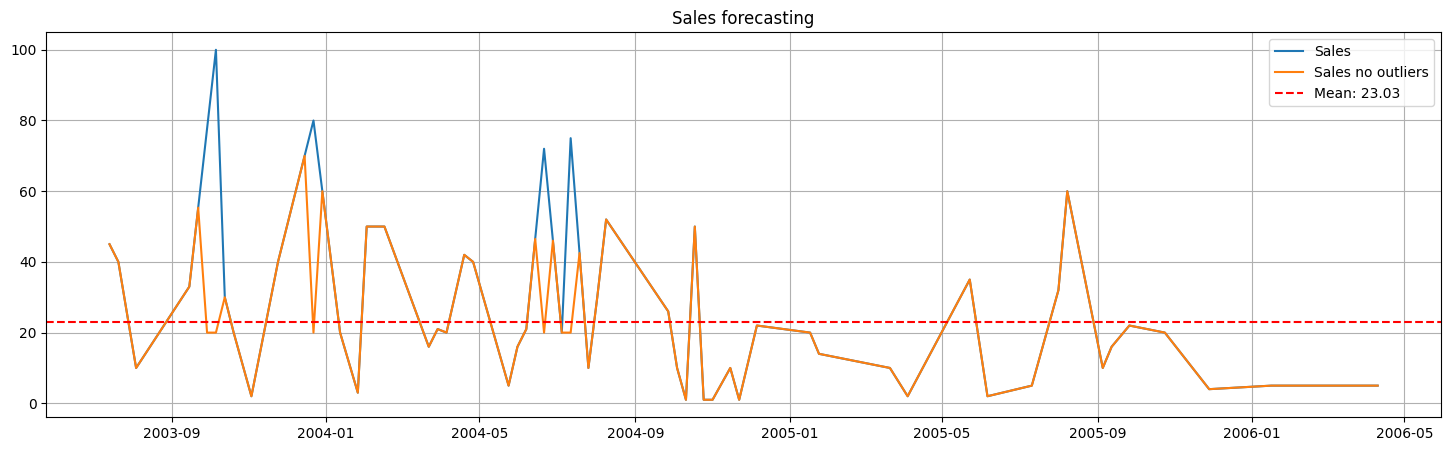

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  2.142857142857143
Mean : 23.93984962406015, Median: 11.0


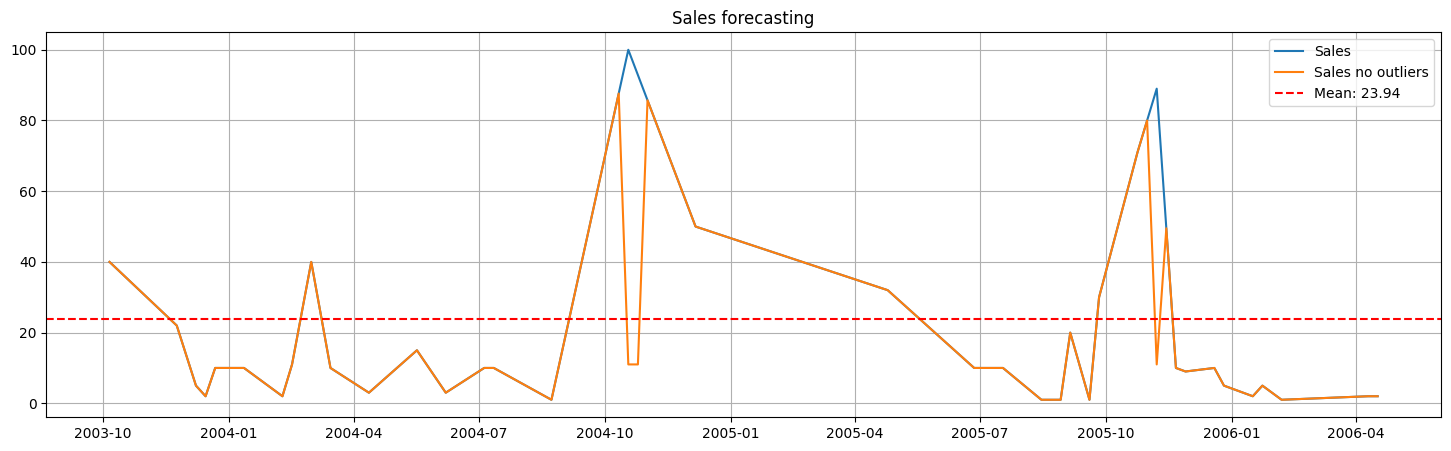

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:47:24 - cmdstanpy - INFO - Chain [1] start processing
13:47:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  2.7586206896551726
Mean : 14.227586206896552, Median: 10.0


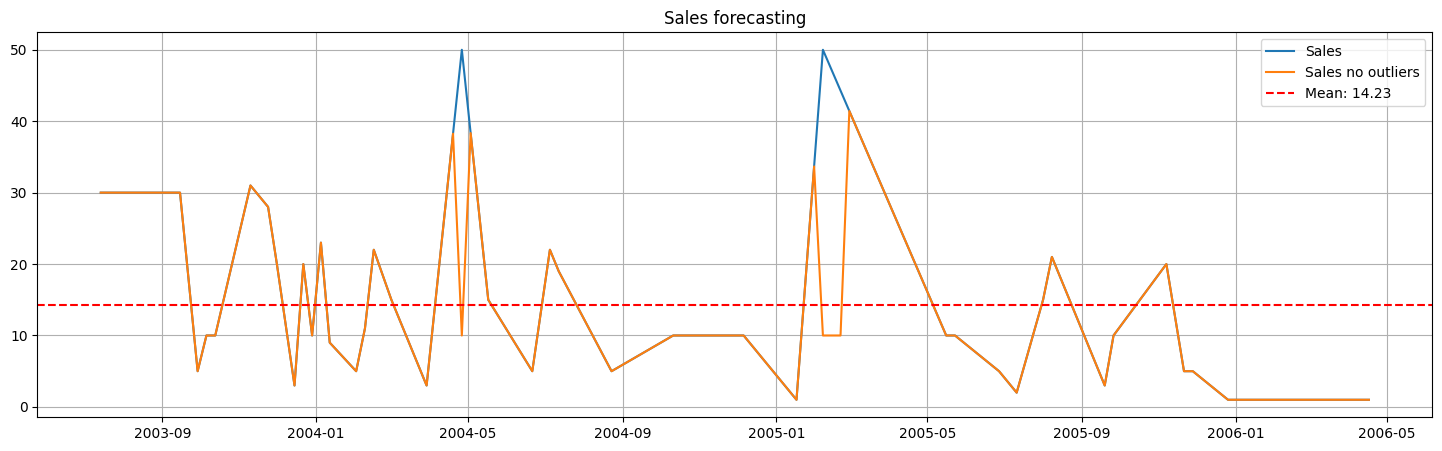

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:47:27 - cmdstanpy - INFO - Chain [1] start processing
13:47:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  9.027777777777777
Mean : 16.895833333333332, Median: 10.5


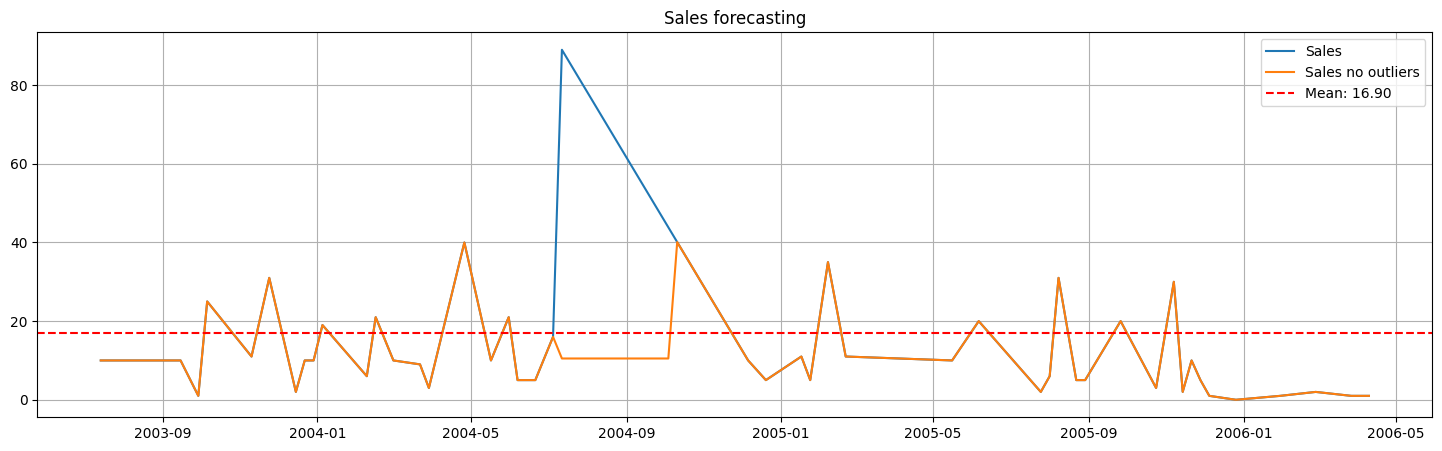

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  6.896551724137931
Mean : 12.63103448275862, Median: 9.2


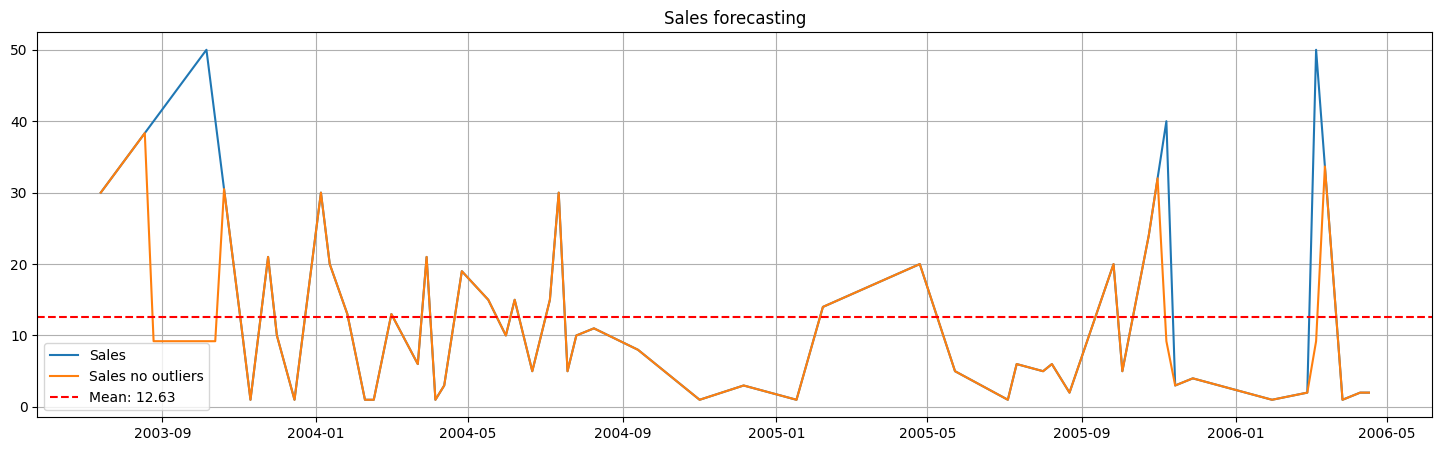

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:47:35 - cmdstanpy - INFO - Chain [1] start processing
13:47:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  0.6993006993006993
Mean : 12.972027972027972, Median: 10.0


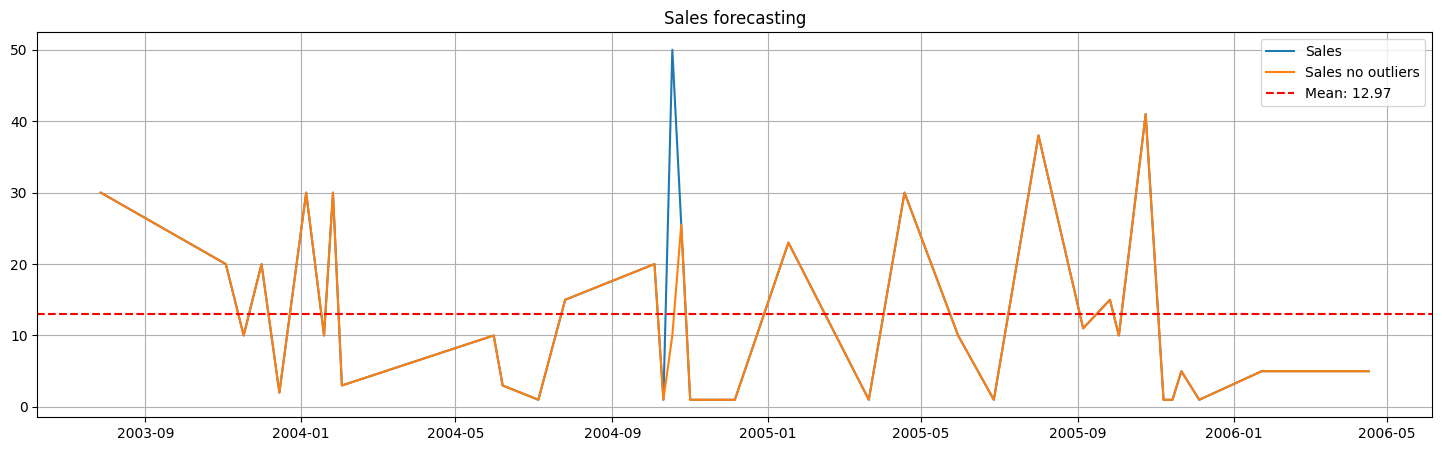

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:47:38 - cmdstanpy - INFO - Chain [1] start processing
13:47:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  2.083333333333333
Mean : 11.093984962406015, Median: 10.0


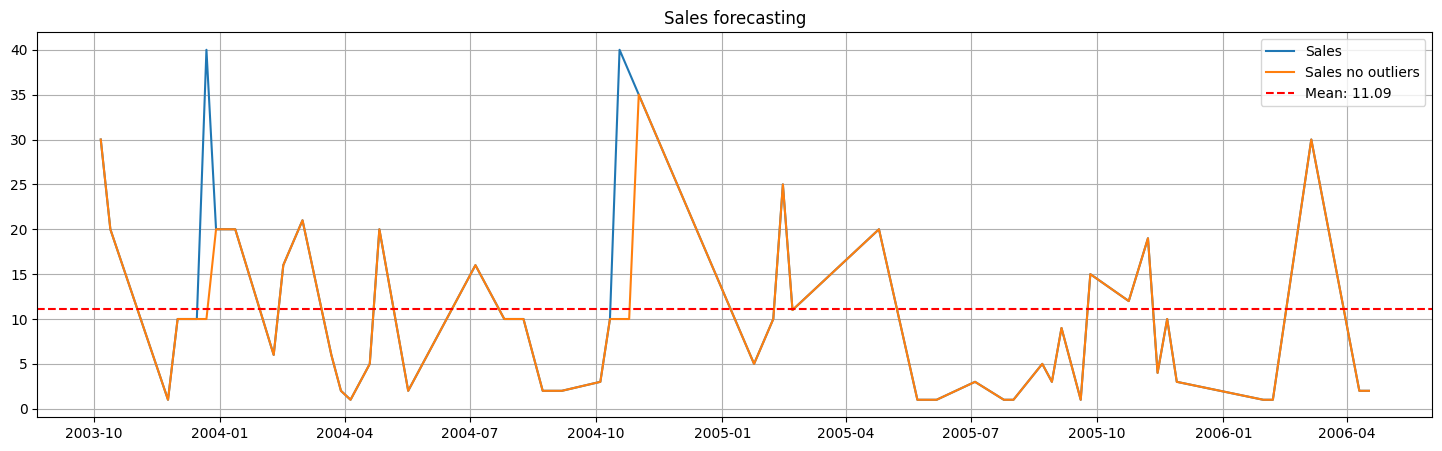

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  10.0
Mean : 15.264492753623188, Median: 11.850000000000001


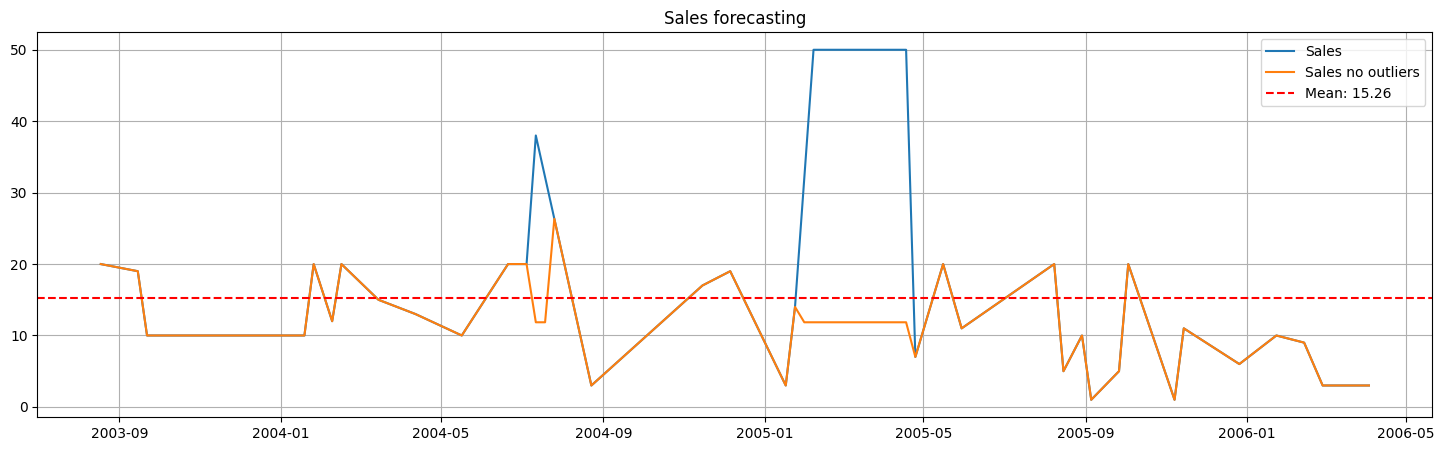

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Percentage outliers:  5.0
Mean : 9.557142857142857, Median: 7.660714285714286


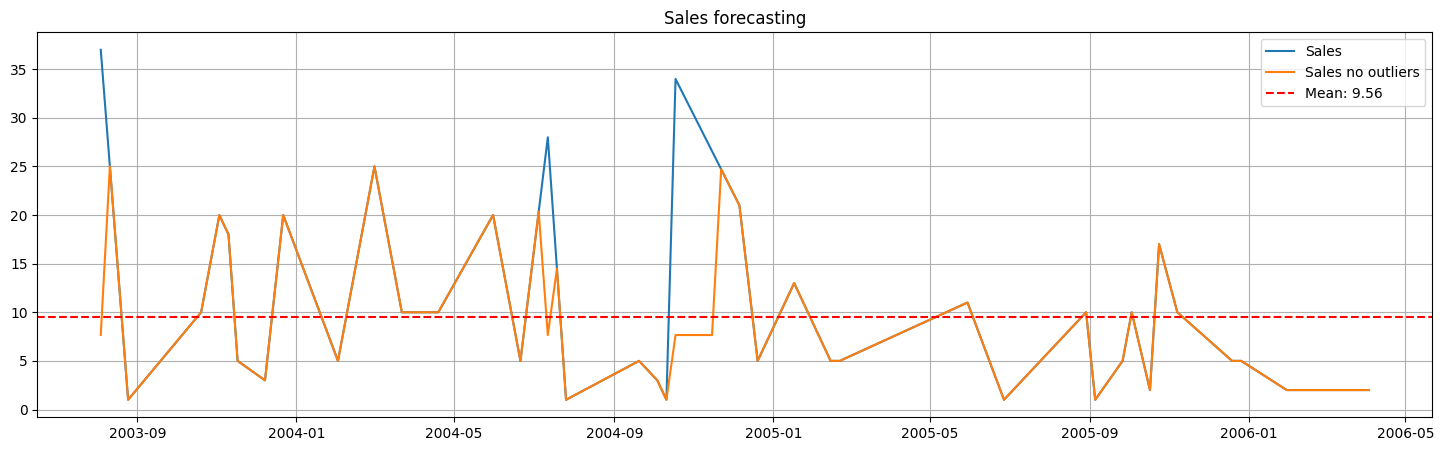

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:47:52 - cmdstanpy - INFO - Chain [1] start processing
13:47:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  2.083333333333333
Mean : 7.128472222222222, Median: 6.0


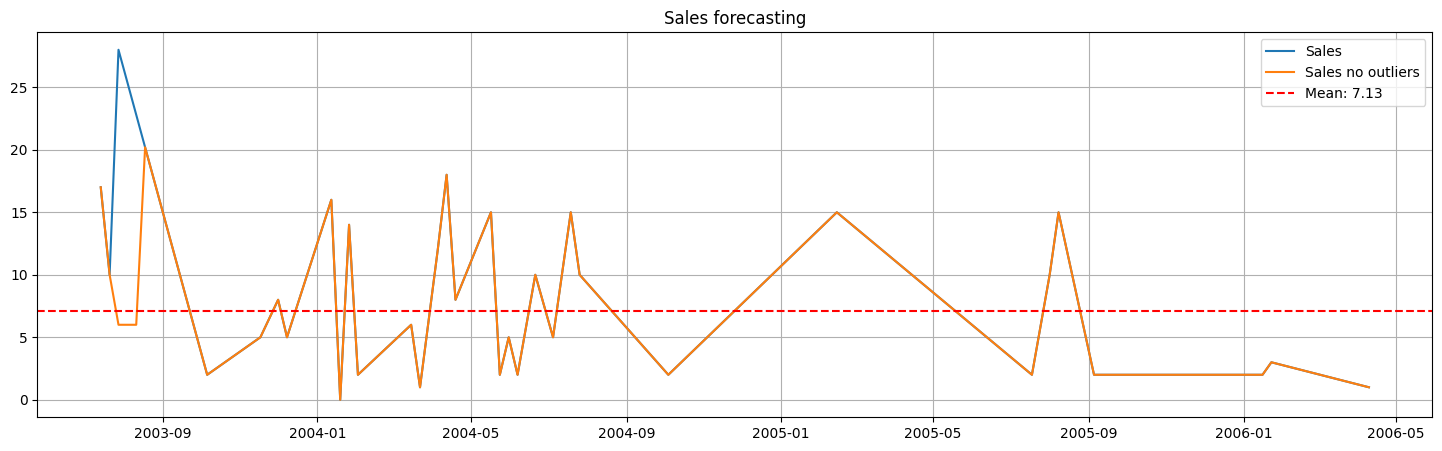

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  4.25531914893617
Mean : 11.996402877697841, Median: 10.0


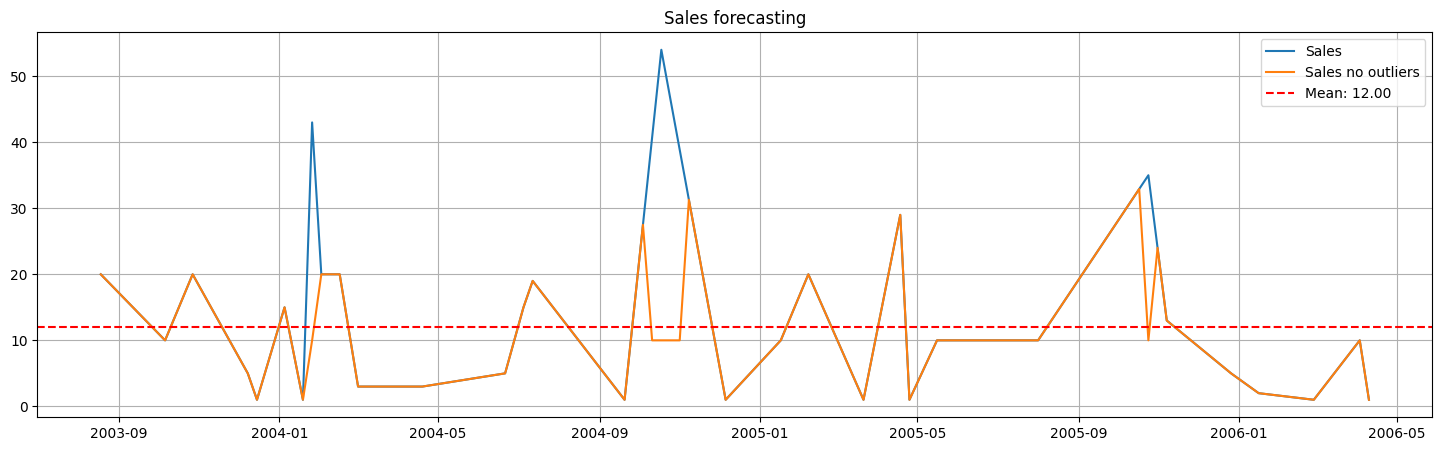

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:48:01 - cmdstanpy - INFO - Chain [1] start processing
13:48:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  6.338028169014084
Mean : 8.354700854700855, Median: 7.0


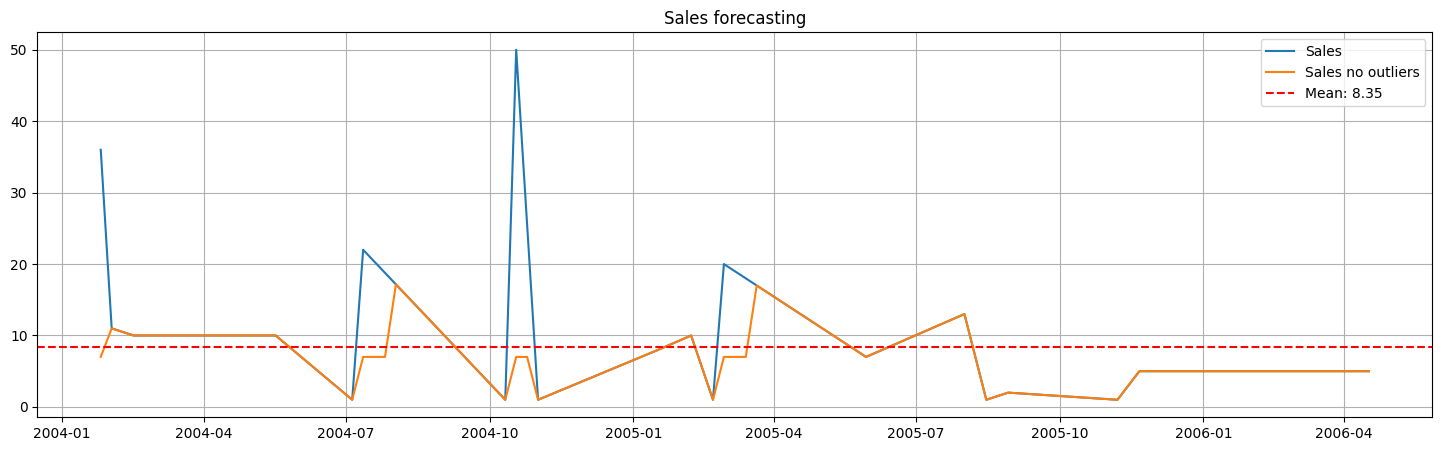

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:48:03 - cmdstanpy - INFO - Chain [1] start processing
13:48:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  0.0
Mean : 12.299295774647888, Median: 7.964285714285716


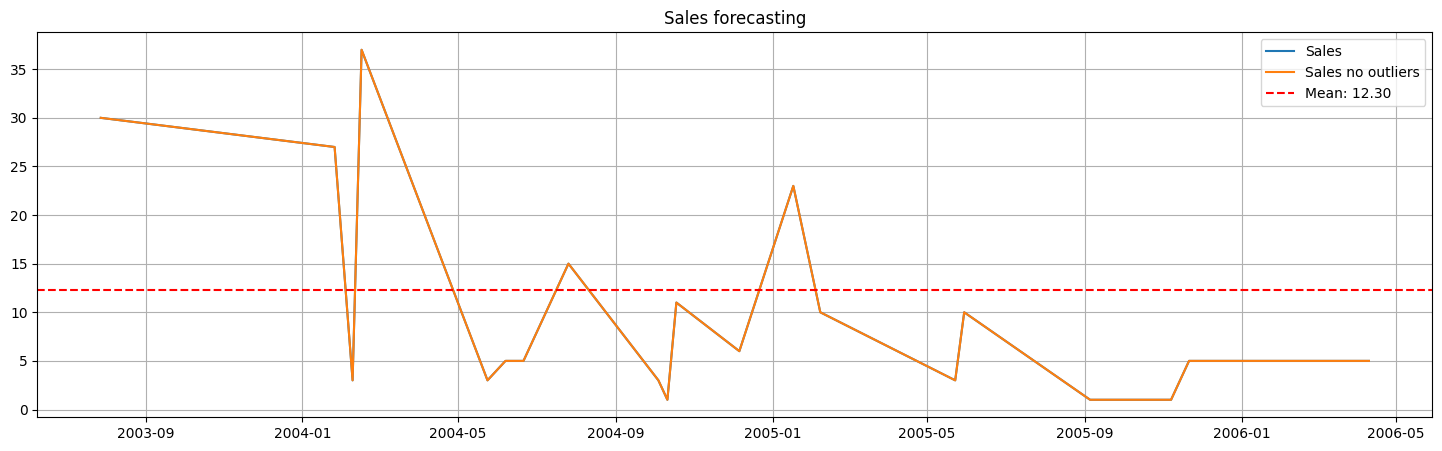

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  5.714285714285714
Mean : 8.325, Median: 7.2214285714285715


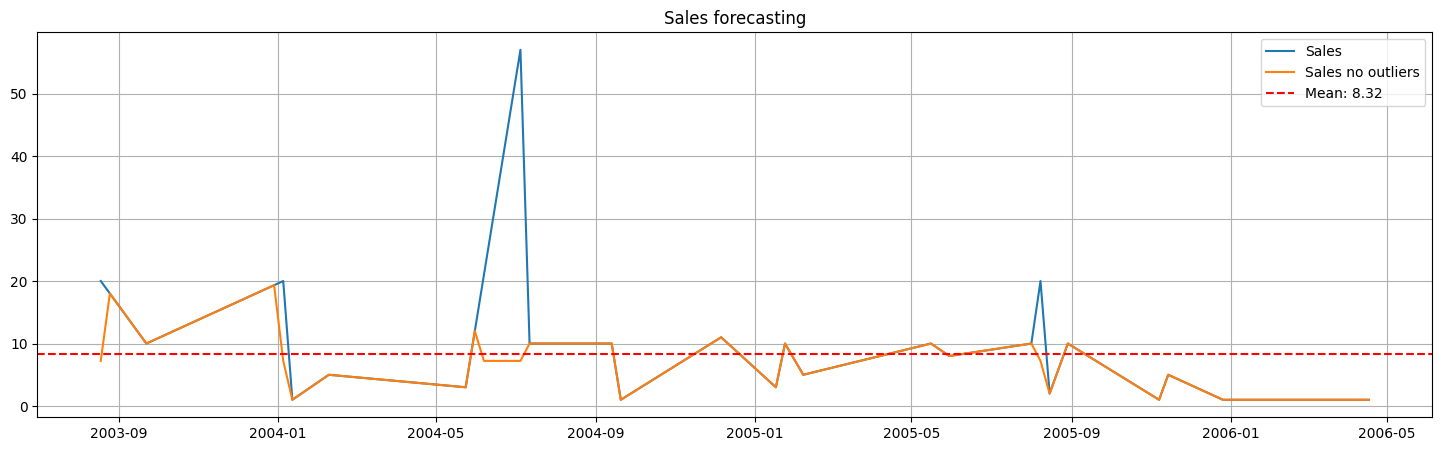

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:48:11 - cmdstanpy - INFO - Chain [1] start processing
13:48:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  4.964539007092199
Mean : 10.23049645390071, Median: 7.703703703703704


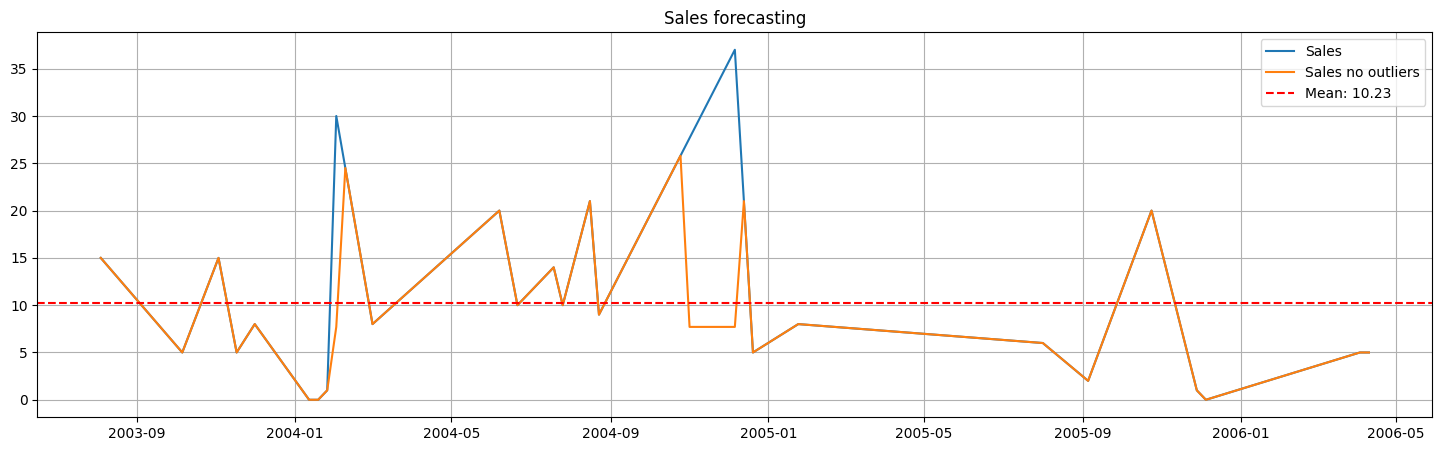

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:48:15 - cmdstanpy - INFO - Chain [1] start processing
13:48:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  10.37037037037037
Mean : 11.055555555555555, Median: 10.214285714285714


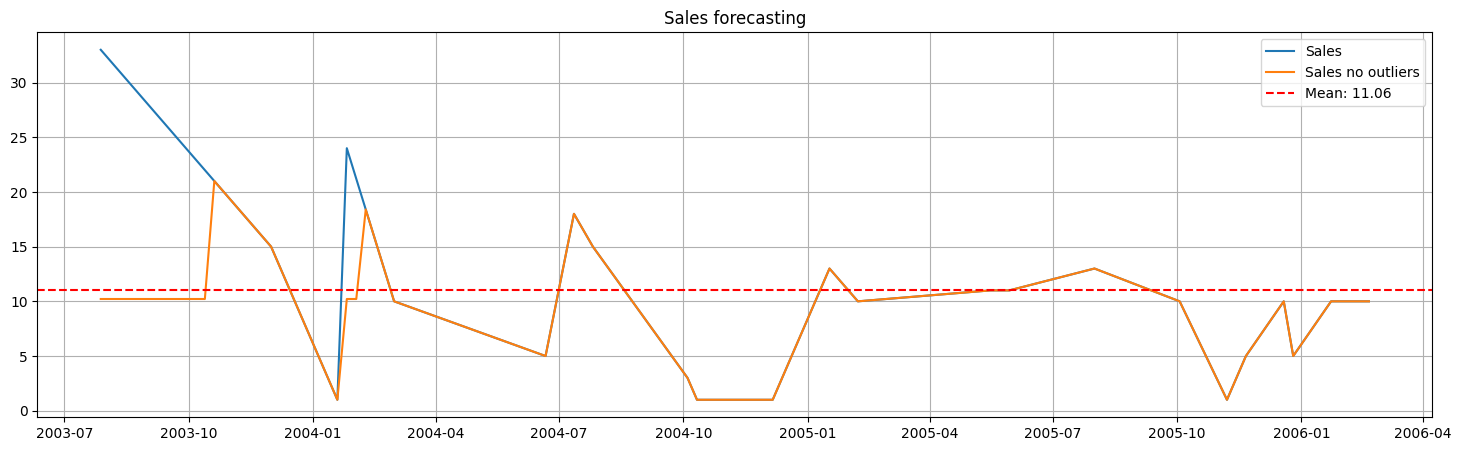

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:48:20 - cmdstanpy - INFO - Chain [1] start processing
13:48:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  4.195804195804196
Mean : 12.517482517482517, Median: 10.357142857142858


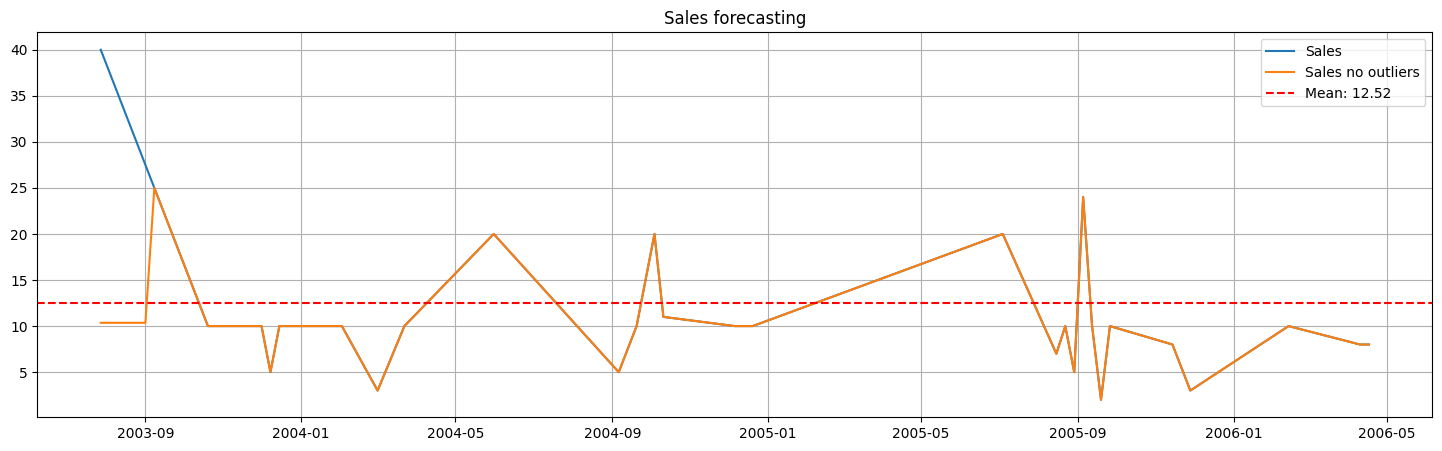

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:48:22 - cmdstanpy - INFO - Chain [1] start processing
13:48:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  2.8368794326241136
Mean : 11.542307692307693, Median: 10.0


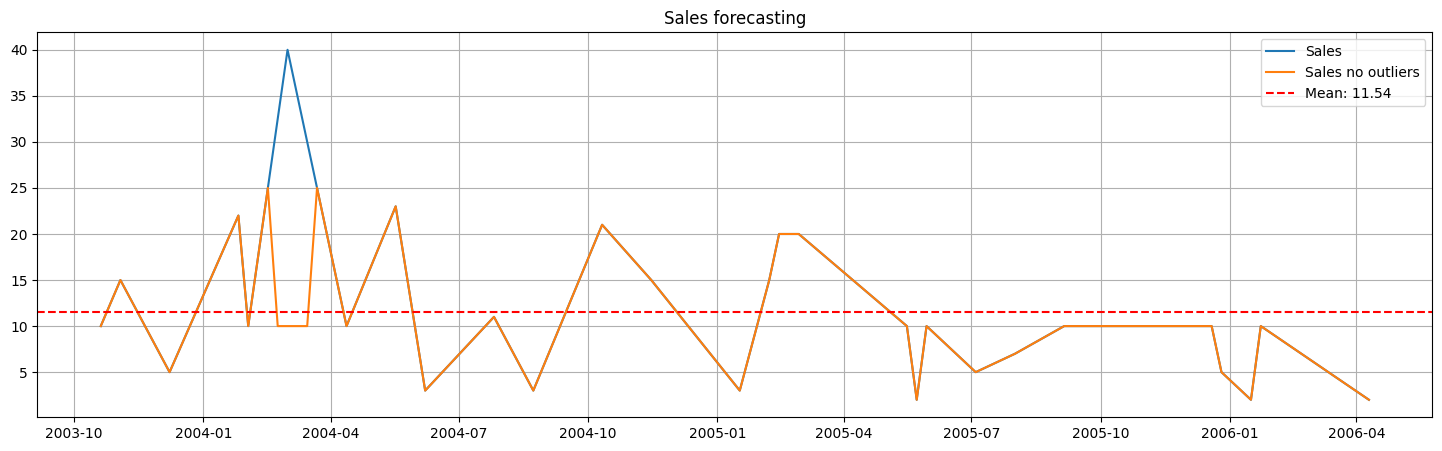

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py

Percentage outliers:  0.0
Mean : 3.9131944444444446, Median: 1.8730158730158732


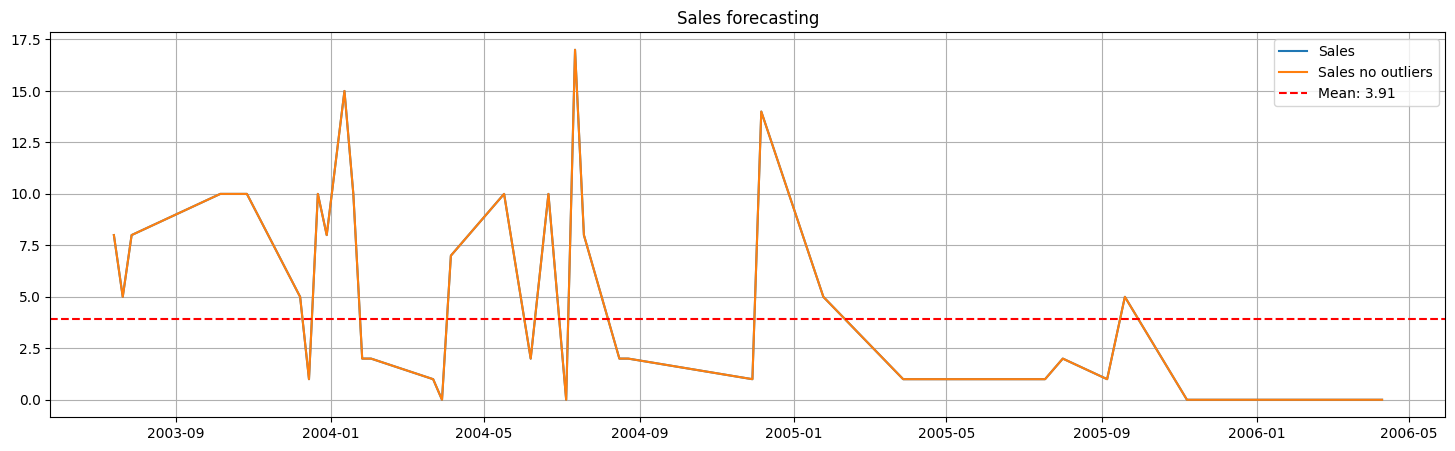

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:48:33 - cmdstanpy - INFO - Chain [1] start processing
13:48:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  0.7518796992481203
Mean : 10.86111111111111, Median: 10.0


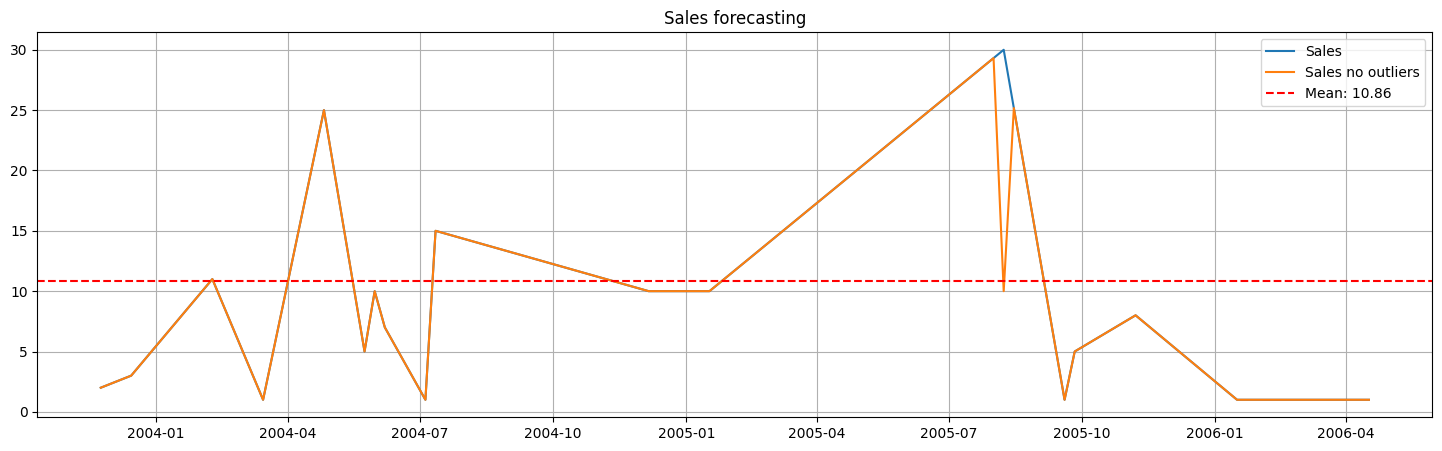

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:48:35 - cmdstanpy - INFO - Chain [1] start processing
13:48:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  14.705882352941178
Mean : 5.46969696969697, Median: 2.4642857142857144


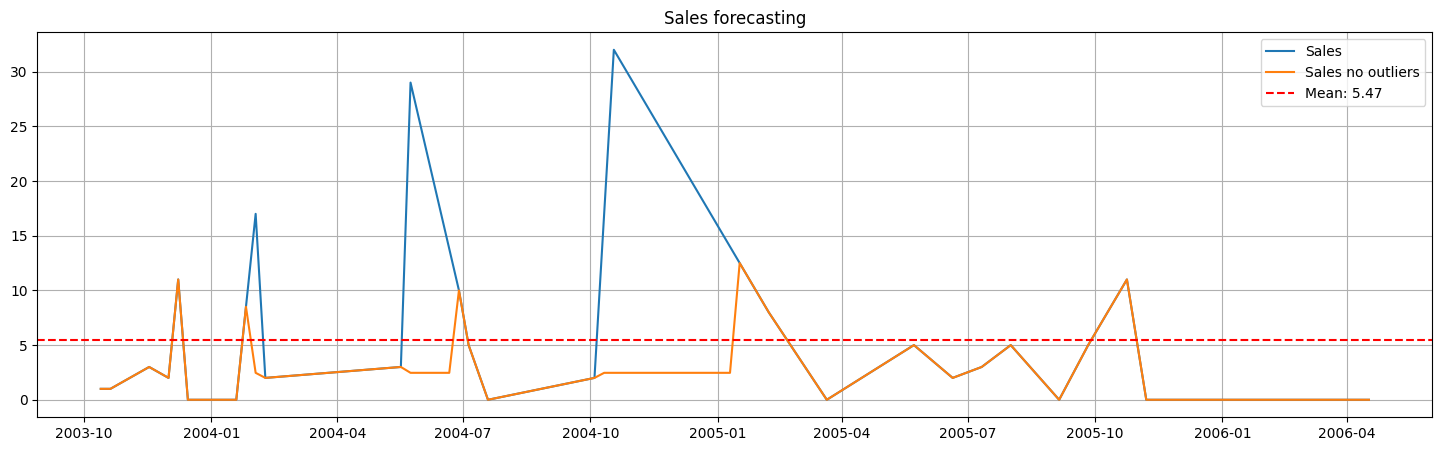

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipy

Percentage outliers:  0.6993006993006993
Mean : 13.234615384615385, Median: 6.0


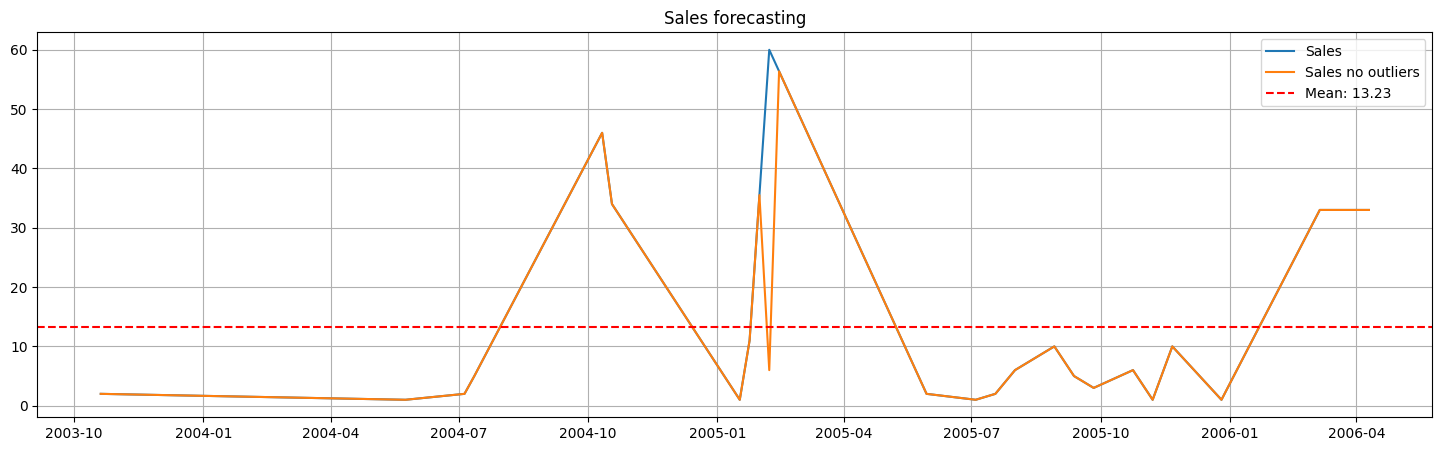

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:48:45 - cmdstanpy - INFO - Chain [1] start processing
13:48:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  1.4084507042253522
Mean : 9.753521126760564, Median: 8.40625


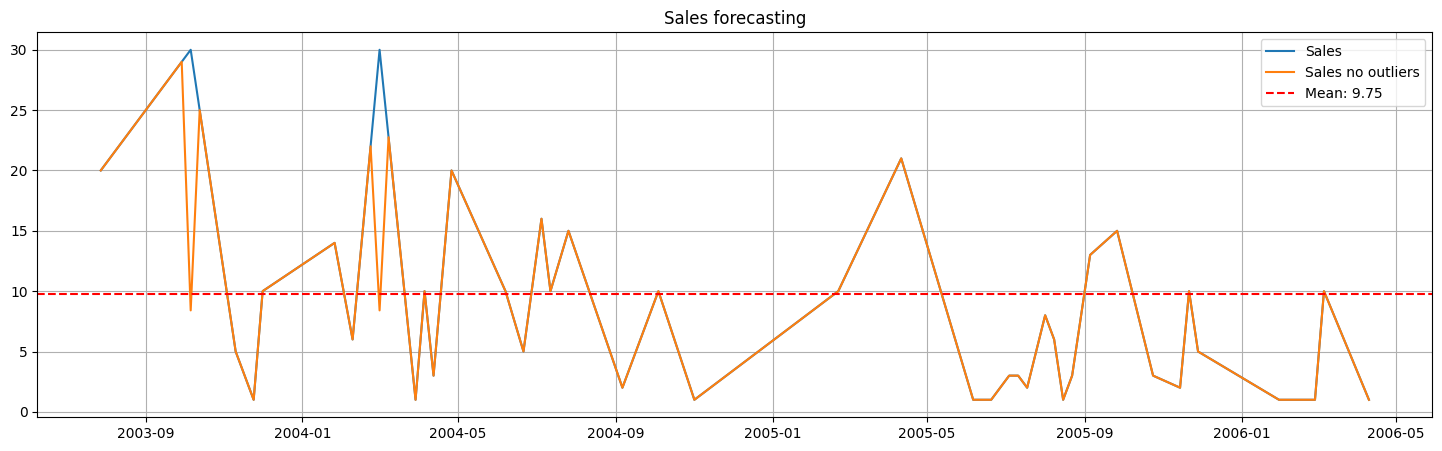

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  6.382978723404255
Mean : 6.438848920863309, Median: 5.0


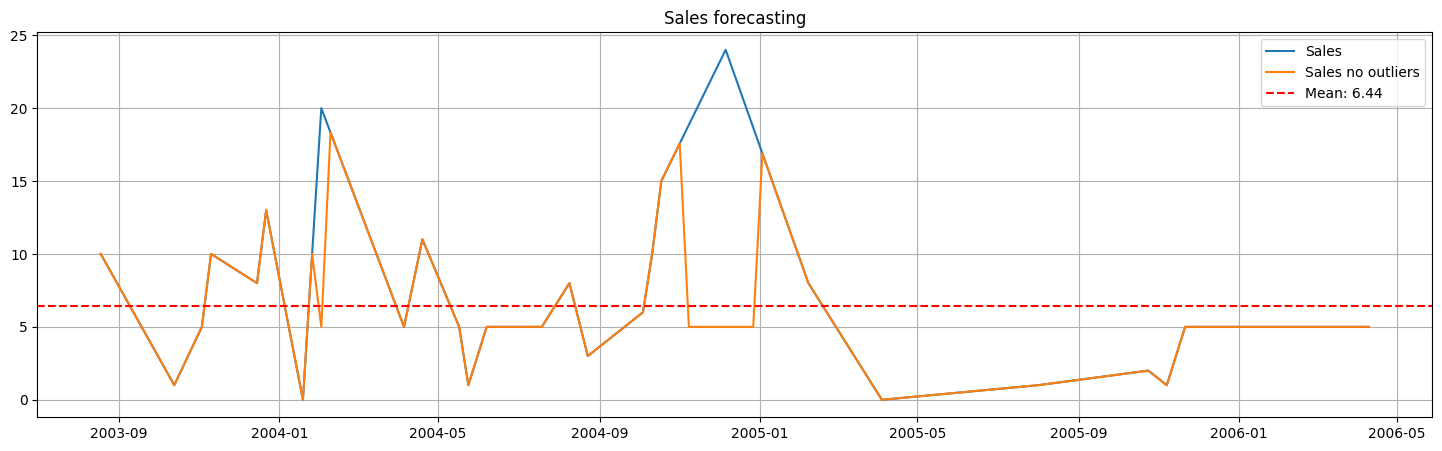

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipy

Percentage outliers:  0.0
Mean : 4.441860465116279, Median: 5.0


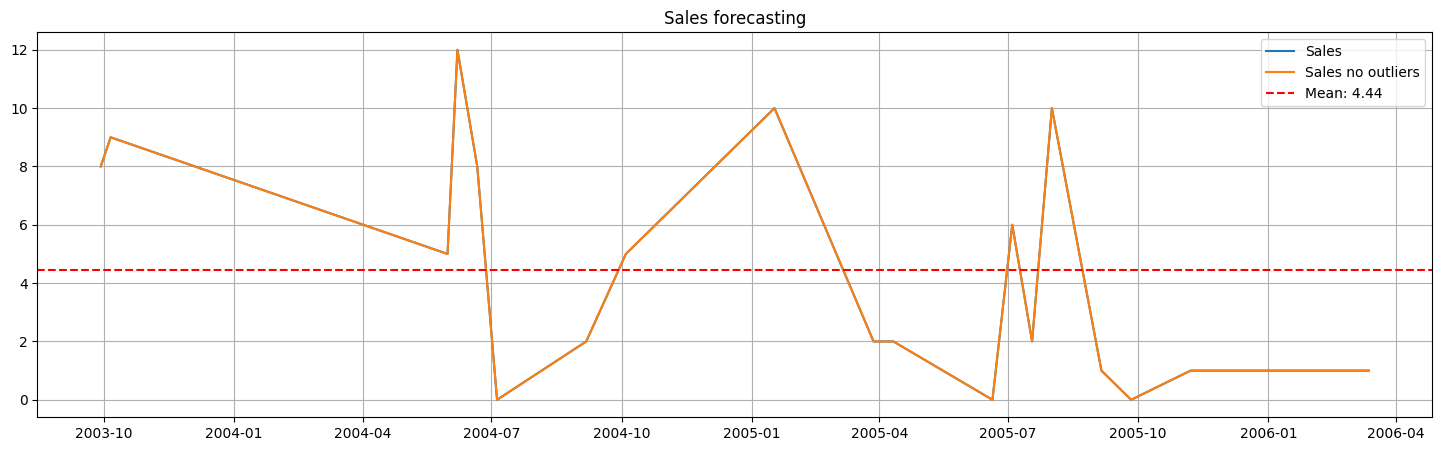

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Percentage outliers:  11.510791366906476
Mean : 6.651079136690647, Median: 5.0


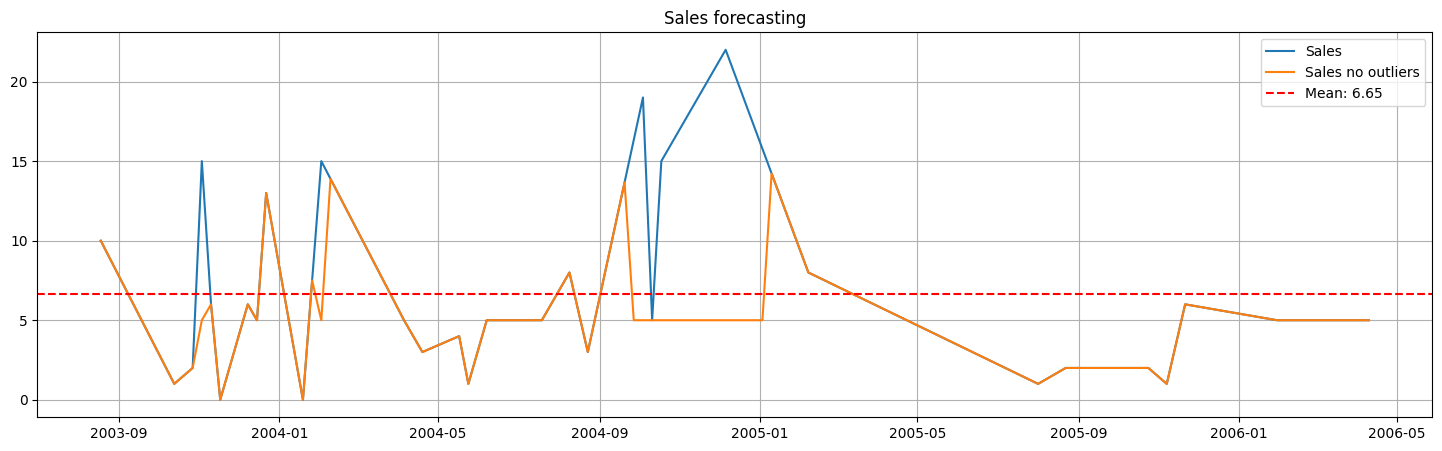

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py

Percentage outliers:  7.857142857142857
Mean : 10.170634920634921, Median: 7.341346153846154


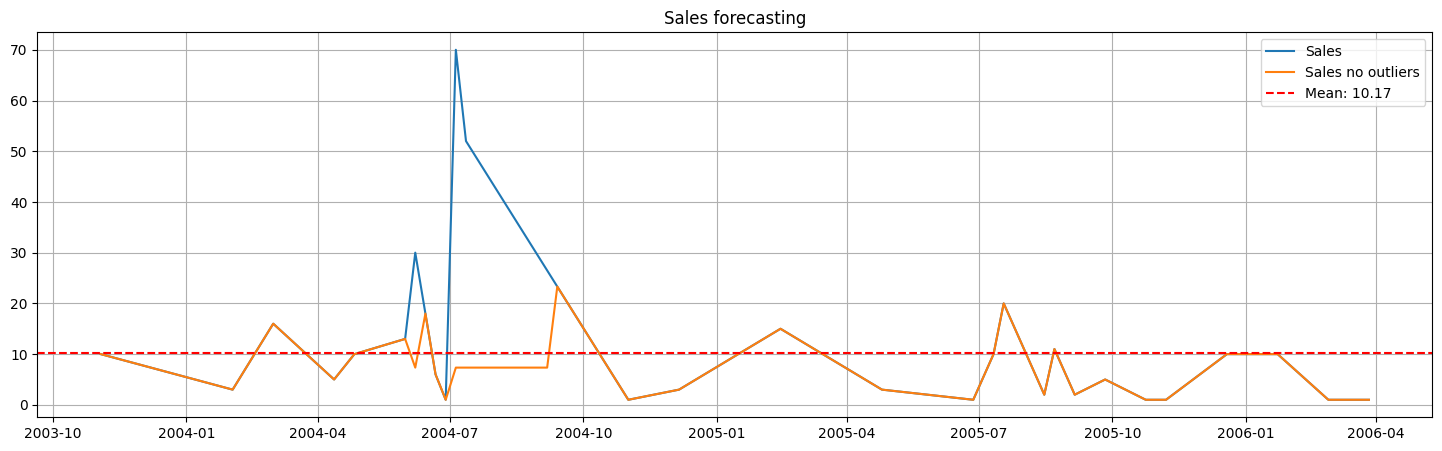

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipy

Percentage outliers:  7.246376811594203
Mean : 5.11231884057971, Median: 4.0


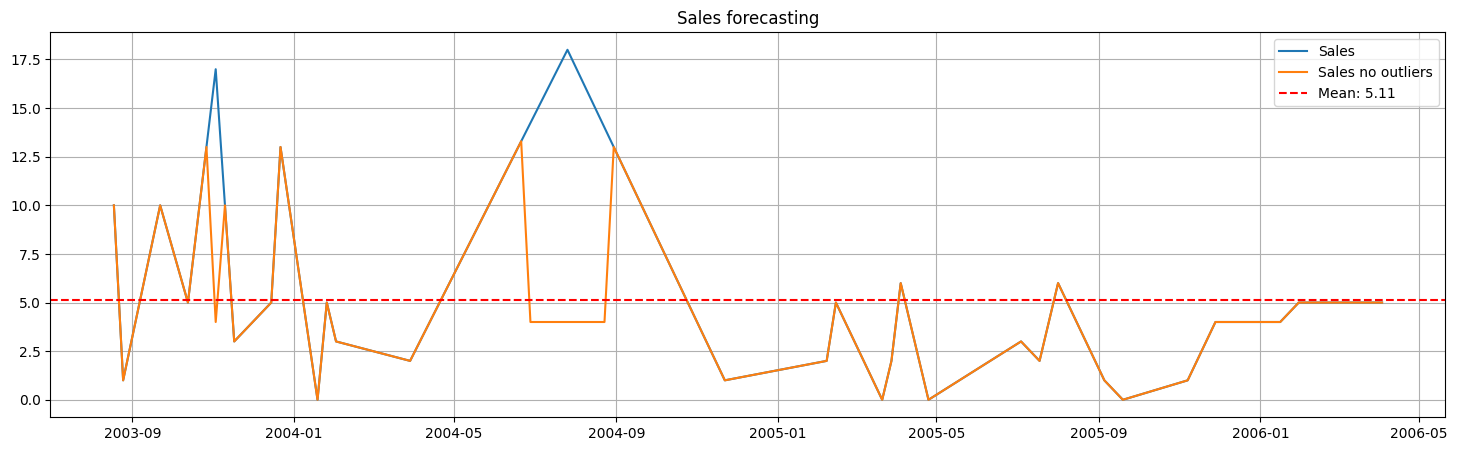

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  2.127659574468085
Mean : 2.7964285714285713, Median: 2.0


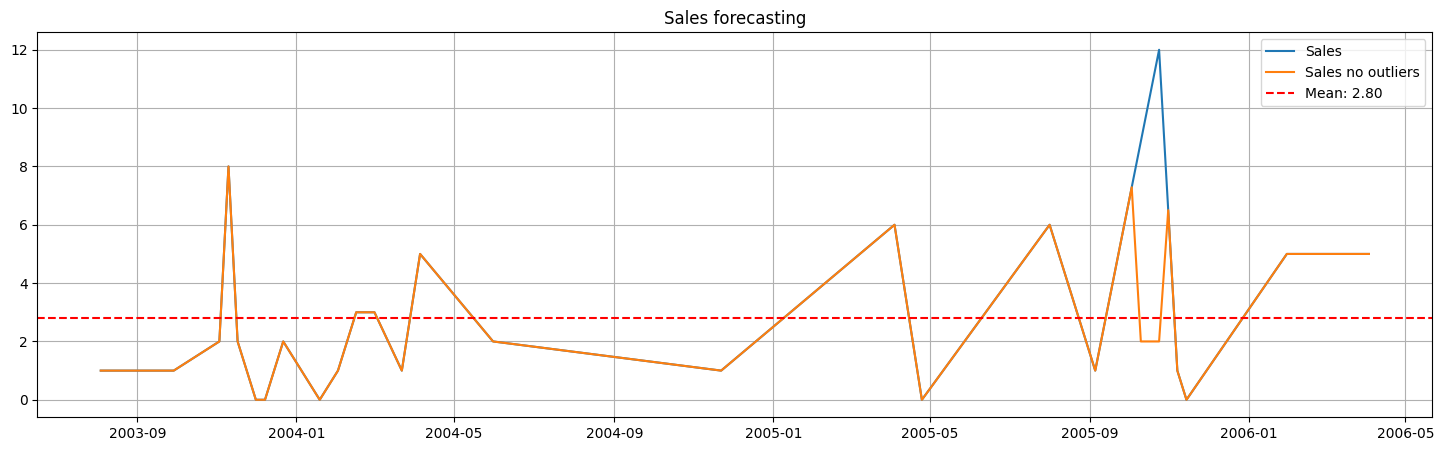

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:49:12 - cmdstanpy - INFO - Chain [1] start processing
13:49:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  7.746478873239436
Mean : 8.134057971014492, Median: 5.773809523809524


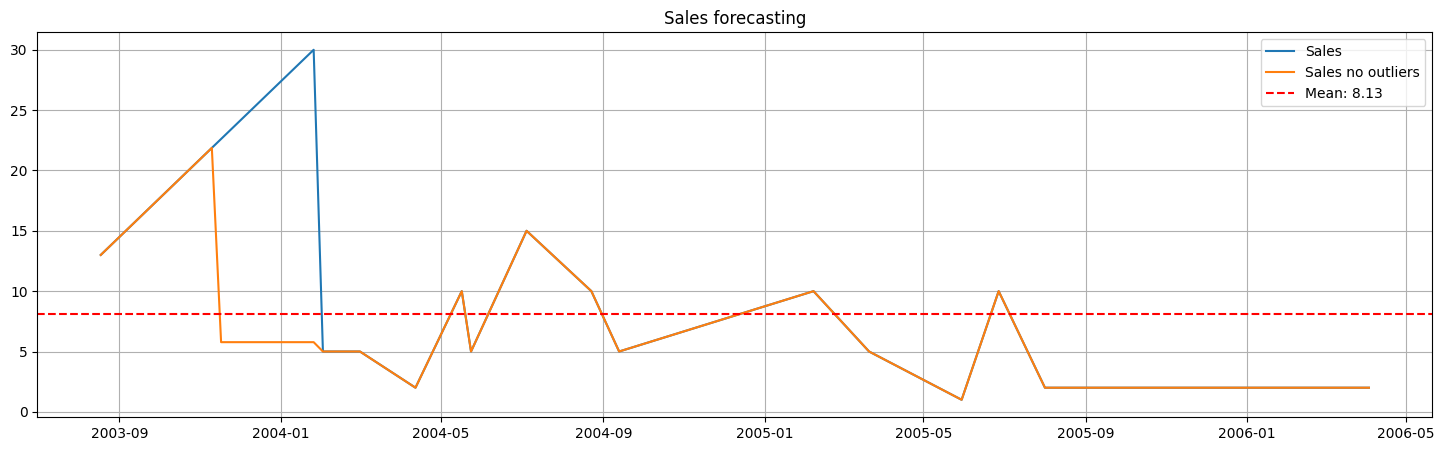

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  5.0
Mean : 9.924778761061948, Median: 5.0


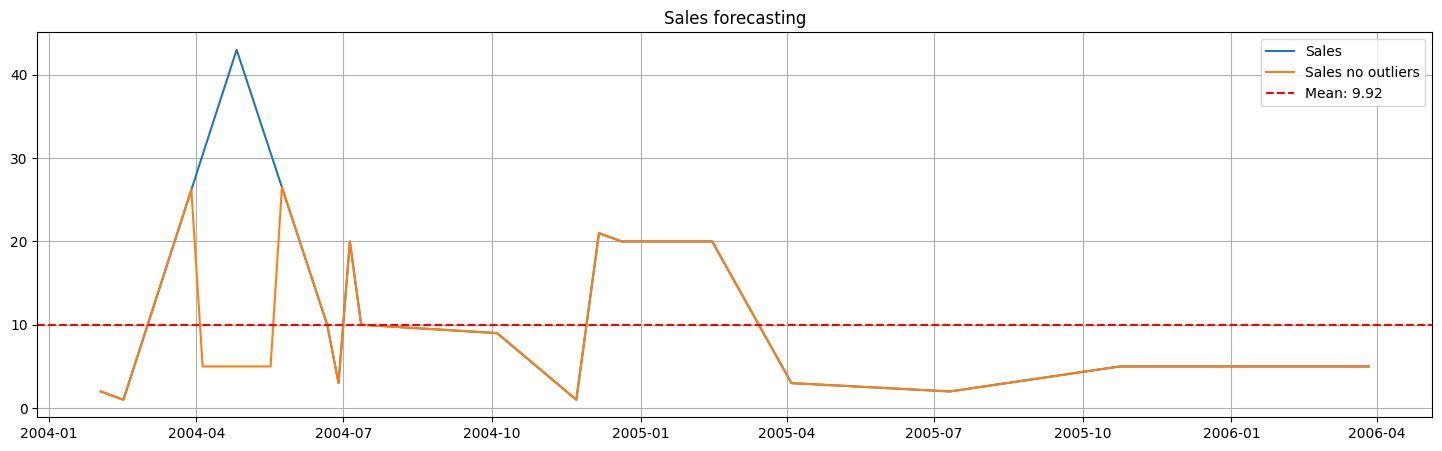

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:49:23 - cmdstanpy - INFO - Chain [1] start processing
13:49:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  7.2992700729927
Mean : 12.121951219512194, Median: 10.11111111111111


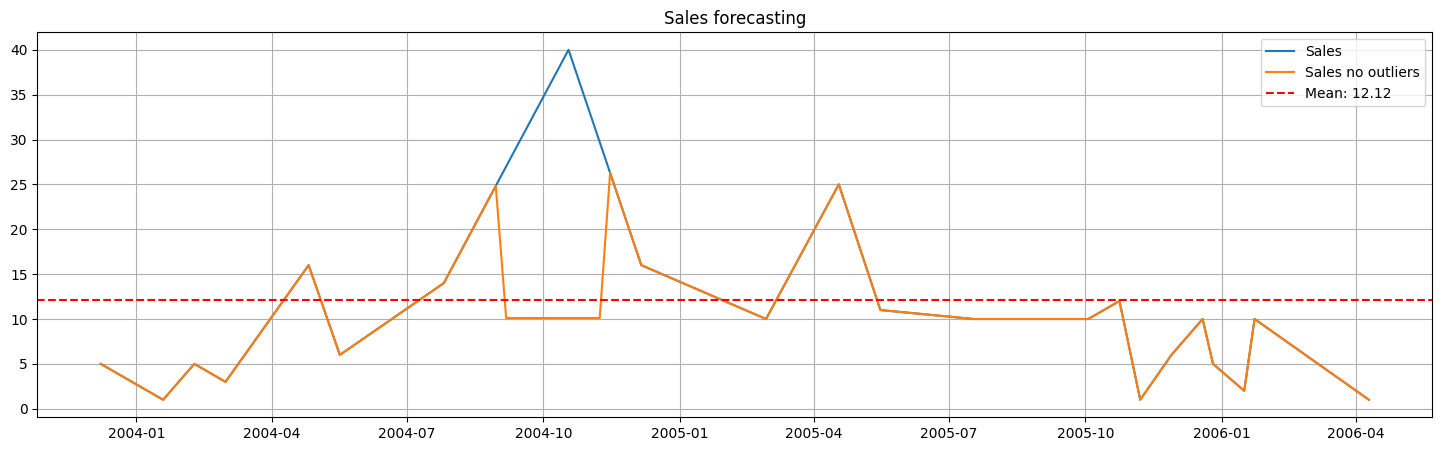

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  0.0
Mean : 9.69767441860465, Median: 10.0


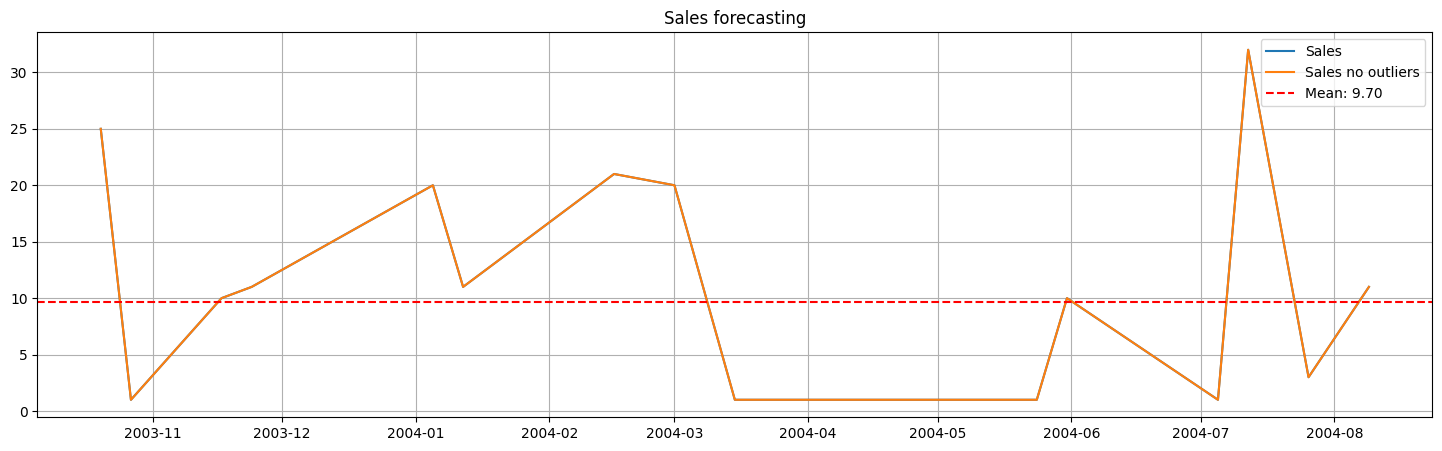

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Us

Percentage outliers:  2.9850746268656714
Mean : 8.1, Median: 6.5


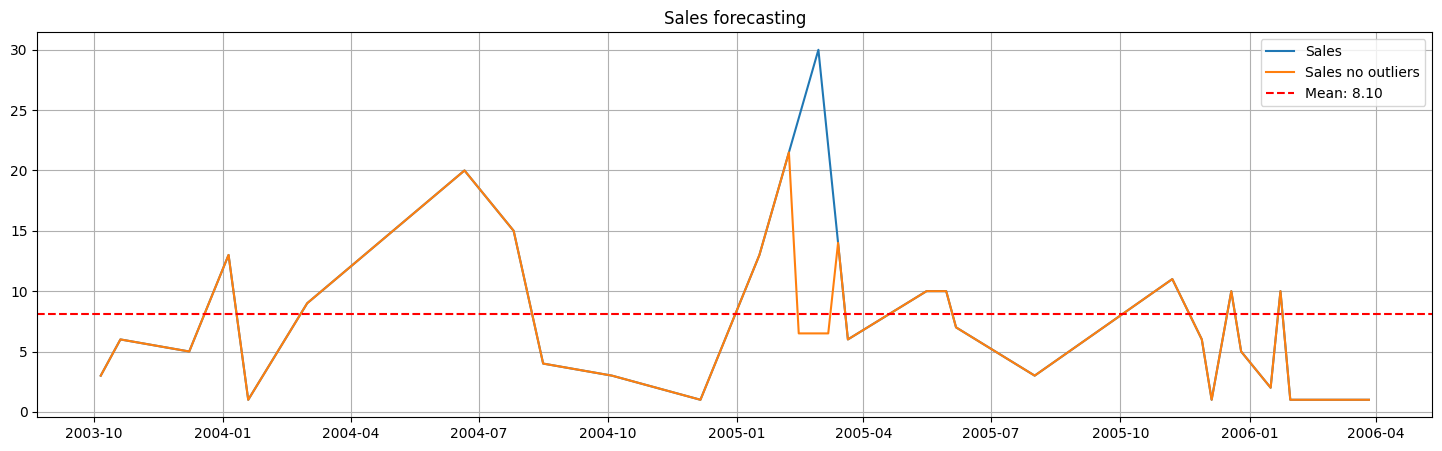

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipy

Percentage outliers:  0.7142857142857143
Mean : 12.549618320610687, Median: 11.692307692307693


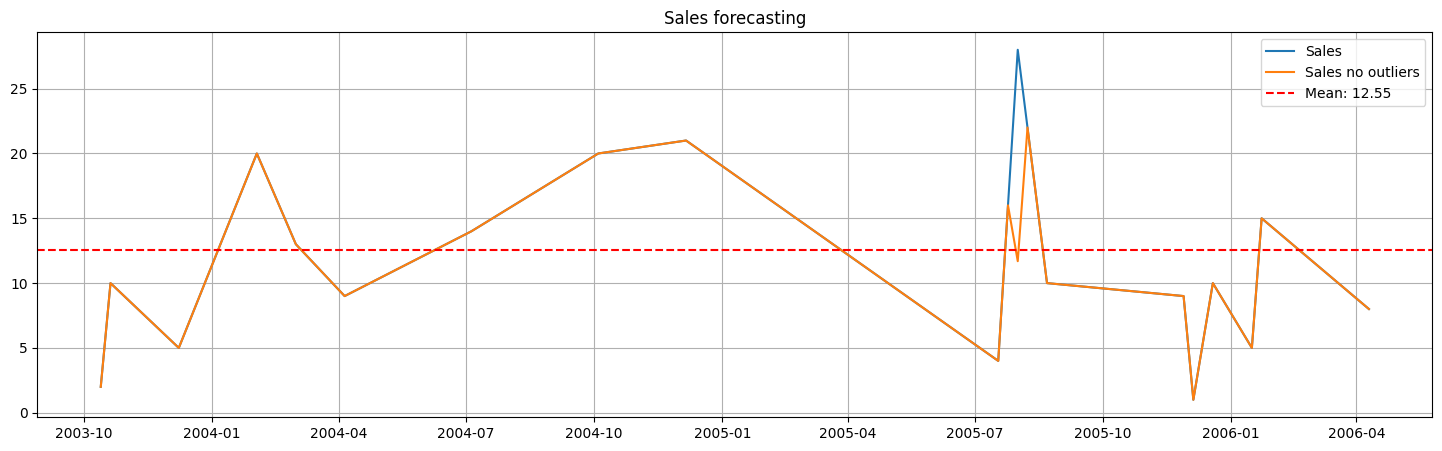

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:49:36 - cmdstanpy - INFO - Chain [1] start processing
13:49:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  5.0
Mean : 1.896103896103896, Median: 1.3333333333333333


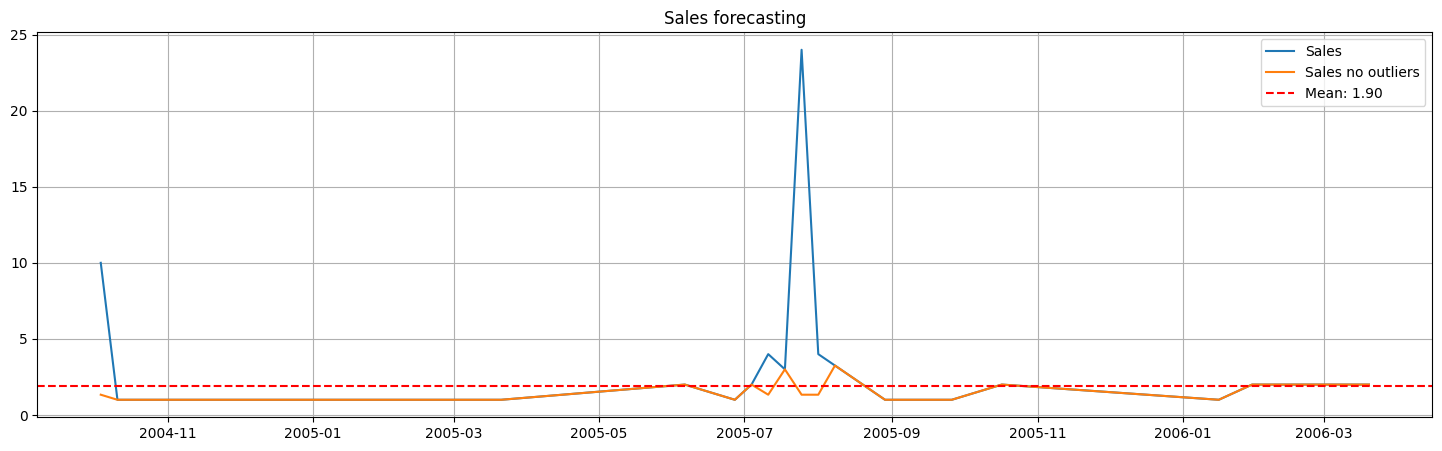

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:49:38 - cmdstanpy - INFO - Chain [1] start processing
13:49:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  18.75
Mean : 8.119565217391305, Median: 3.833333333333333


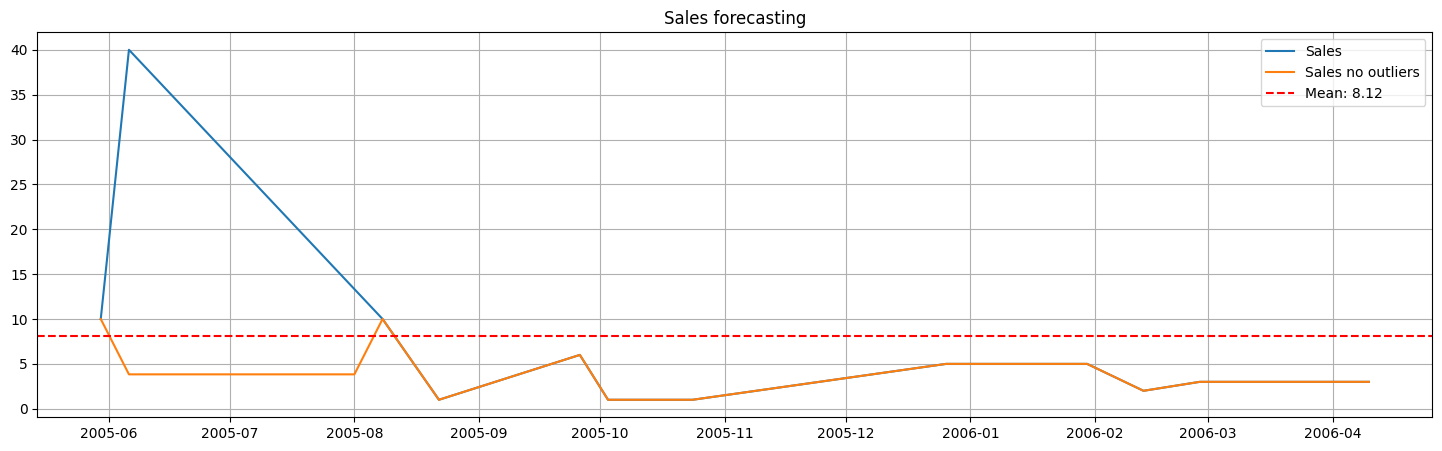

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Us

Percentage outliers:  11.971830985915492
Mean : 8.144366197183098, Median: 8.0


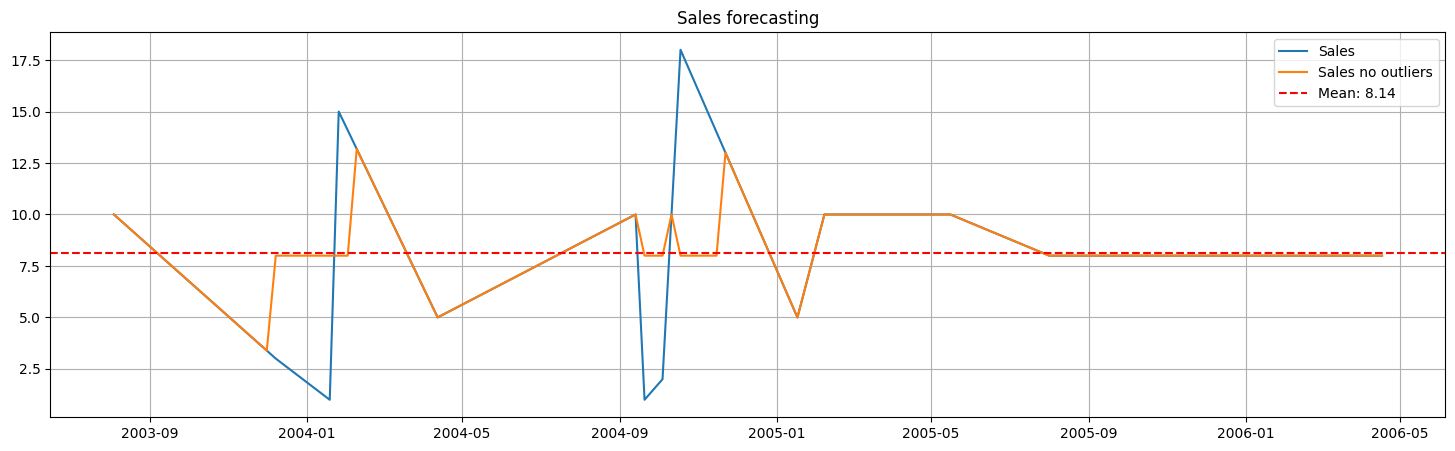

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Carlota\AppData\Local\Programs

Percentage outliers:  6.7669172932330826
Mean : 10.584615384615384, Median: 9.180555555555555


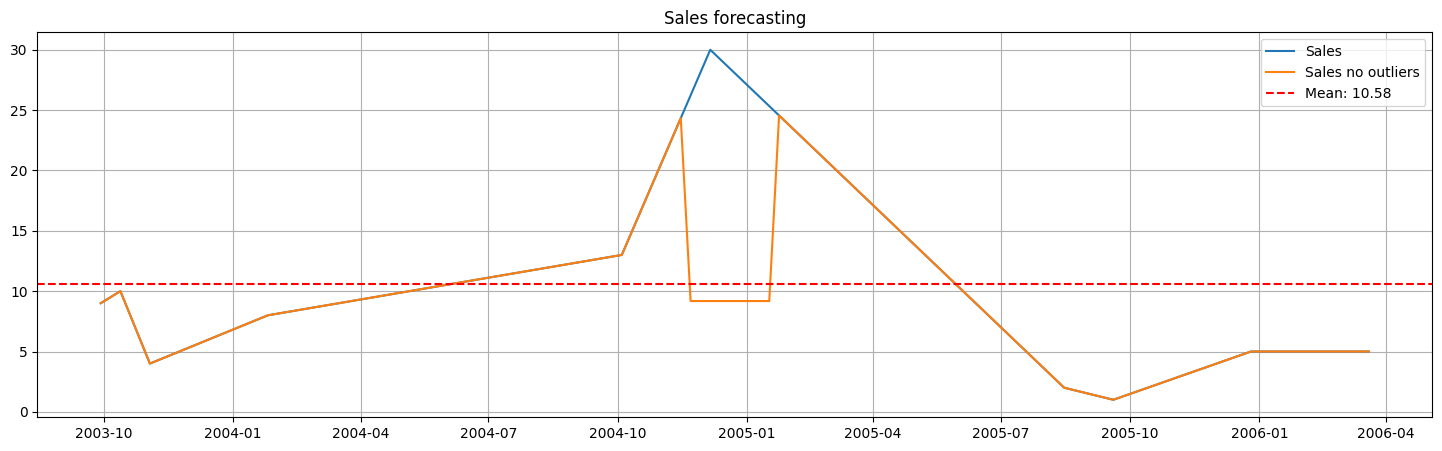

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  0.0
Mean : 12.329787234042554, Median: 11.2


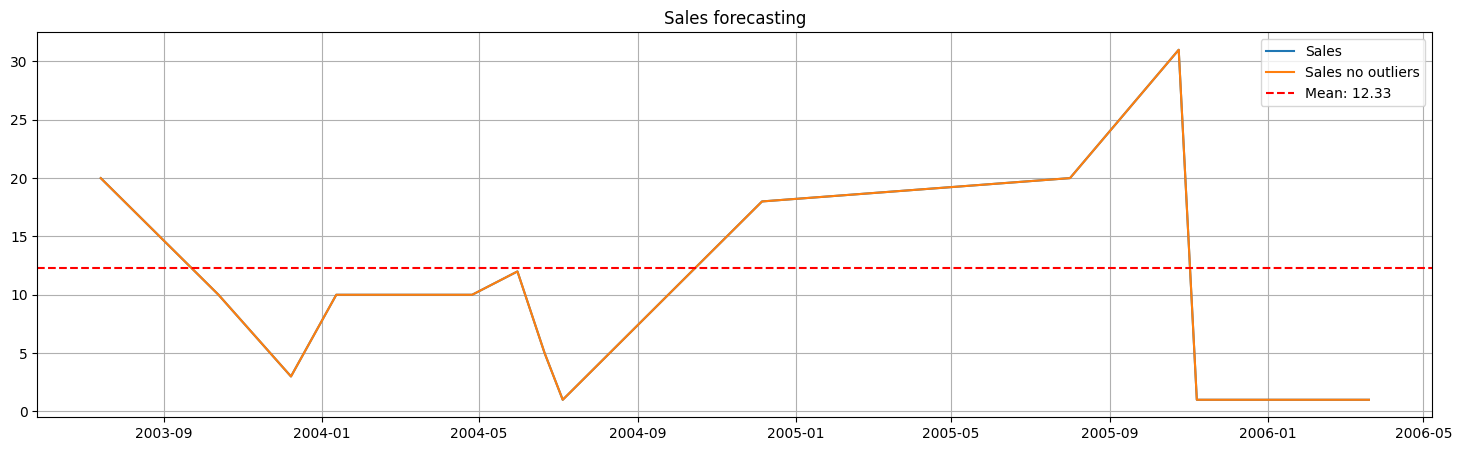

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

Percentage outliers:  0.0
Mean : 2.8686440677966103, Median: 2.416666666666667


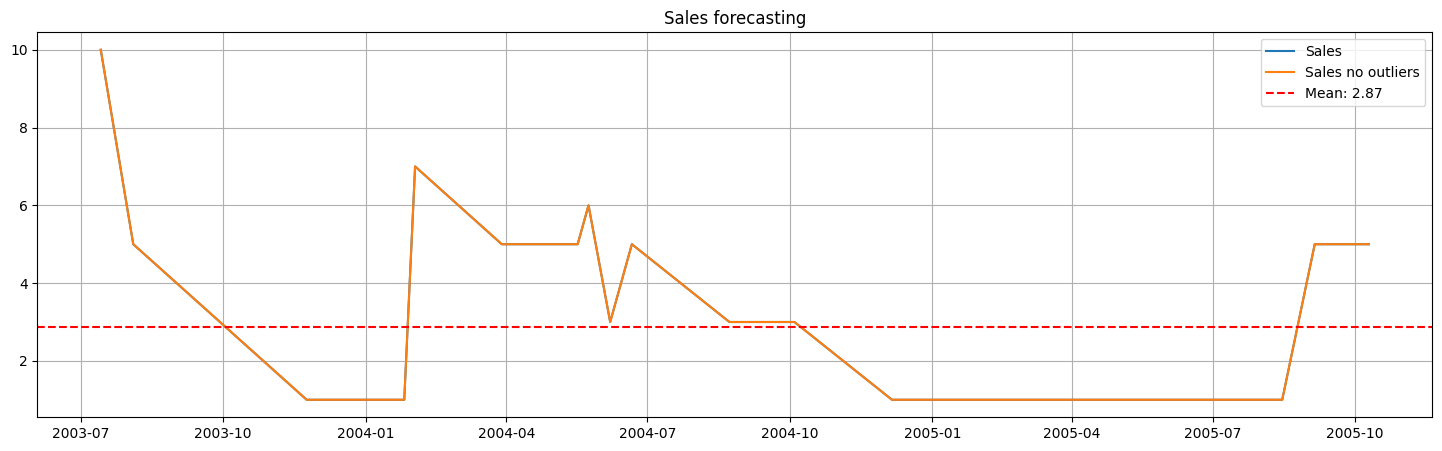

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  4.166666666666666
Mean : 11.22340425531915, Median: 5.714285714285714


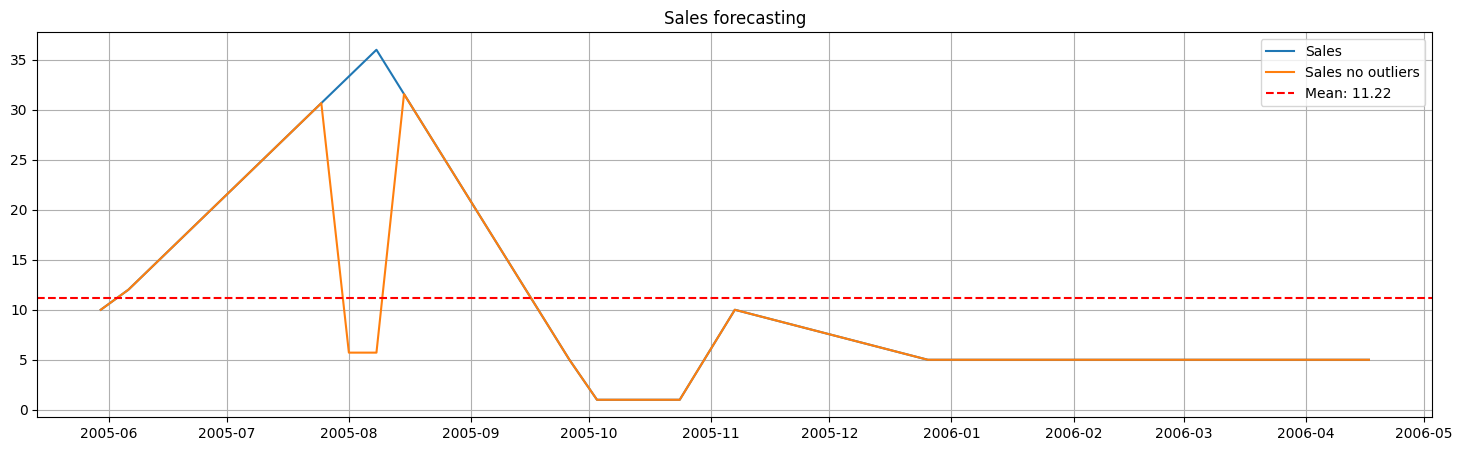

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Us

Percentage outliers:  0.0
Mean : 9.917322834645669, Median: 8.384615384615385


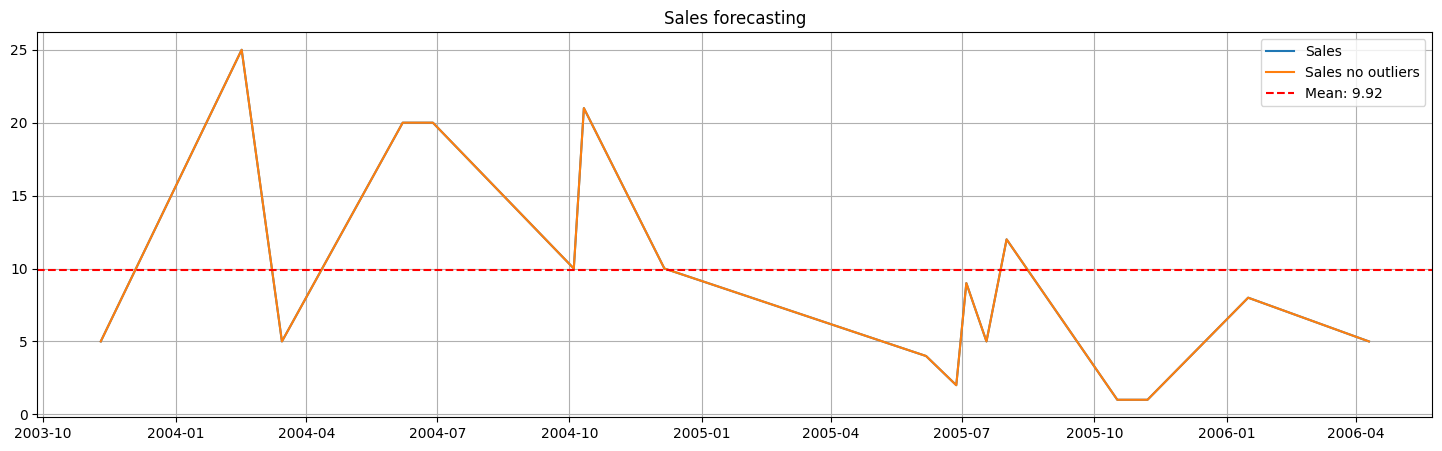

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:50:16 - cmdstanpy - INFO - Chain [1] start processing
13:50:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  3.0303030303030303
Mean : 3.896, Median: 3.0


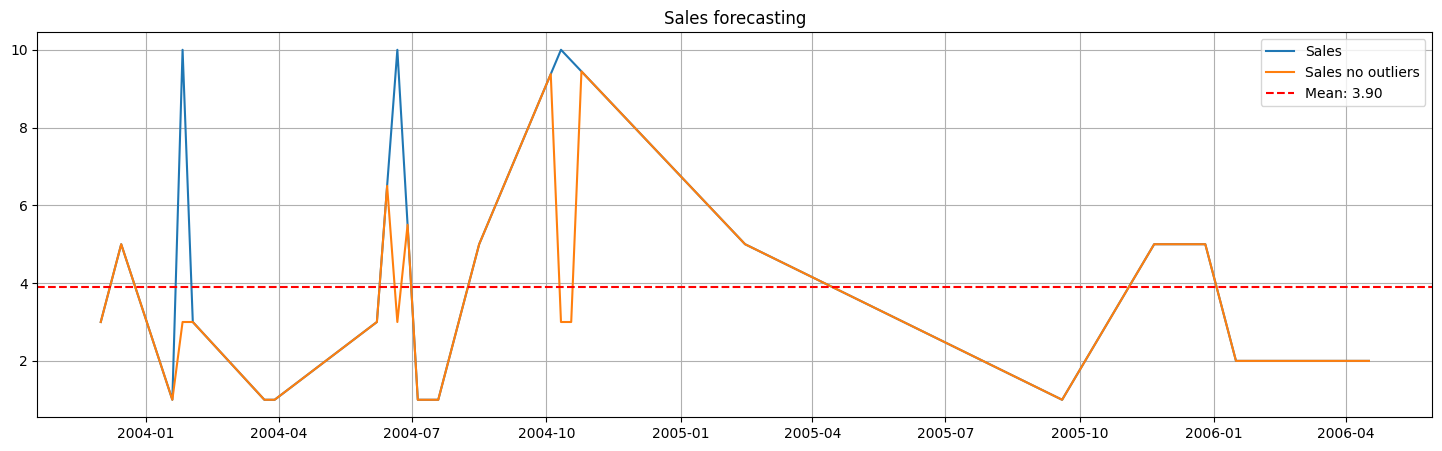

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:50:20 - cmdstanpy - INFO - Chain [1] start processing
13:50:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  7.246376811594203
Mean : 6.090225563909774, Median: 4.354838709677419


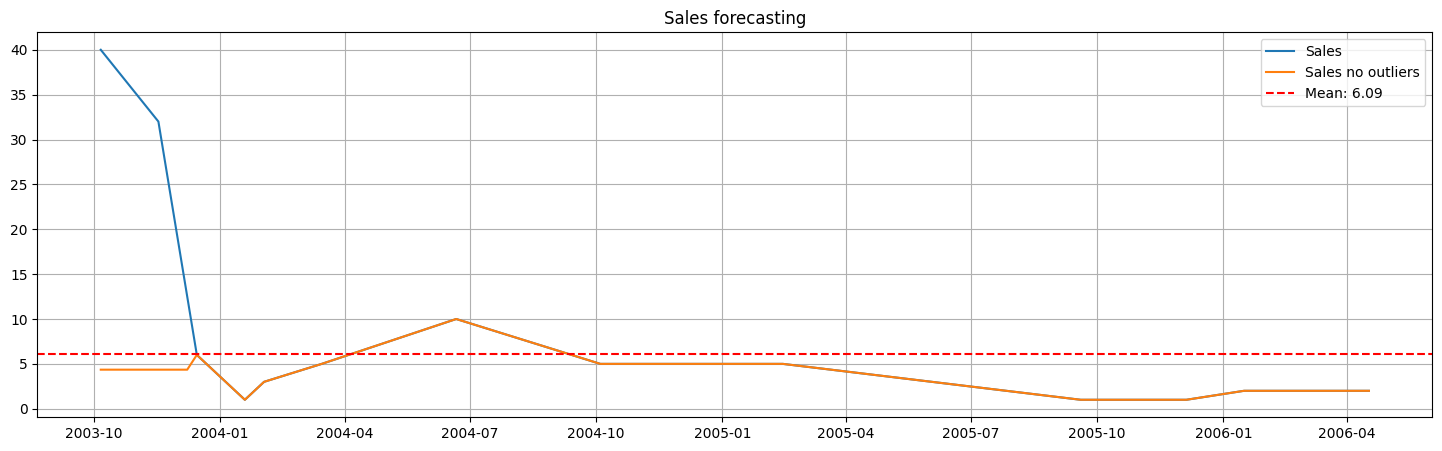

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  8.59375
Mean : 8.58, Median: 6.428571428571429


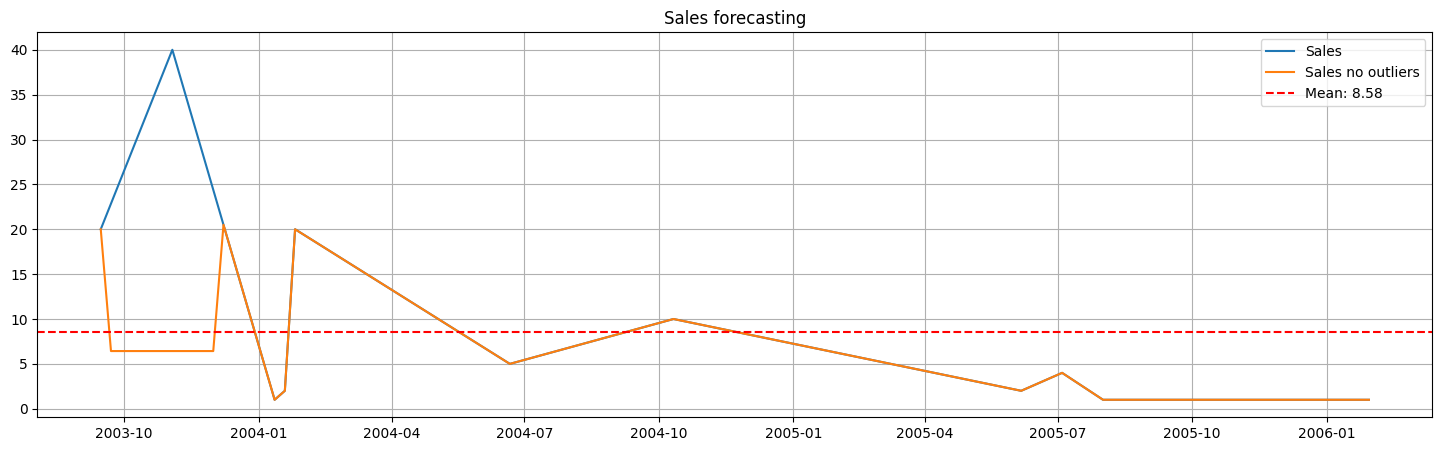

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipy

Percentage outliers:  5.633802816901409
Mean : 4.964539007092198, Median: 4.454545454545455


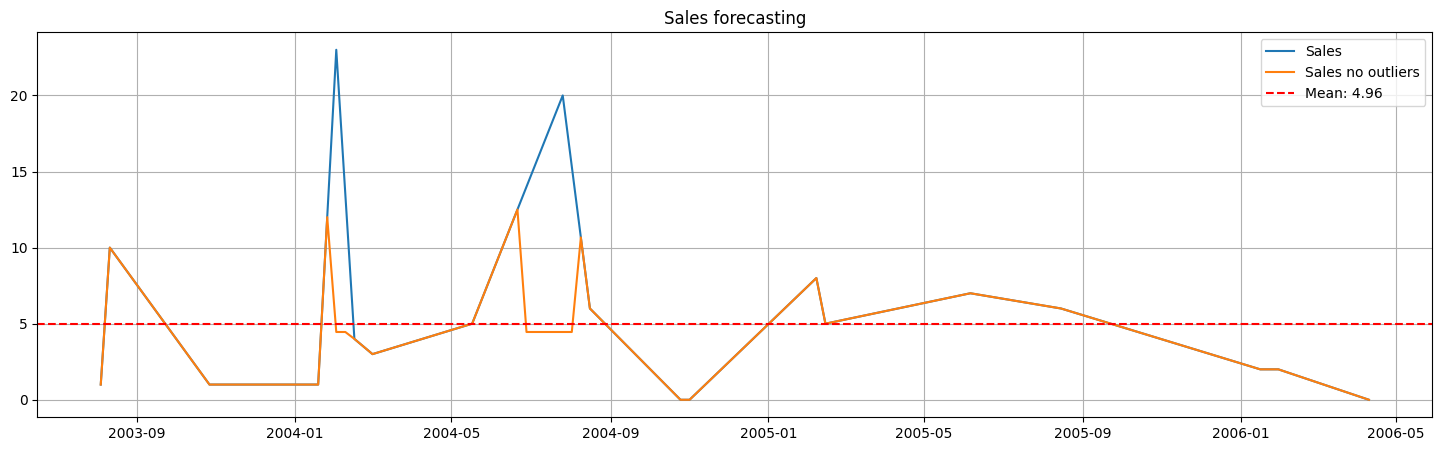

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipy

Percentage outliers:  3.4722222222222223
Mean : 8.149305555555555, Median: 7.388888888888889


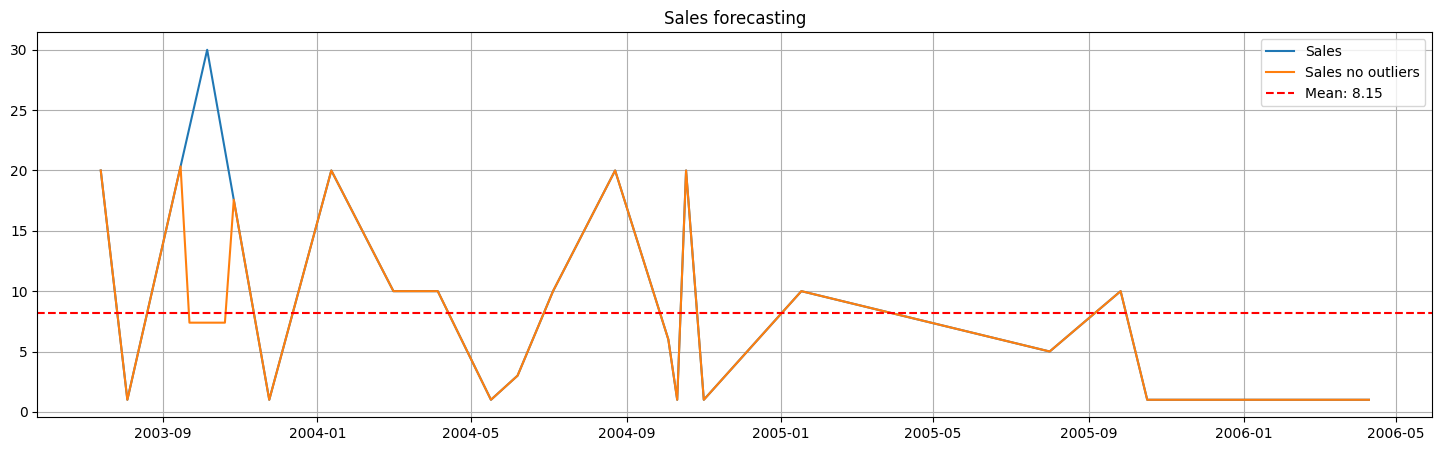

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipy

Percentage outliers:  2.73972602739726
Mean : 4.0, Median: 4.125


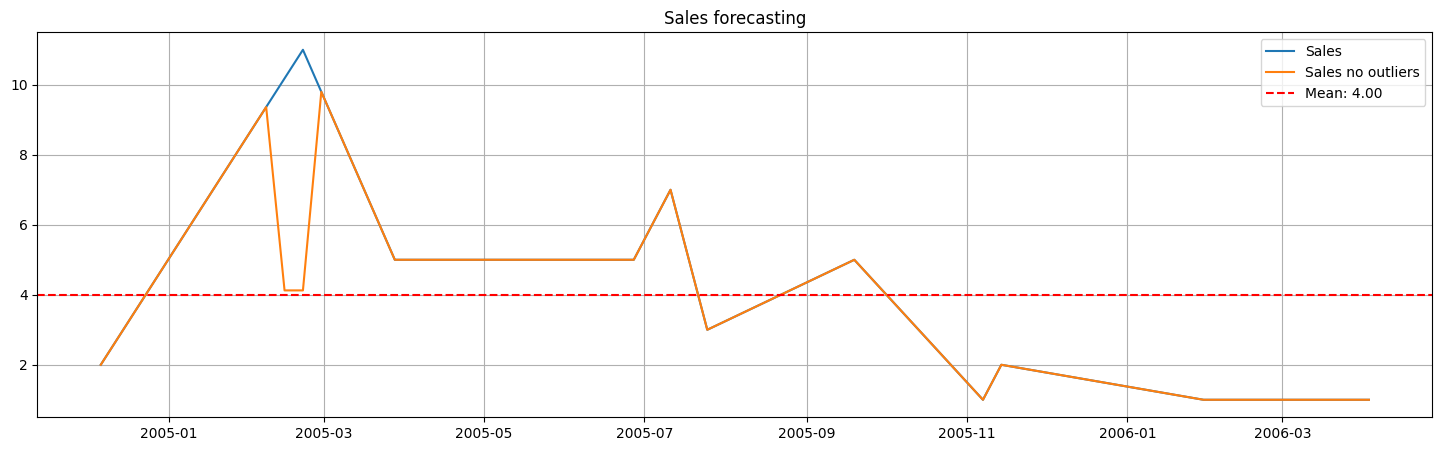

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:50:40 - cmdstanpy - INFO - Chain [1] start processing
13:50:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  3.597122302158273
Mean : 4.666666666666667, Median: 2.8076923076923075


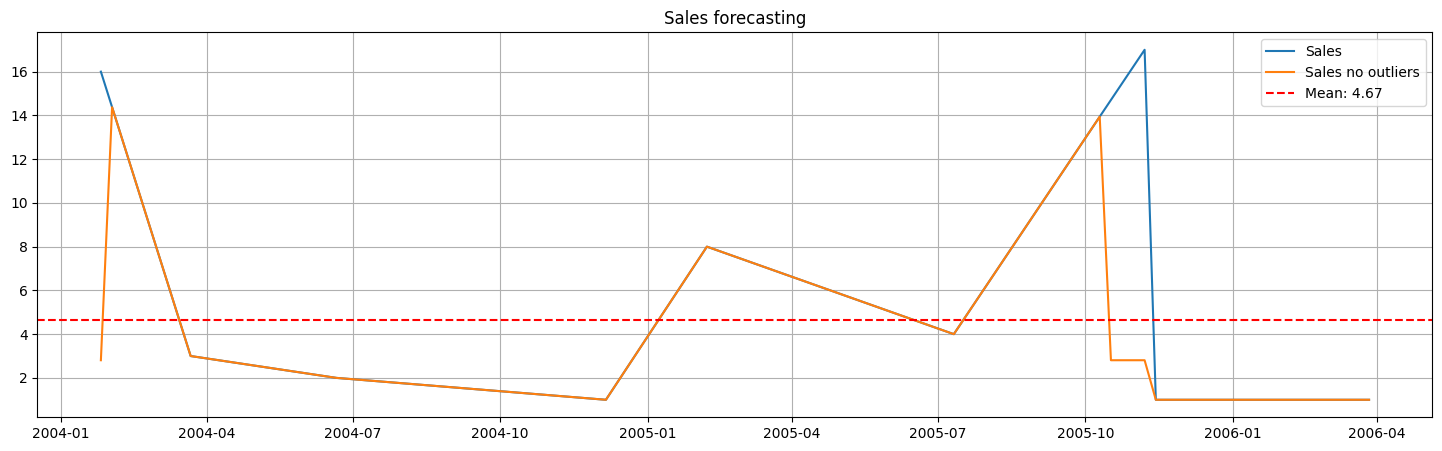

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Carlota\AppData\Local\Programs

Percentage outliers:  3.508771929824561
Mean : 3.36, Median: 2.0


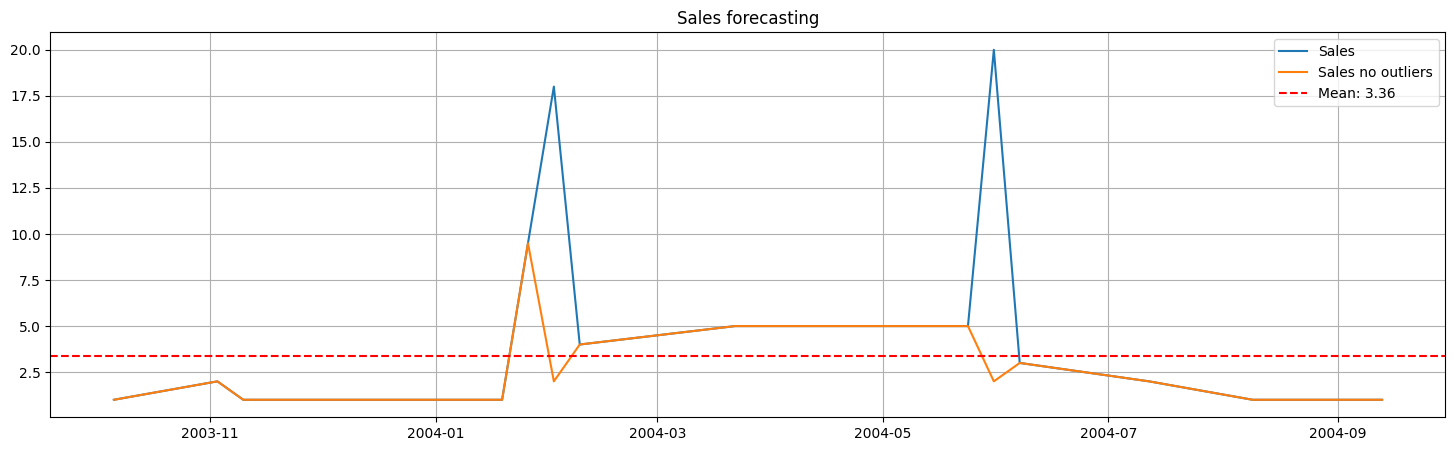

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Us

Percentage outliers:  17.5
Mean : 7.275, Median: 2.757142857142857


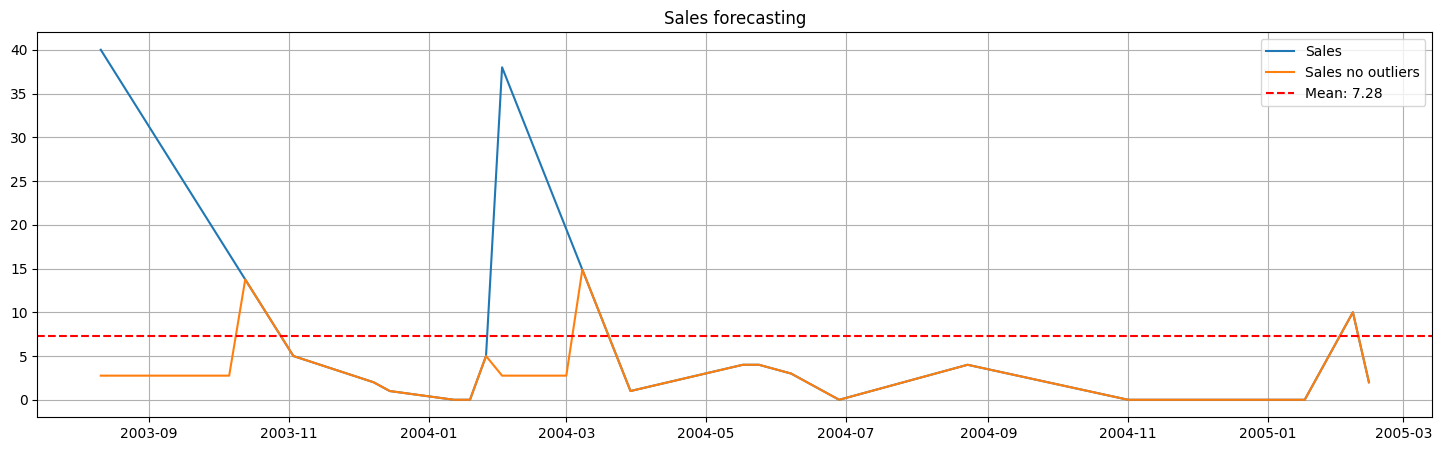

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:50:49 - cmdstanpy - INFO - Chain [1] start processing
13:50:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  2.127659574468085
Mean : 4.2781954887218046, Median: 3.666666666666667


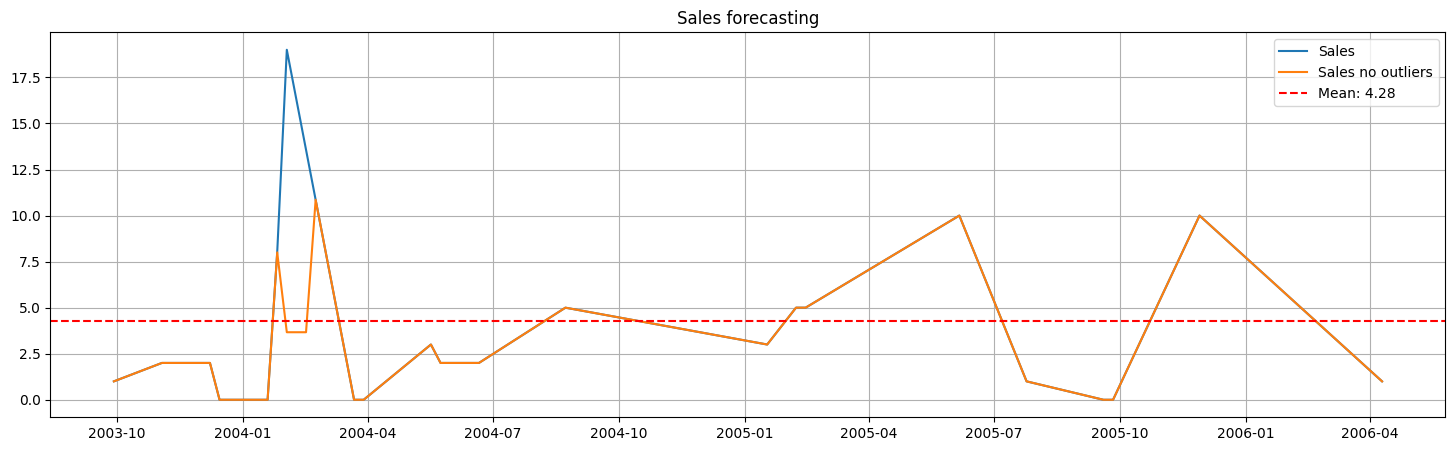

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  2.083333333333333
Mean : 1.4404761904761905, Median: 1.2083333333333335


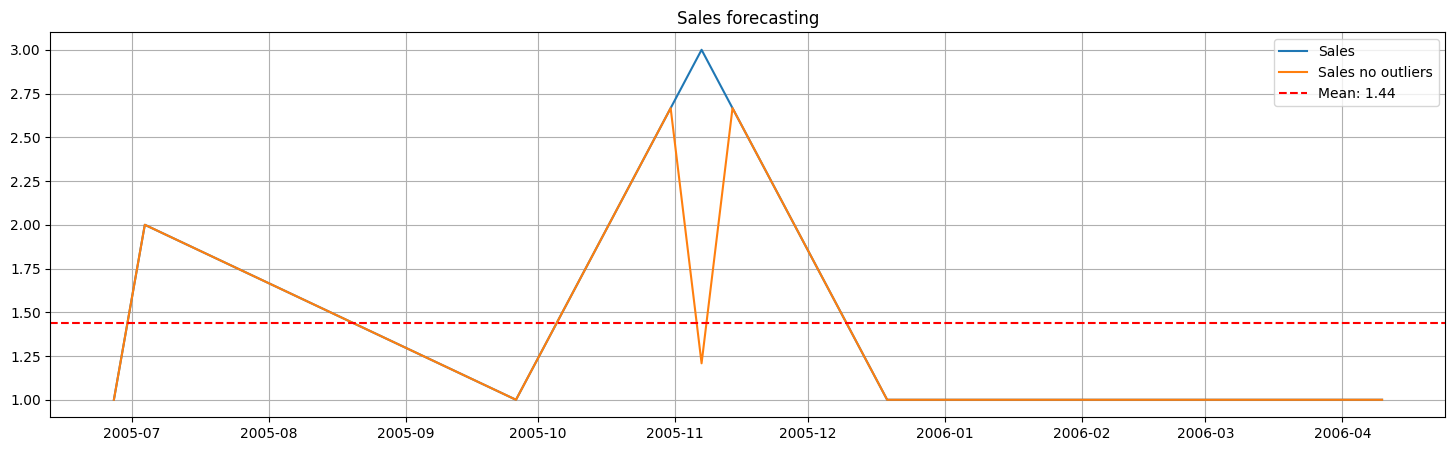

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Us

Percentage outliers:  0.0
Mean : 4.268518518518518, Median: 4.5875


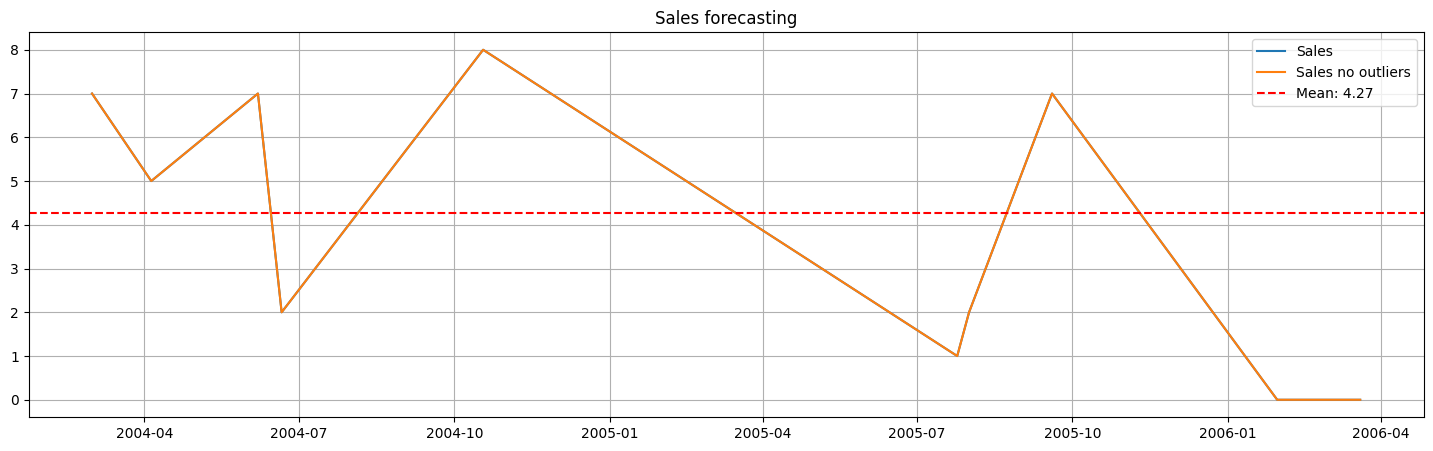

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:51:01 - cmdstanpy - INFO - Chain [1] start processing
13:51:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  0.0
Mean : 8.477011494252874, Median: 8.0


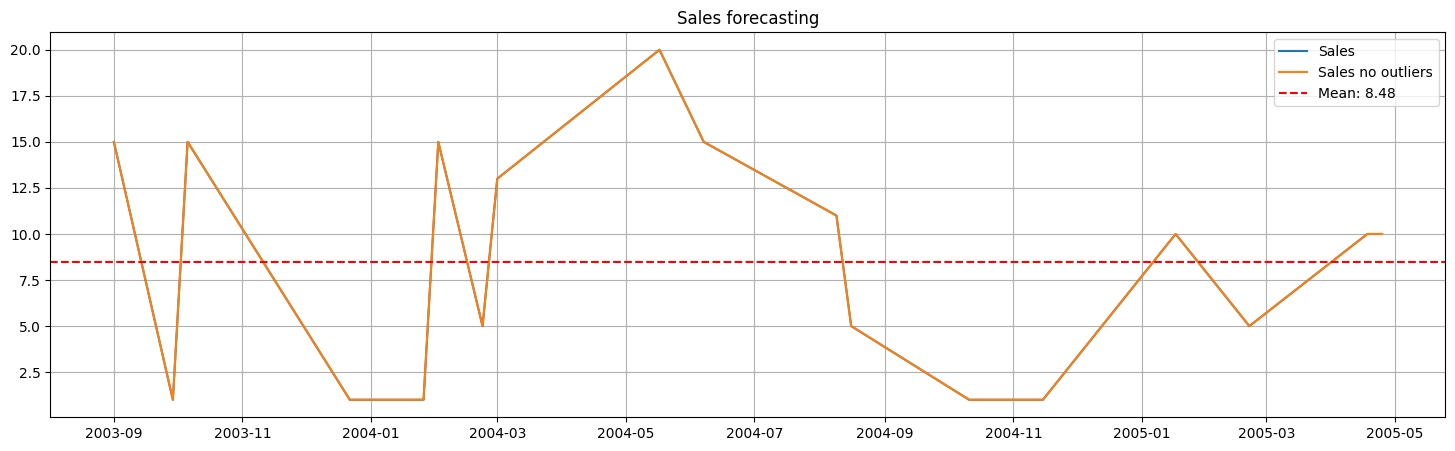

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Percentage outliers:  0.0
Mean : 33.17424242424242, Median: 28.0


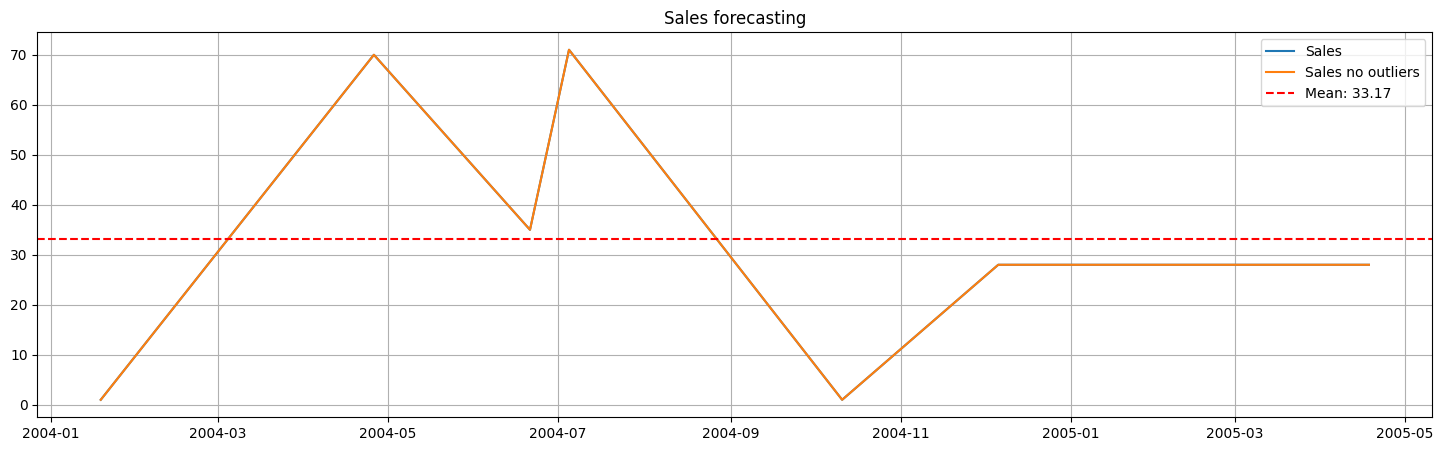

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\198021

Percentage outliers:  0.9009009009009009
Mean : 4.653846153846153, Median: 3.142857142857143


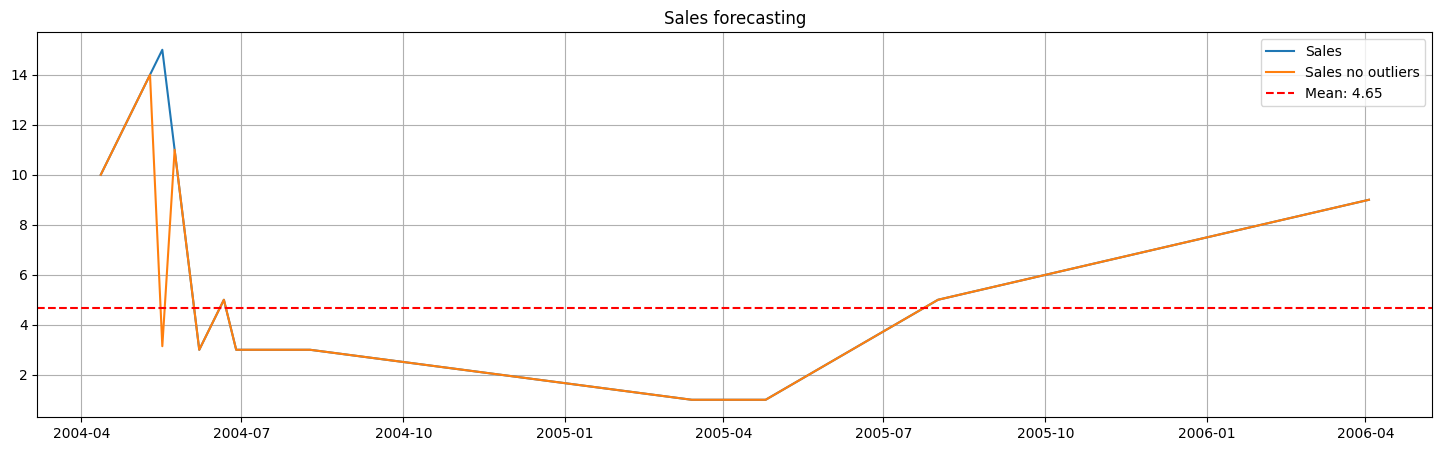

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Percentage outliers:  22.30769230769231
Mean : 4.596774193548387, Median: 5.0


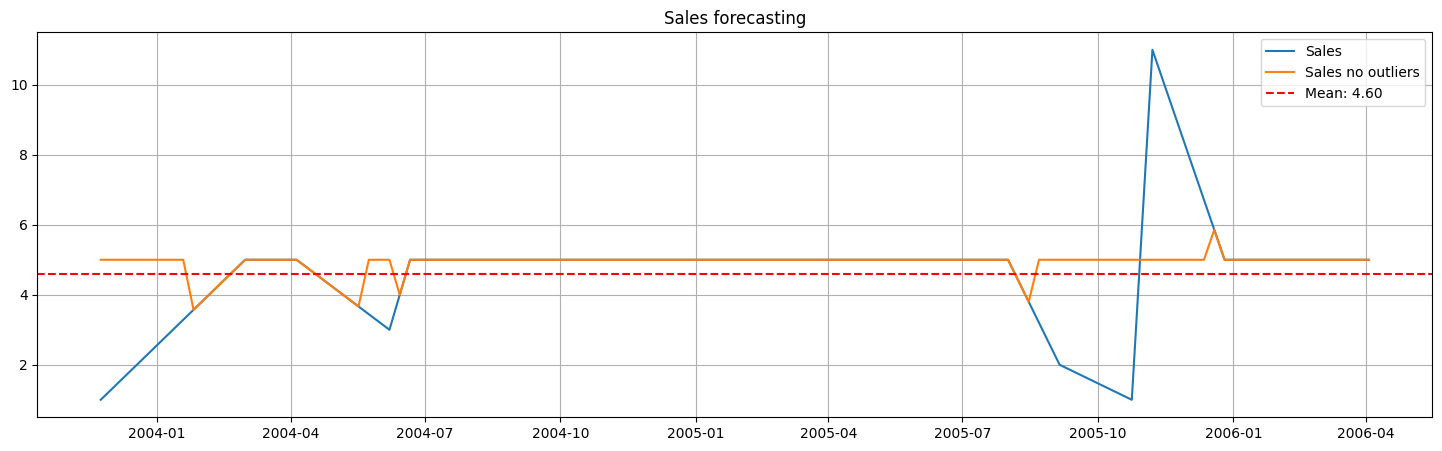

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  18.181818181818183
Mean : 4.333333333333333, Median: 5.0


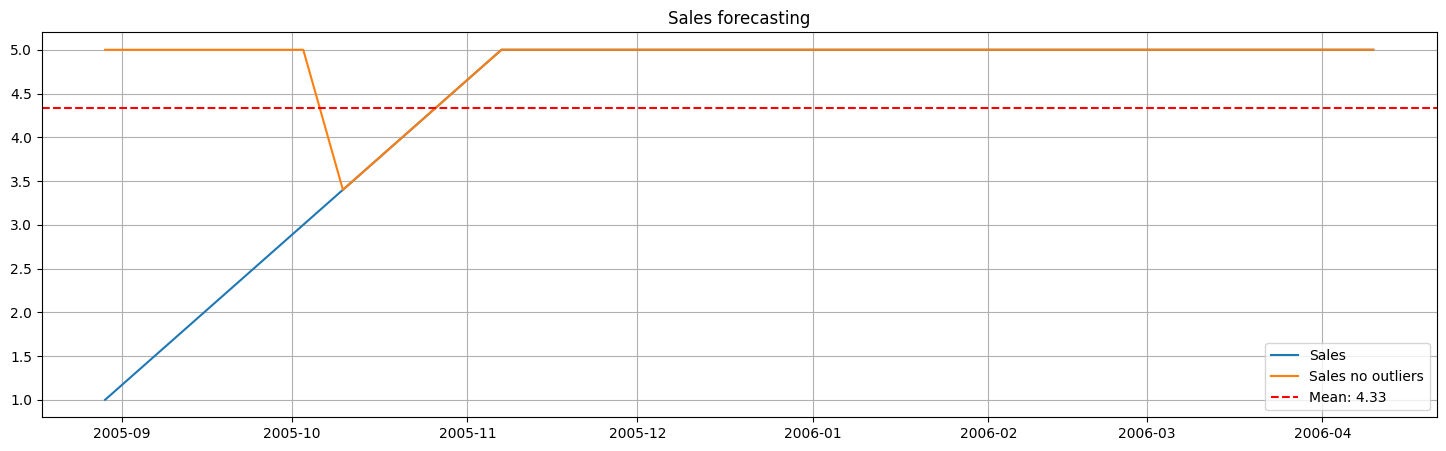

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Percentage outliers:  5.0
Mean : 7.133093525179856, Median: 6.0


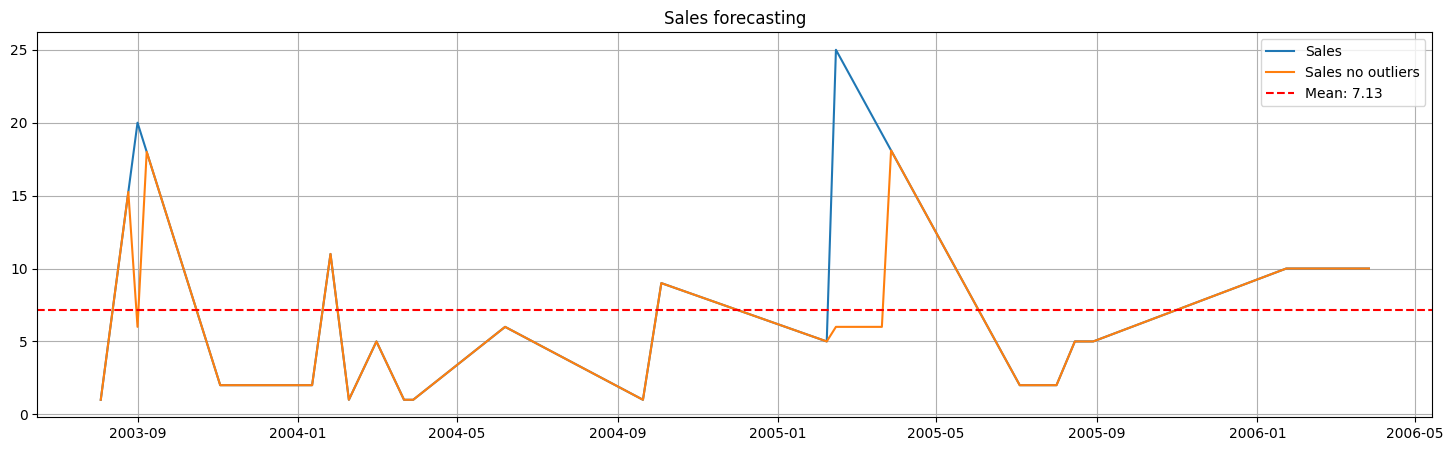

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:51:32 - cmdstanpy - INFO - Chain [1] start processing
13:51:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  19.298245614035086
Mean : 9.675438596491228, Median: 6.833333333333333


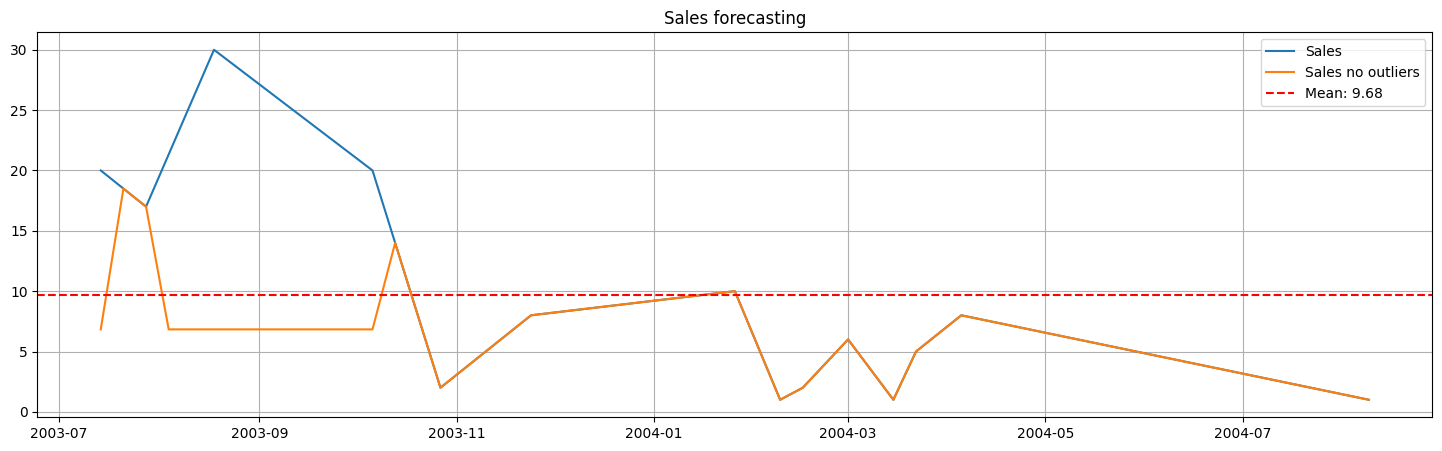

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

Percentage outliers:  19.047619047619047
Mean : 3.0, Median: 3.0


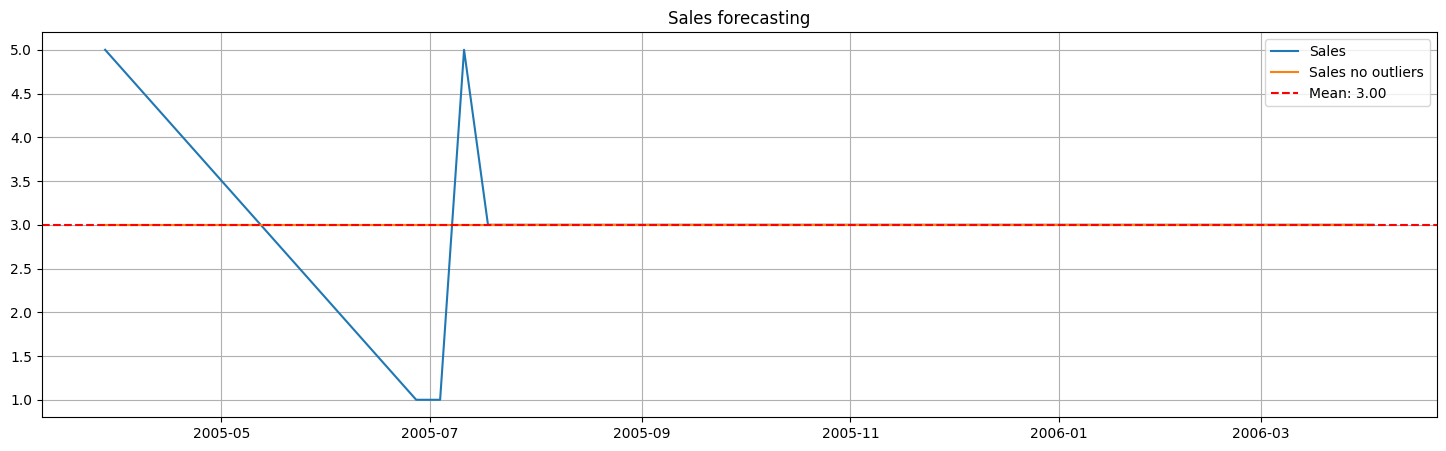

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Us

Percentage outliers:  0.0
Mean : 3.4863013698630136, Median: 2.5555555555555554


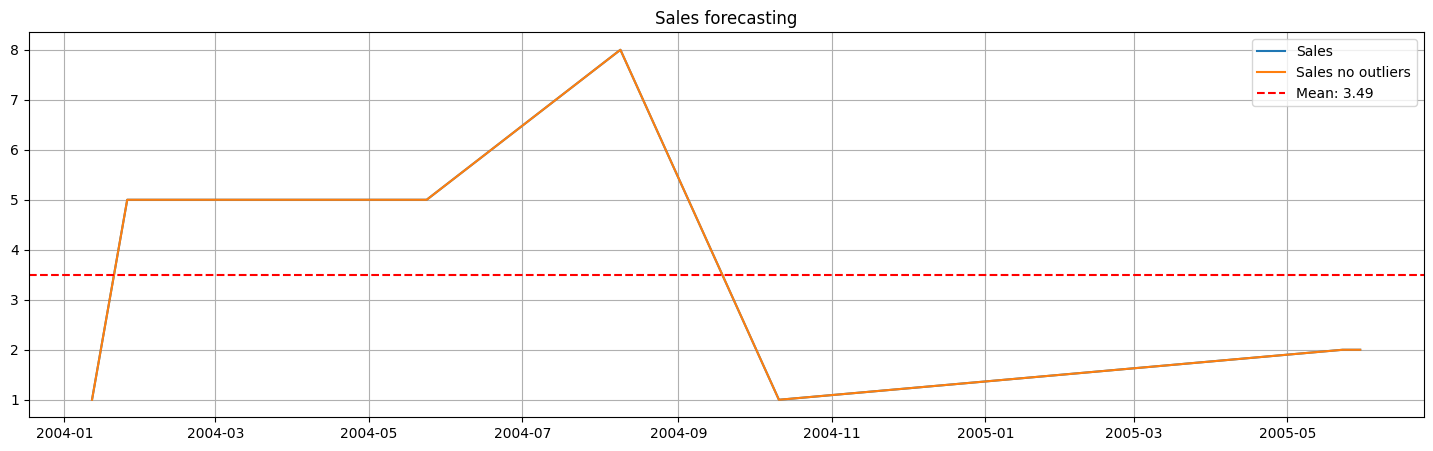

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  25.773195876288657
Mean : 5.185567010309279, Median: 5.0


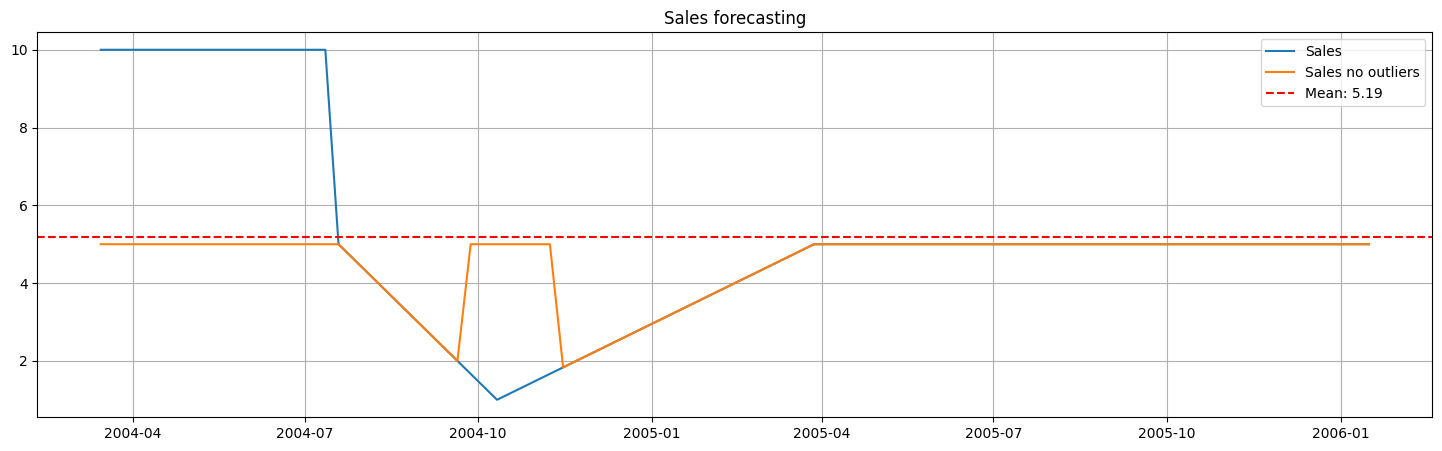

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipy

Percentage outliers:  0.0
Mean : 6.025252525252525, Median: 5.0


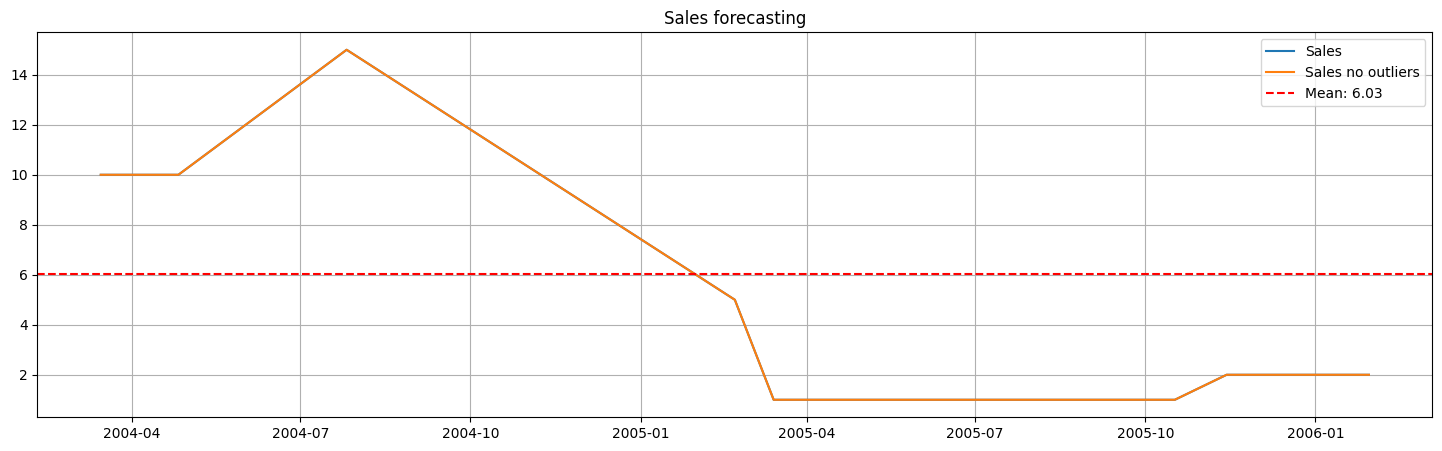

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  5.384615384615385
Mean : 6.053846153846154, Median: 4.441558441558442


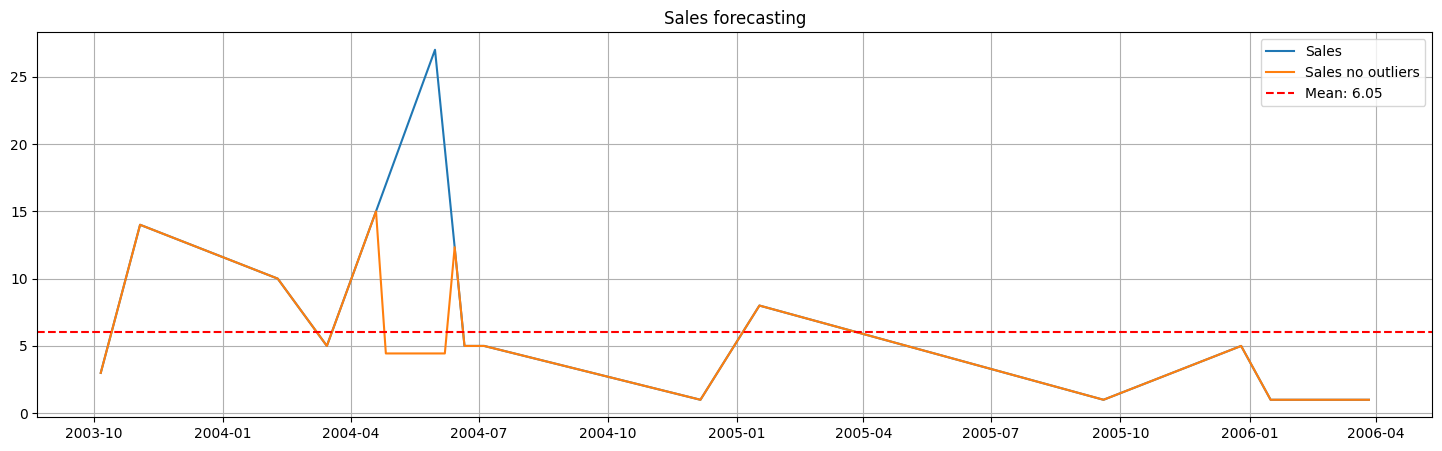

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:51:53 - cmdstanpy - INFO - Chain [1] start processing
13:51:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  0.0
Mean : 3.4646464646464645, Median: 3.0


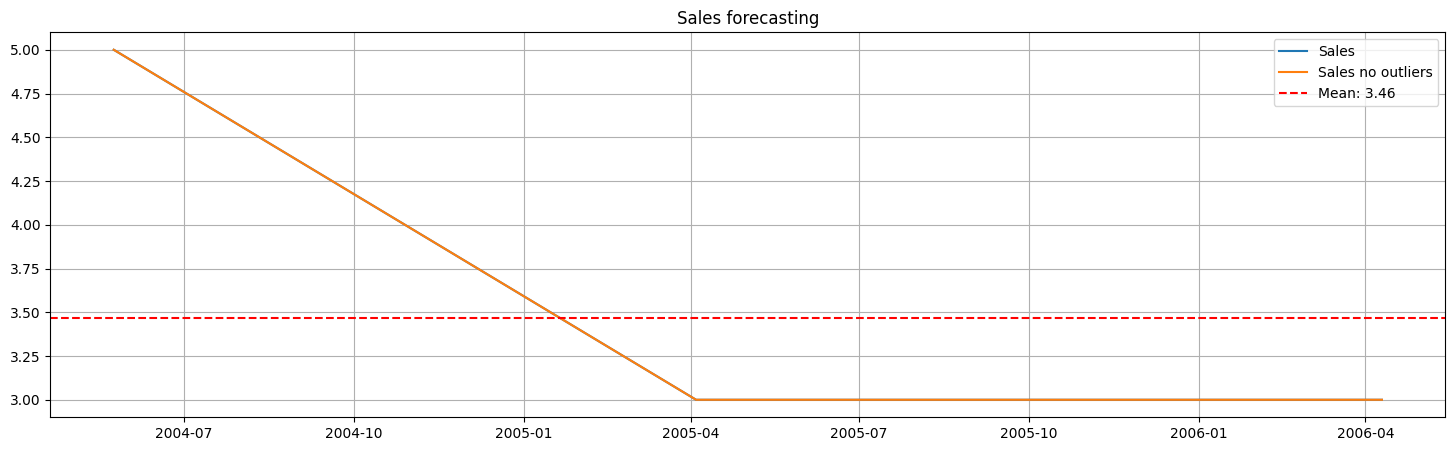

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\P

Percentage outliers:  0.0
Mean : 6.36231884057971, Median: 6.22360248447205


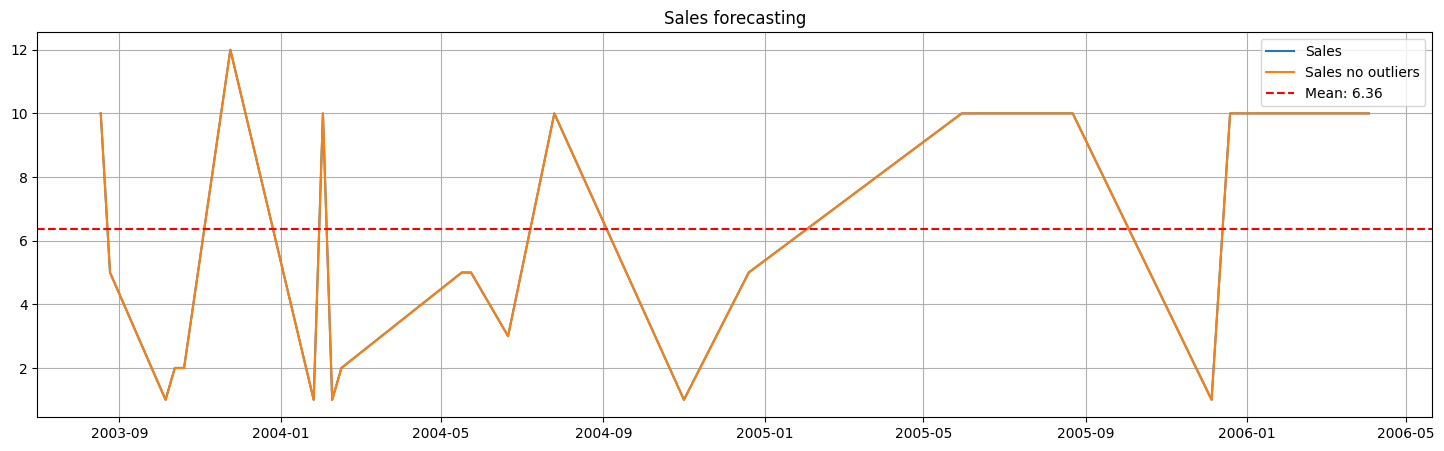

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  0.0
Mean : 9.522058823529411, Median: 10.0


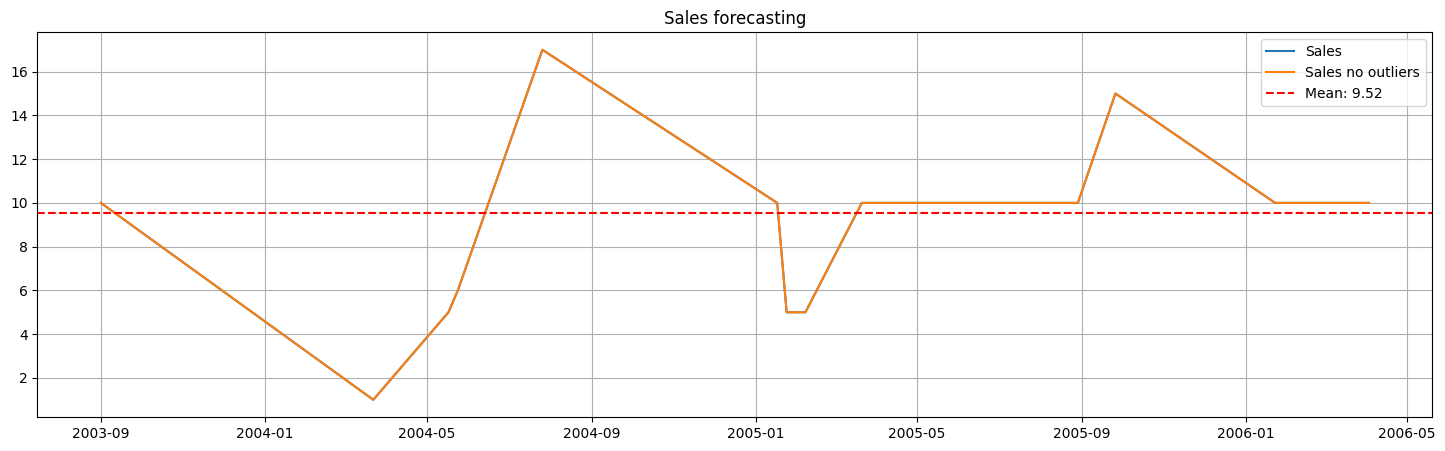

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:52:07 - cmdstanpy - INFO - Chain [1] start processing
13:52:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  0.0
Mean : 5.848360655737705, Median: 6.1396103896103895


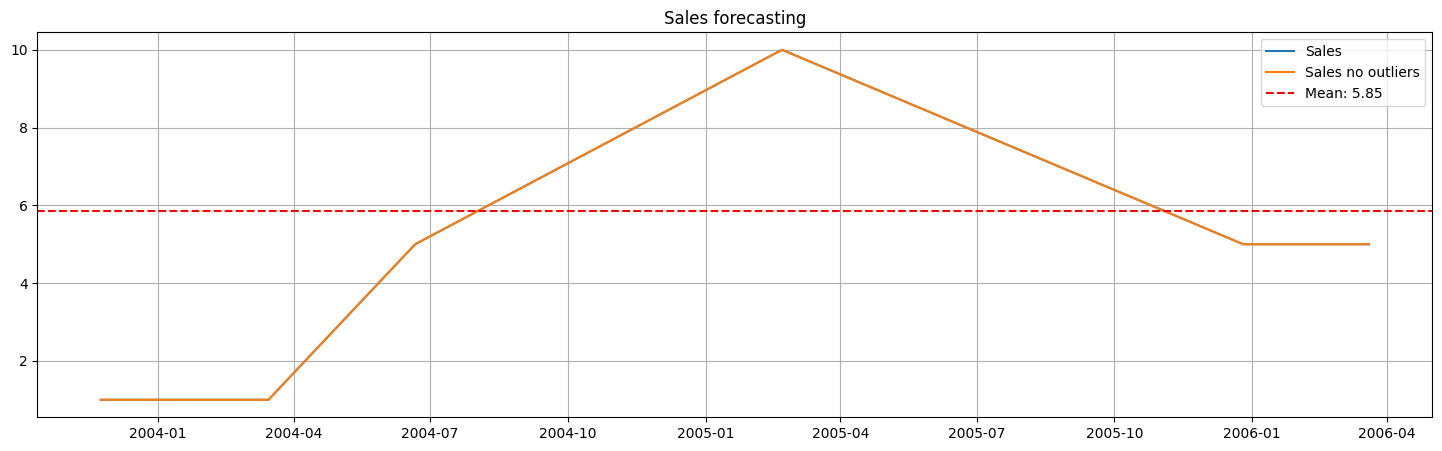

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  6.944444444444445
Mean : 5.055555555555555, Median: 5.0


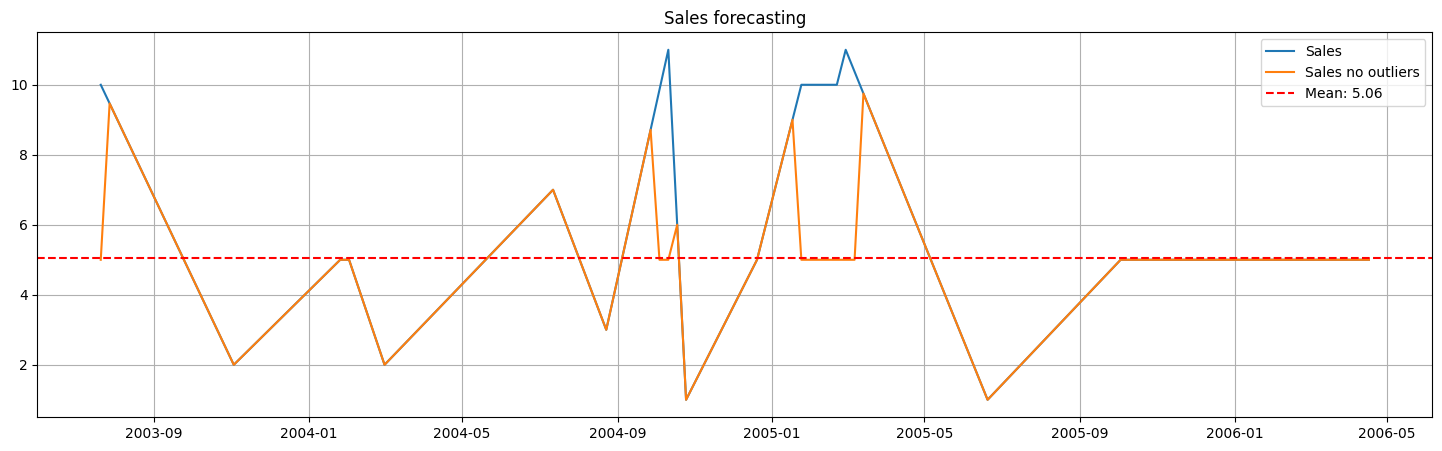

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:52:17 - cmdstanpy - INFO - Chain [1] start processing
13:52:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  11.818181818181818
Mean : 1.288659793814433, Median: 1.0


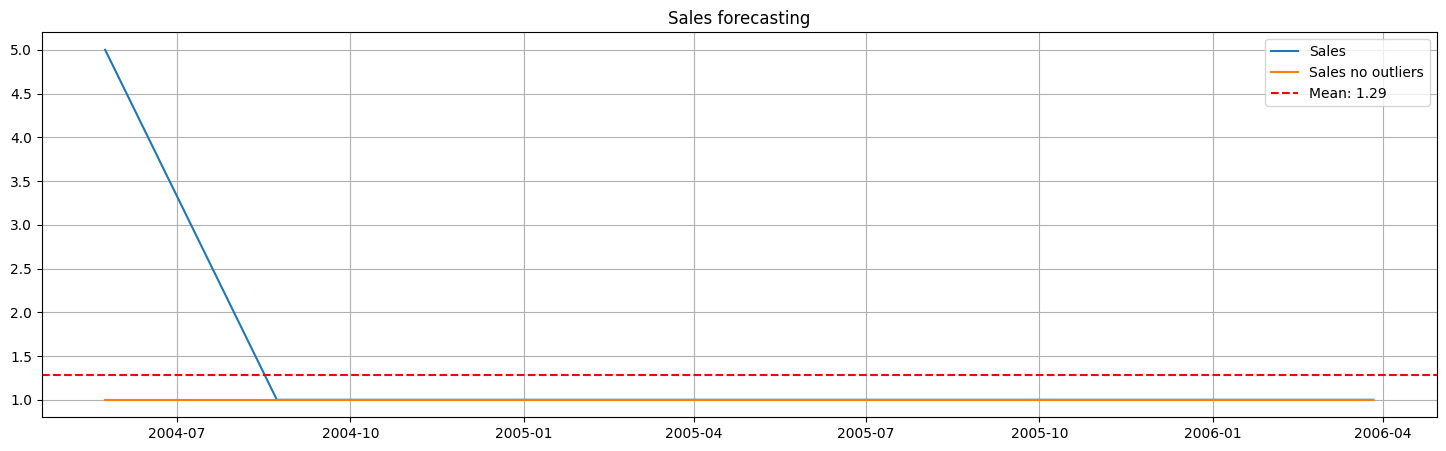

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: Setti

Percentage outliers:  3.669724770642202
Mean : 6.12962962962963, Median: 7.0


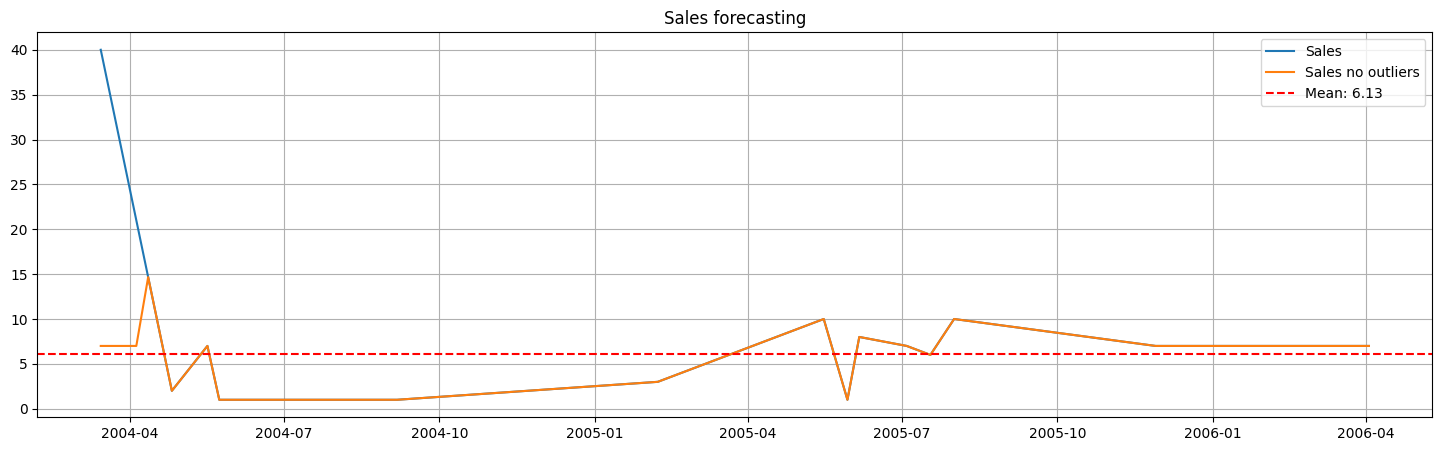

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Percentage outliers:  0.7874015748031495
Mean : 3.3253968253968256, Median: 3.0


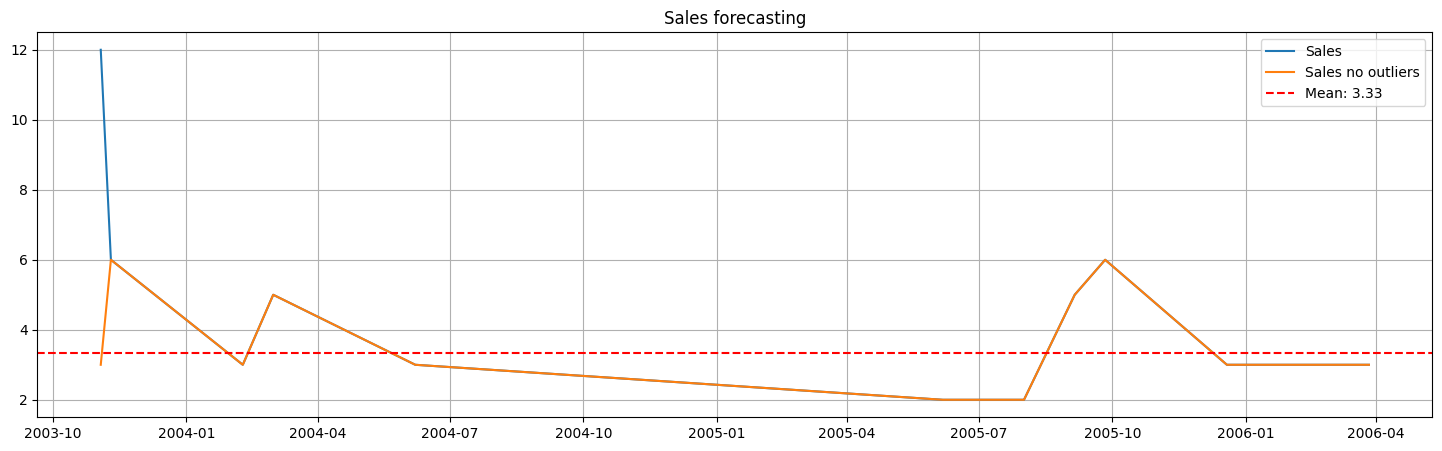

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210

Percentage outliers:  0.0
Mean : 5.09375, Median: 4.38421052631579


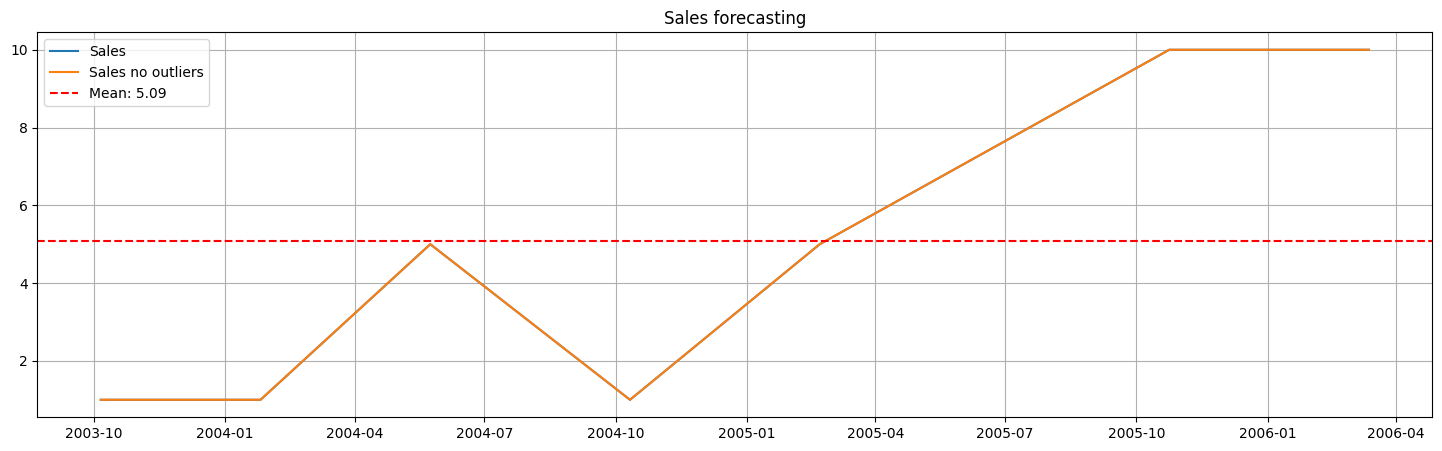

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipy

Percentage outliers:  0.0
Mean : 0.6964285714285714, Median: 0.8333333333333334


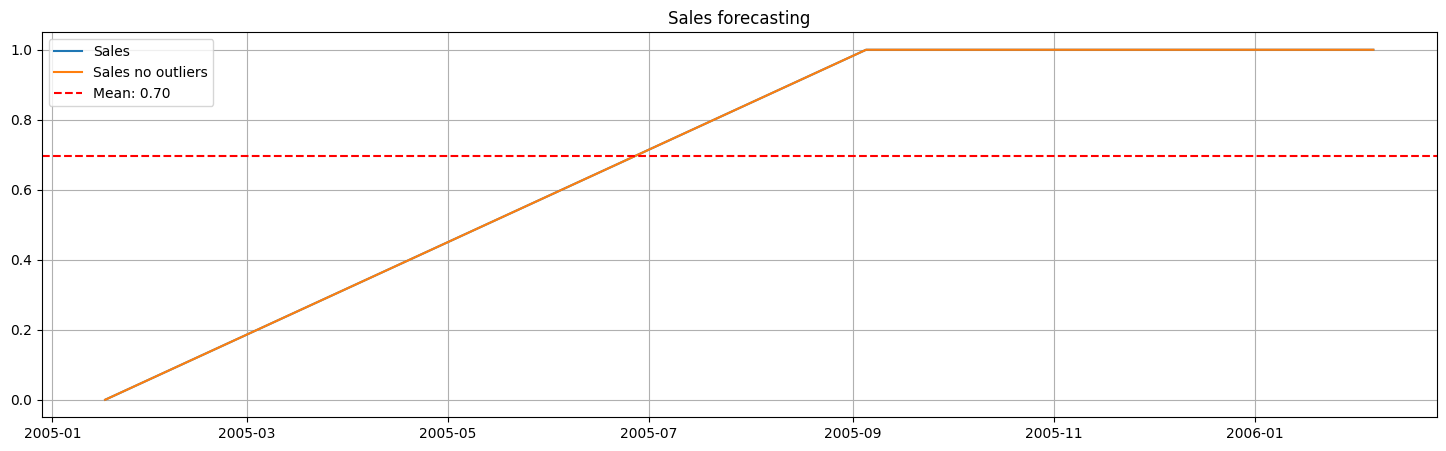

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Carlota\AppData\Local\Programs

Percentage outliers:  10.76923076923077
Mean : 6.6, Median: 4.519230769230769


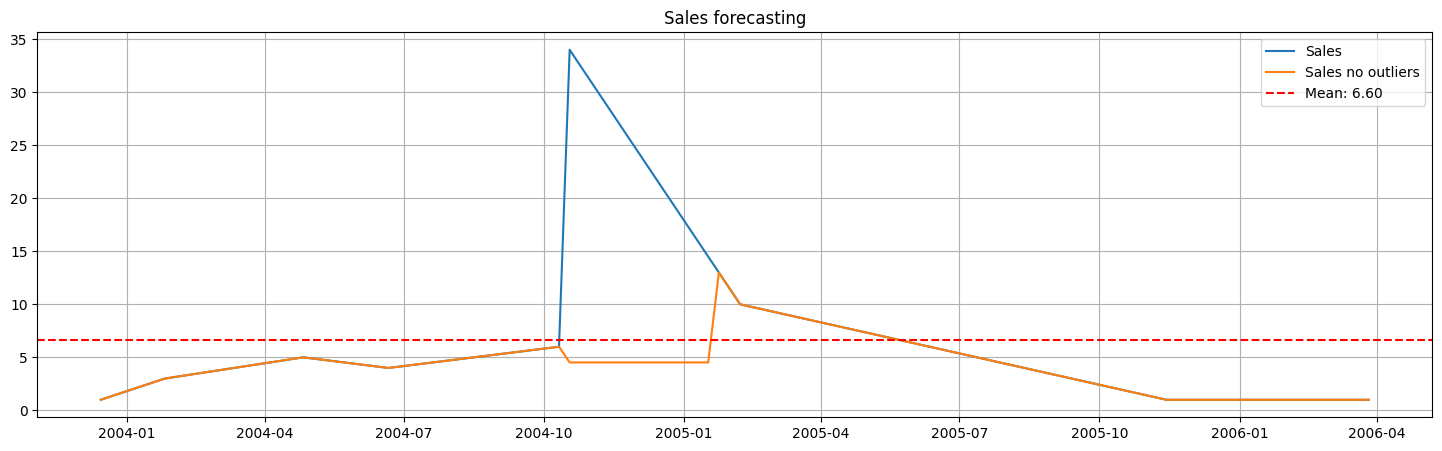

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:52:49 - cmdstanpy - INFO - Chain [1] start processing
13:52:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  13.970588235294118
Mean : 2.952, Median: 1.7692307692307692


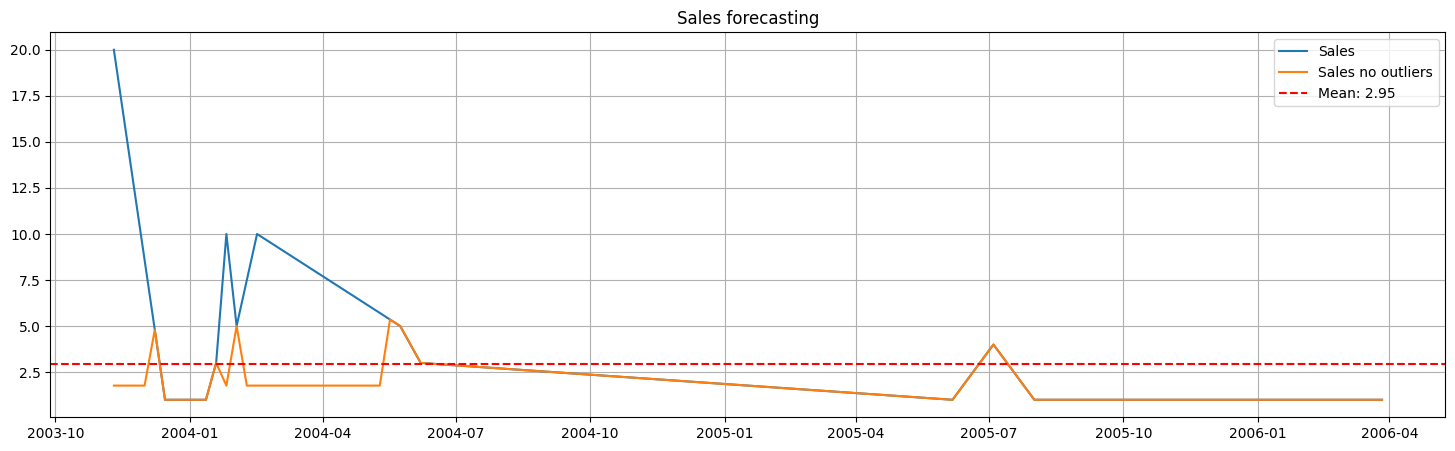

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:52:56 - cmdstanpy - INFO - Chain [1] start processing
13:52:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  0.0
Mean : 3.0, Median: 3.0


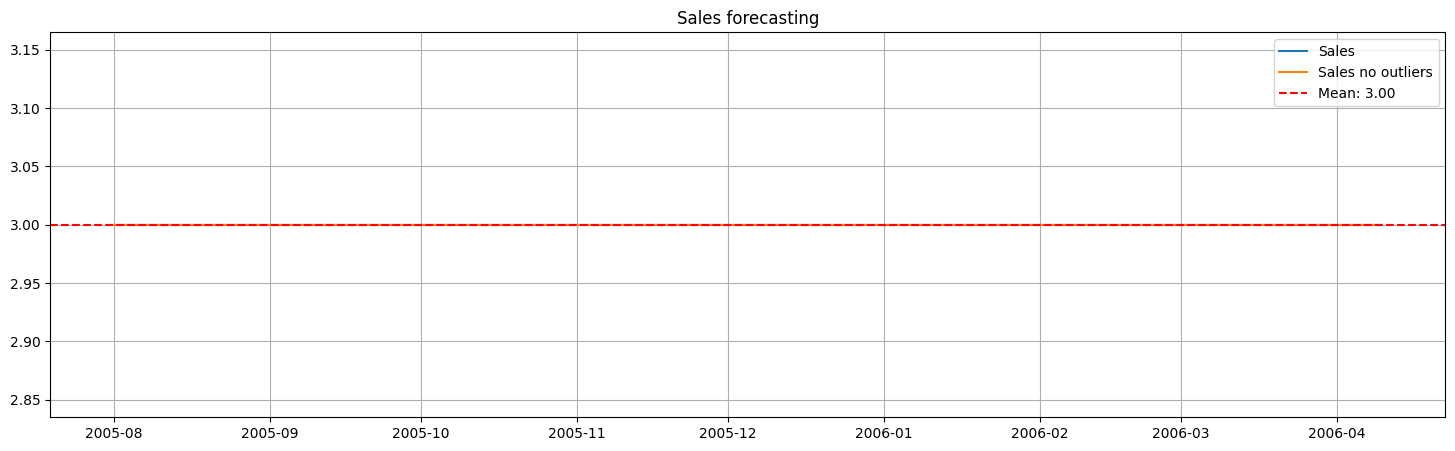

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Percentage outliers:  14.074074074074074
Mean : 7.96218487394958, Median: 3.0


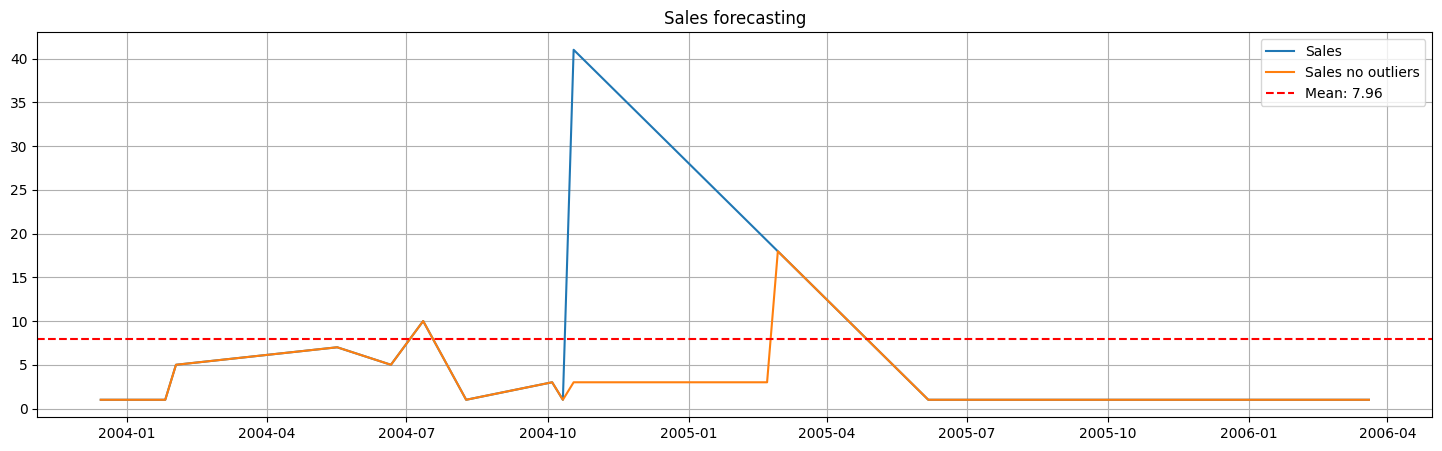

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Percentage outliers:  6.976744186046512
Mean : 7.535087719298246, Median: 7.474489795918368


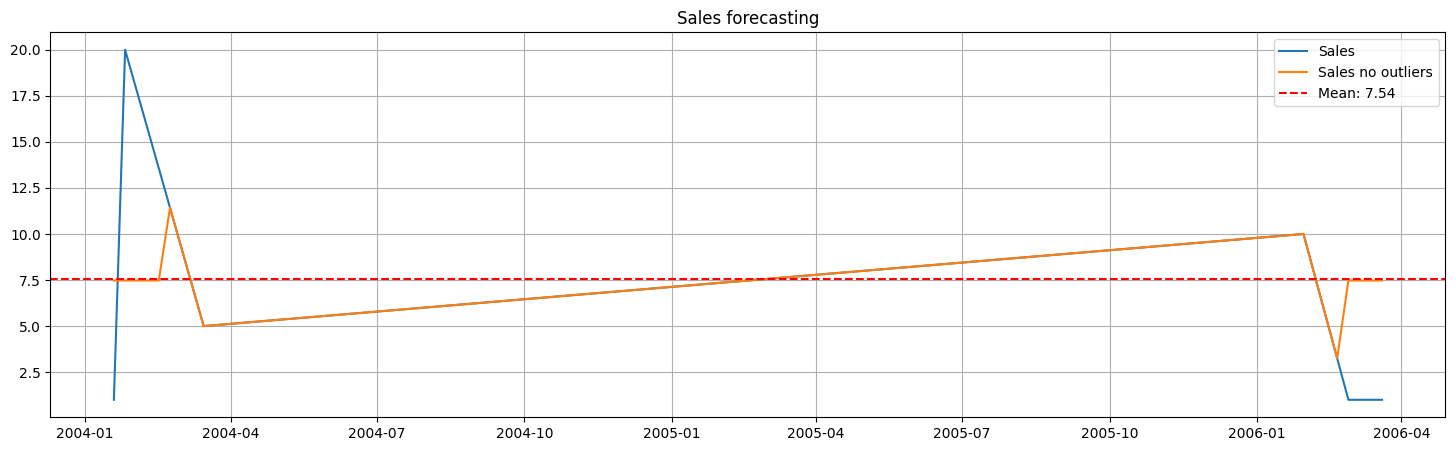

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:53:10 - cmdstanpy - INFO - Chain [1] start processing
13:53:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  0.0
Mean : 3.6153846153846154, Median: 3.4375


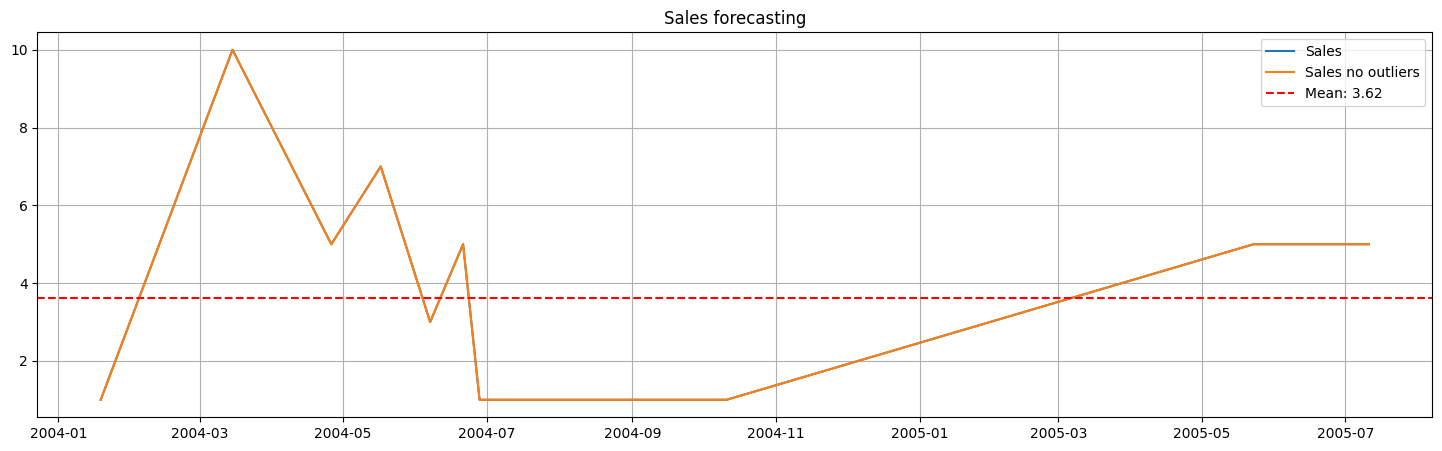

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Percentage outliers:  0.7692307692307693
Mean : 4.384, Median: 5.0


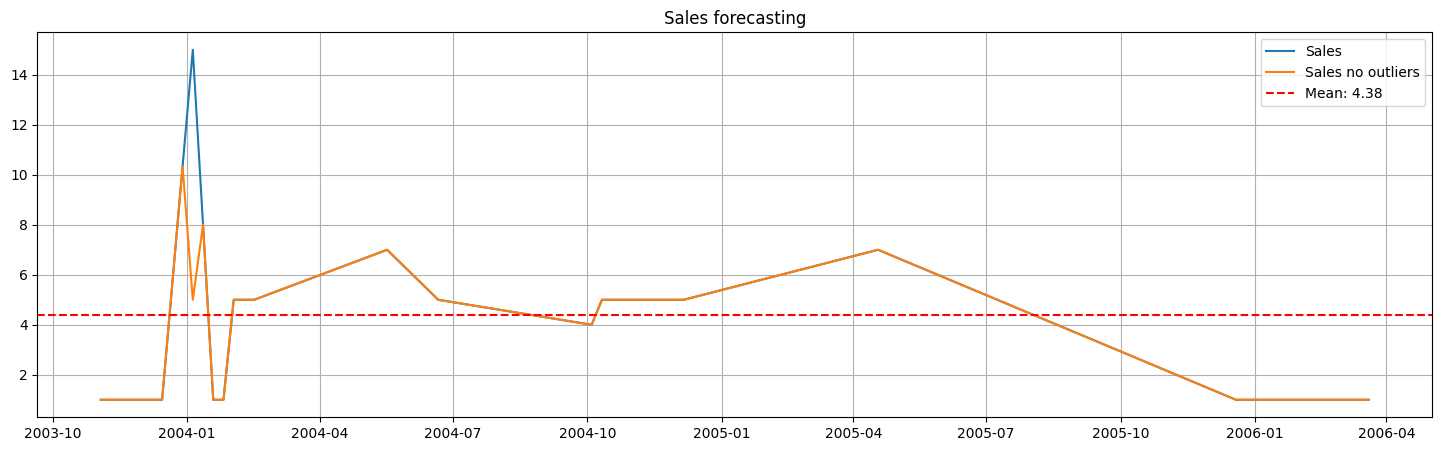

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:53:19 - cmdstanpy - INFO - Chain [1] start processing
13:53:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


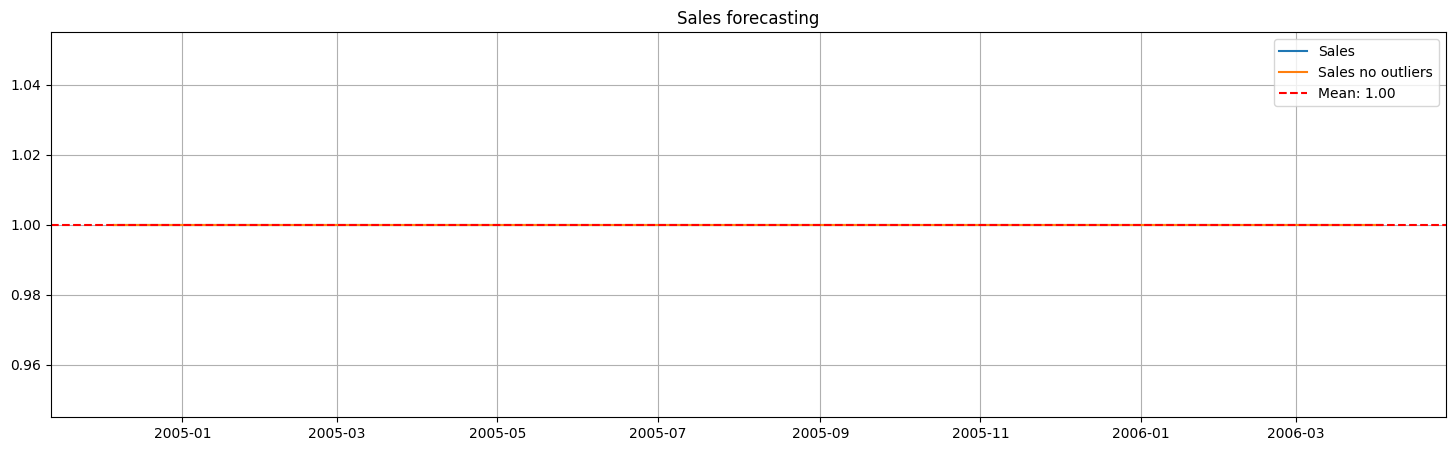

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: Setti

Percentage outliers:  0.0
Mean : nan, Median: nan


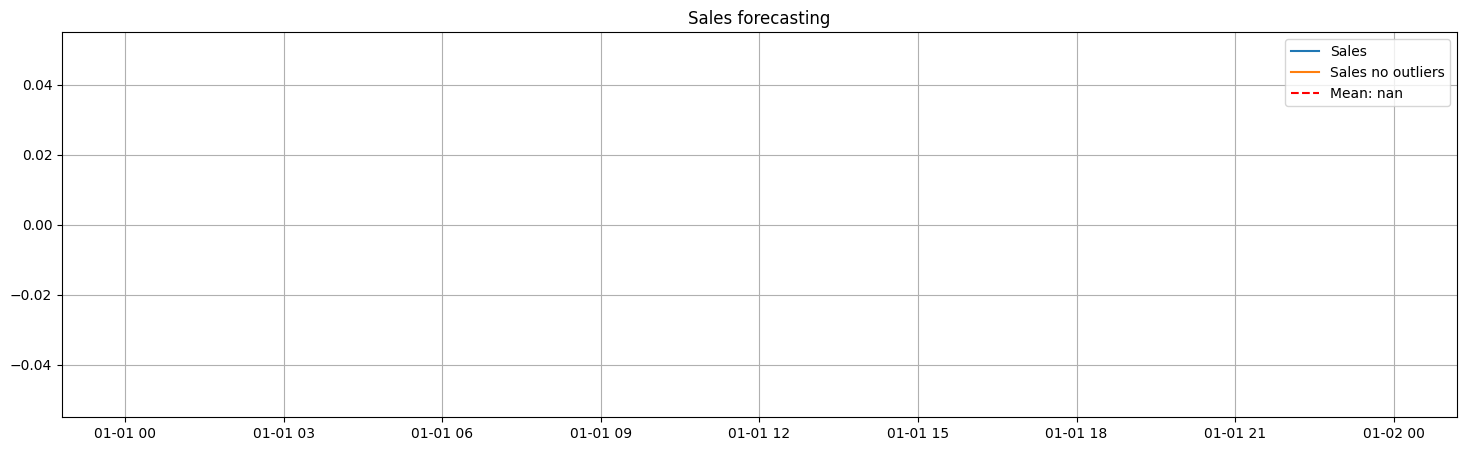

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

No hay suficientes datos no nulos en el dataframe para aplicar Prophet.
Percentage outliers:  1.6
Mean : 4.472727272727273, Median: 5.0


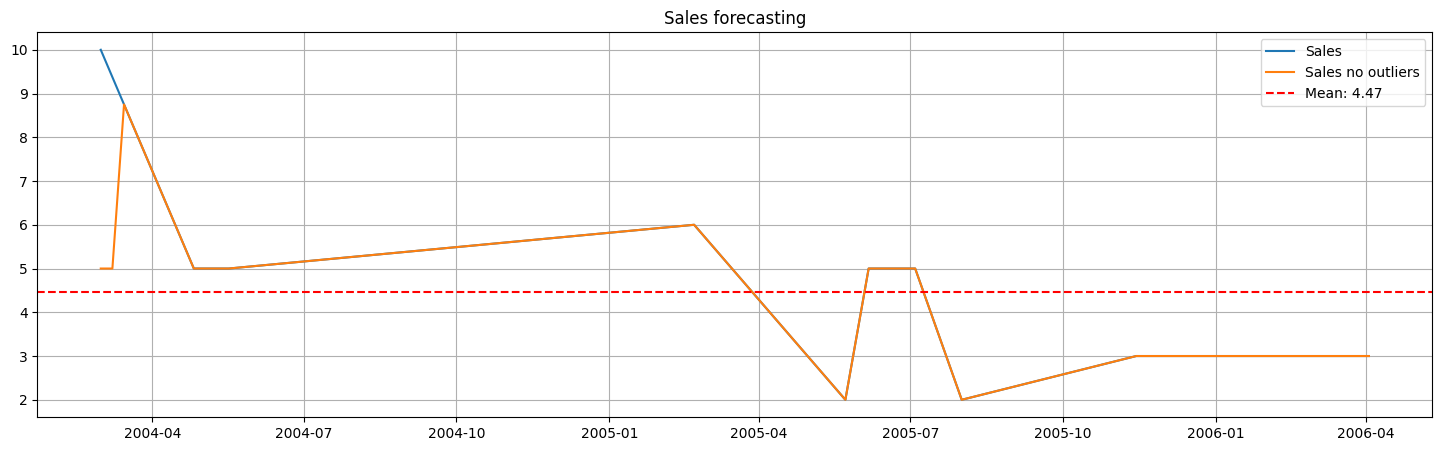

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:53:32 - cmdstanpy - INFO - Chain [1] start processing
13:53:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  6.097560975609756
Mean : 4.5, Median: 2.7584541062801935


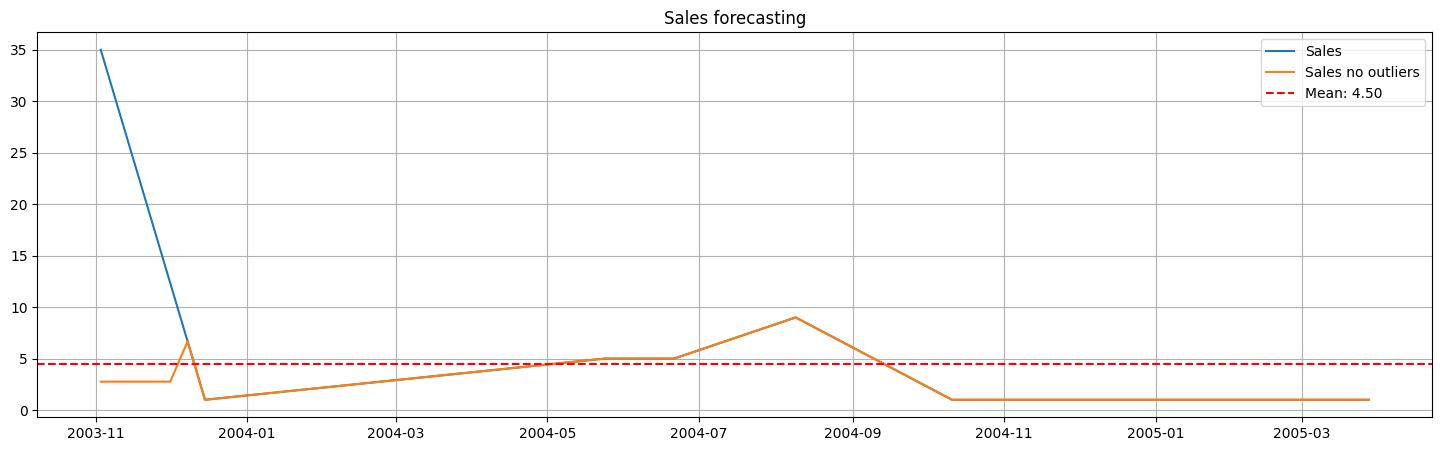

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
13:53:34 - cmdstanpy - INFO - Chain [1] start processing
13:53:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\183863745.p

Percentage outliers:  7.857142857142857
Mean : 2.996153846153846, Median: 1.8181818181818183


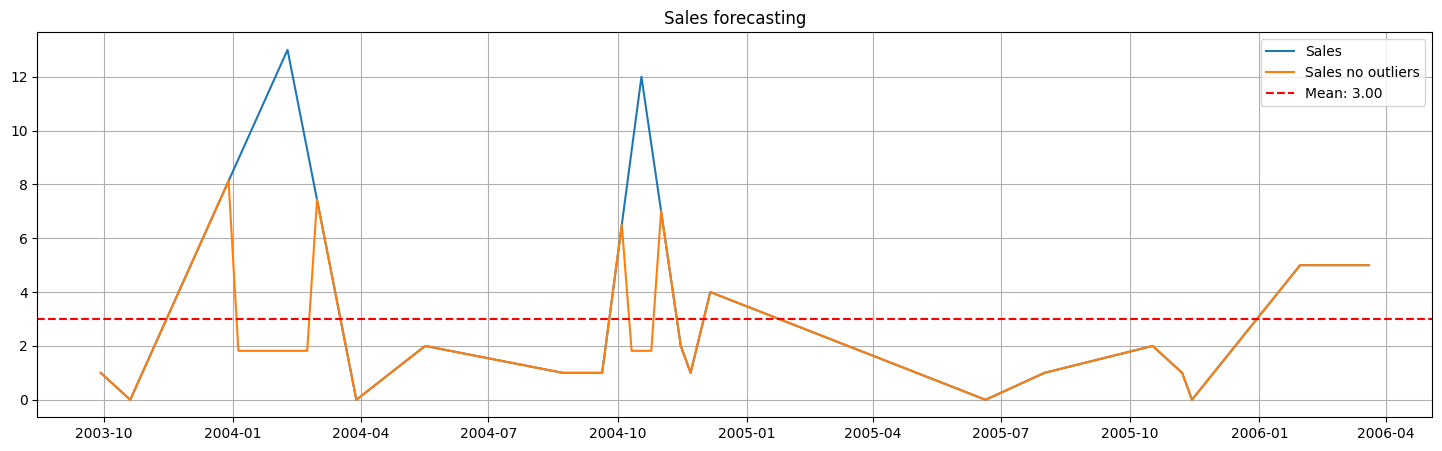

ValueError: too many values to unpack (expected 2)

In [128]:
# Inicializar contenedores para almacenar resultados
all_errors = pd.DataFrame()
all_predictions = pd.DataFrame()

# Aplicar la función a los productos de alta demanda
for producto_id in df_selected_high_demand_A['ProductID'].unique():
    # Llamar a la función evaluate_model para cada producto en alta demanda
    errors, predictions = evaluate_model(df, producto_id, demand_class='High demand')
    
    # Guardar los resultados de errores
    all_errors = pd.concat([all_errors, errors], ignore_index=True)
    
    # Guardar las predicciones
    all_predictions = pd.concat([all_predictions, predictions], ignore_index=True)

# Aplicar la función a los productos de baja demanda
for producto_id in df_selected_low_demand_A['ProductID'].unique():
    # Llamar a la función evaluate_model para cada producto en baja demanda
    errors, predictions = evaluate_model(df, producto_id, demand_class='Low demand')
    
    # Guardar los resultados de errores
    all_errors = pd.concat([all_errors, errors], ignore_index=True)
    
    # Guardar las predicciones
    all_predictions = pd.concat([all_predictions, predictions], ignore_index=True)

# Mostrar los errores y las predicciones completas
print("Errores para cada producto y modelo:")
print(all_errors)

print("Predicciones para cada producto:")
print(all_predictions)


In [75]:
df_427 = df_selected_high_demand_A[df_selected_high_demand_A['ProductID'] == 427]

In [76]:
df_427

ProductID Classification  DemandClass  QuantitySold   OrderDate
0          427              A  High demand            50  2003-07-11
1          427              A  High demand            50  2003-07-15
2          427              A  High demand            20  2003-07-14
3          427              A  High demand            25  2003-07-14
4          427              A  High demand            50  2003-07-18
..         ...            ...          ...           ...         ...
466        427              A  High demand             5  2006-03-18
467        427              A  High demand             1  2006-04-01
468        427              A  High demand             1  2006-04-01
469        427              A  High demand            27  2006-04-01
470        427              A  High demand            10  2006-04-13

[471 rows x 5 columns]

In [77]:
df_427 = df_427[['OrderDate', 'QuantitySold']]
df_427['OrderDate'] = pd.to_datetime(df_427['OrderDate'])
df_427 = df_427.groupby('OrderDate')['QuantitySold'].sum().reset_index()
df_427

C:\Users\Carlota\AppData\Local\Temp\ipykernel_20632\2239178123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_427['OrderDate'] = pd.to_datetime(df_427['OrderDate'])


OrderDate  QuantitySold
0   2003-07-11            50
1   2003-07-14            45
2   2003-07-15            50
3   2003-07-18            50
4   2003-07-21            40
..         ...           ...
320 2006-02-26             5
321 2006-03-01             2
322 2006-03-18             5
323 2006-04-01            29
324 2006-04-13            10

[325 rows x 2 columns]

In [78]:
df_427 = df_427.set_index('OrderDate')
df_427 = df_427.asfreq('W-MON')
df_427['QuantitySold'] = df_427['QuantitySold'].interpolate()
df_427 

QuantitySold
OrderDate               
2003-07-14     45.000000
2003-07-21     40.000000
2003-07-28     25.000000
2003-08-04     10.000000
2003-08-11     13.833333
...                  ...
2006-03-13      5.000000
2006-03-20      5.000000
2006-03-27      5.000000
2006-04-03      5.000000
2006-04-10      5.000000

[144 rows x 1 columns]

Percentage outliers:  3.4722222222222223
Mean : 23.02777777777778, Median: 20.0


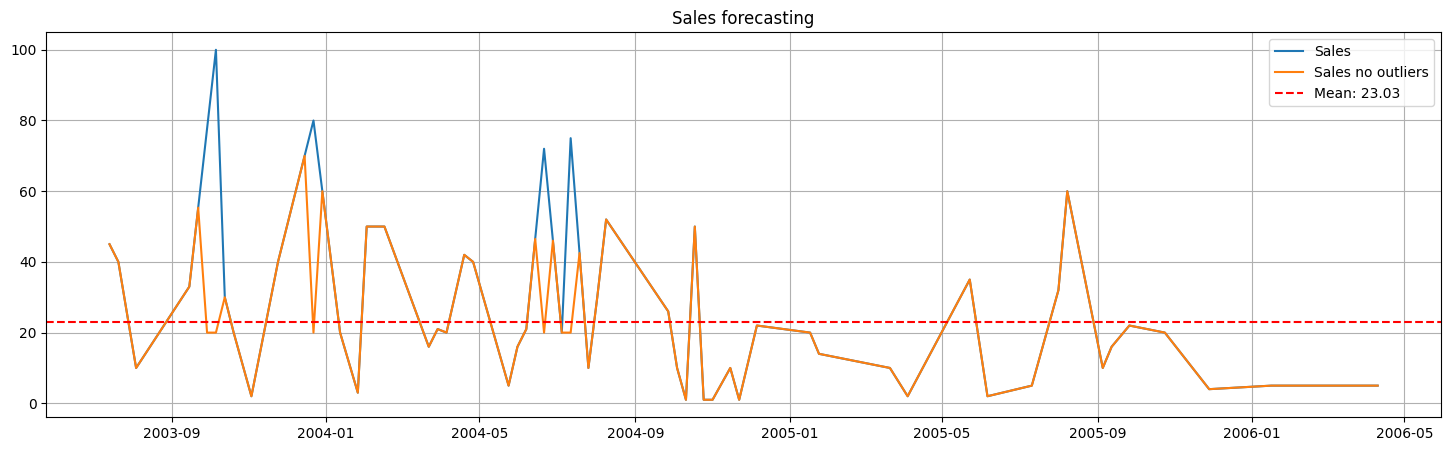

In [79]:
df_427 = outliers_median(df_427)

p-value Kolmogorov-Smirnov: 2.5937794367793507e-72
p-value Shapiro-Wilk: 1.499341997168961e-07


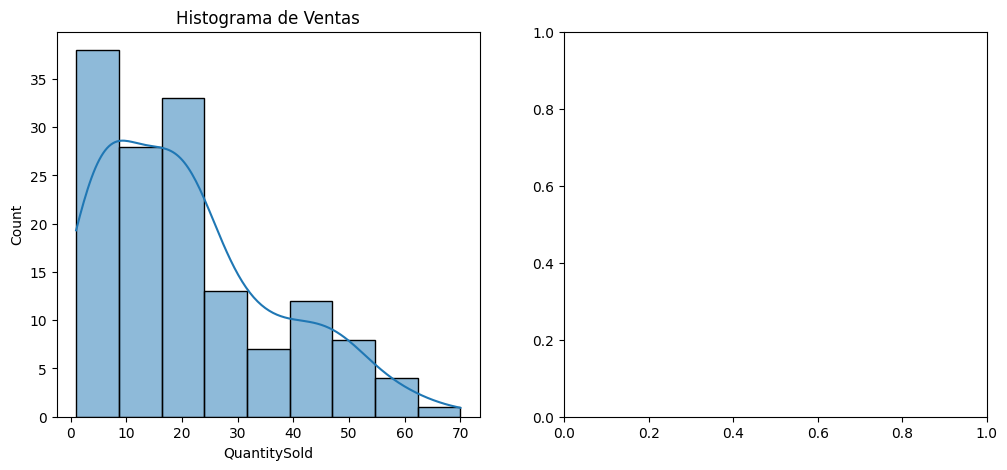

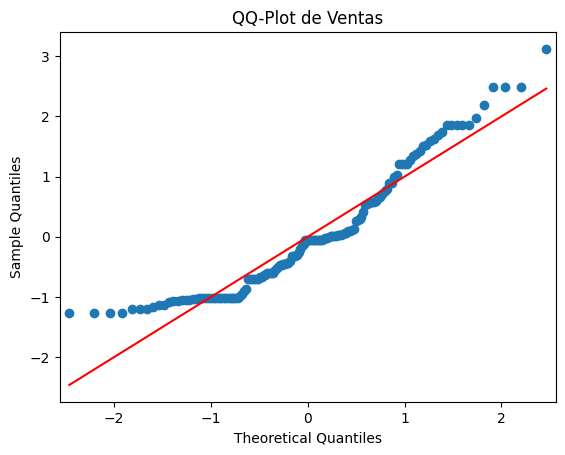

La serie NO es normal. Aplicando Box-Cox...
Lambda de Box-Cox: 0.3363471129692035
p-value Kolmogorov-Smirnov: 1.4444711067998197e-57
p-value Shapiro-Wilk: 0.006482397615024863


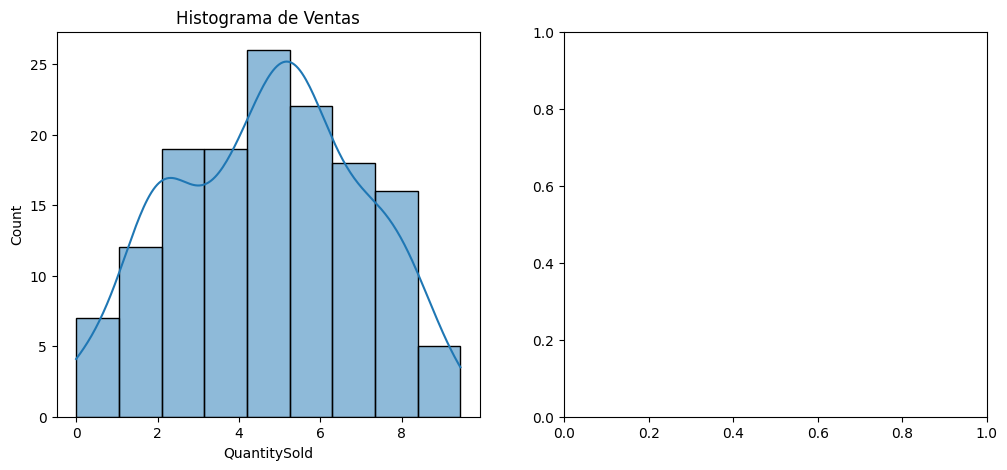

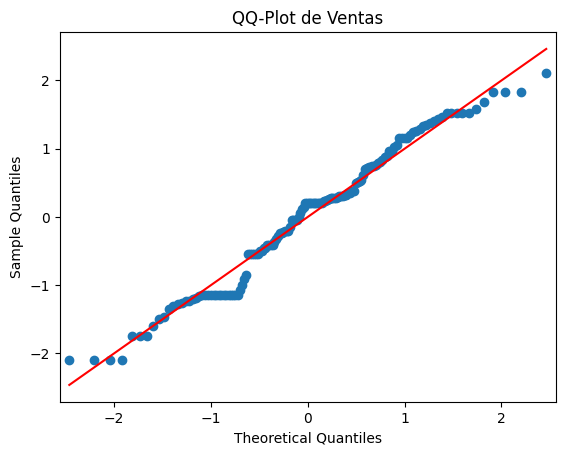

In [80]:
df_427 = check_normality(df_427)

In [81]:
train, test = divide_train_test(df_427)
train, test

(            QuantitySold
 OrderDate               
 2003-07-14      7.723969
 2003-07-21      7.308477
 2003-07-28      5.805079
 2003-08-04      3.476877
 2003-08-11      4.220704
 ...                  ...
 2005-12-05      1.822442
 2005-12-12      1.877437
 2005-12-19      1.931229
 2005-12-26      1.983881
 2006-01-02      2.035452
 
 [130 rows x 1 columns],
             QuantitySold
 OrderDate               
 2006-01-09      2.085996
 2006-01-16      2.135563
 2006-01-23      2.135563
 2006-01-30      2.135563
 2006-02-06      2.135563
 2006-02-13      2.135563
 2006-02-20      2.135563
 2006-02-27      2.135563
 2006-03-06      2.135563
 2006-03-13      2.135563
 2006-03-20      2.135563
 2006-03-27      2.135563
 2006-04-03      2.135563
 2006-04-10      2.135563)

In [84]:
train, test = apply_prophet(train, test)
train, test 

12:49:48 - cmdstanpy - INFO - Chain [1] start processing
12:49:48 - cmdstanpy - INFO - Chain [1] done processing


(            ds         y
 0   2003-07-14  7.723969
 1   2003-07-21  7.308477
 2   2003-07-28  5.805079
 3   2003-08-04  3.476877
 4   2003-08-11  4.220704
 ..         ...       ...
 125 2005-12-05  1.822442
 126 2005-12-12  1.877437
 127 2005-12-19  1.931229
 128 2005-12-26  1.983881
 129 2006-01-02  2.035452
 
 [130 rows x 2 columns],
     OrderDate  QuantitySold  Prophet_Pred
 0  2006-01-09      2.085996      3.438462
 1  2006-01-16      2.135563      2.667258
 2  2006-01-23      2.135563      2.393326
 3  2006-01-30      2.135563      2.973322
 4  2006-02-06      2.135563      3.969930
 5  2006-02-13      2.135563      4.576034
 6  2006-02-20      2.135563      4.416035
 7  2006-02-27      2.135563      3.813760
 8  2006-03-06      2.135563      3.286098
 9  2006-03-13      2.135563      2.946407
 10 2006-03-20      2.135563      2.545137
 11 2006-03-27      2.135563      2.019452
 12 2006-04-03      2.135563      1.769374
 13 2006-04-10      2.135563      2.245281)